In [1]:
# Importing Necessary libraries
import os
import glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

#Swin Transformer and Model
from timm.models.swin_transformer import swin_base_patch4_window7_224 as SwinTransformer
from tqdm import tqdm
import random
import warnings


warnings.filterwarnings("ignore")

c:\Users\Dell\Desktop\Group_4_sem_6_AIML\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1


In [3]:
ls  C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData

 Volume in drive C is OS
 Volume Serial Number is BED7-8903

 Directory of C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData

04-04-2025  11:45    <DIR>          .
04-04-2025  11:45    <DIR>          ..
04-04-2025  11:39    <DIR>          BraTS20_Training_001
04-04-2025  11:39    <DIR>          BraTS20_Training_002
04-04-2025  11:39    <DIR>          BraTS20_Training_003
04-04-2025  11:39    <DIR>          BraTS20_Training_004
04-04-2025  11:39    <DIR>          BraTS20_Training_005
04-04-2025  11:39    <DIR>          BraTS20_Training_006
04-04-2025  11:39    <DIR>          BraTS20_Training_007
04-04-2025  11:39    <DIR>          BraTS20_Training_008
04-04-2025  11:39    <DIR>          BraTS20_Training_009
04-04-2025  11:39    <DIR>          BraTS20_Training_010
04-04-2025  11:39    <DIR>          BraTS20_Training_011
04-04-2025  11:39    <DIR>          BraTS20_Training_012
04-04-2025  11:

In [4]:
import os

DATASET_PATH = r"C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"


print("🔍 Checking Dataset Path...")
print(os.listdir(DATASET_PATH)[:5])

🔍 Checking Dataset Path...
['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005']


In [5]:
for patient in os.listdir(DATASET_PATH)[:5]:  # Check first 5 patients
    patient_path = os.path.join(DATASET_PATH, patient)

    print(f"\n🔍 Checking {patient}...")

    for mod in ["flair", "t1", "t1ce", "t2", "seg"]:
        files = [f for f in os.listdir(patient_path) if mod in f]
        if files:
            print(f"✅ {mod}: {files}")
        else:
            print(f"❌ Missing {mod}!")


🔍 Checking BraTS20_Training_001...
✅ flair: ['BraTS20_Training_001_flair.nii']
✅ t1: ['BraTS20_Training_001_t1.nii', 'BraTS20_Training_001_t1ce.nii']
✅ t1ce: ['BraTS20_Training_001_t1ce.nii']
✅ t2: ['BraTS20_Training_001_t2.nii']
✅ seg: ['BraTS20_Training_001_seg.nii']

🔍 Checking BraTS20_Training_002...
✅ flair: ['BraTS20_Training_002_flair.nii']
✅ t1: ['BraTS20_Training_002_t1.nii', 'BraTS20_Training_002_t1ce.nii']
✅ t1ce: ['BraTS20_Training_002_t1ce.nii']
✅ t2: ['BraTS20_Training_002_t2.nii']
✅ seg: ['BraTS20_Training_002_seg.nii']

🔍 Checking BraTS20_Training_003...
✅ flair: ['BraTS20_Training_003_flair.nii']
✅ t1: ['BraTS20_Training_003_t1.nii', 'BraTS20_Training_003_t1ce.nii']
✅ t1ce: ['BraTS20_Training_003_t1ce.nii']
✅ t2: ['BraTS20_Training_003_t2.nii']
✅ seg: ['BraTS20_Training_003_seg.nii']

🔍 Checking BraTS20_Training_004...
✅ flair: ['BraTS20_Training_004_flair.nii']
✅ t1: ['BraTS20_Training_004_t1.nii', 'BraTS20_Training_004_t1ce.nii']
✅ t1ce: ['BraTS20_Training_004_t1ce.

In [6]:
import nibabel as nib
import numpy as np
import os
import torch


PATIENT = "BraTS20_Training_001"
PATIENT_PATH = os.path.join(DATASET_PATH, PATIENT)

# Function to Load NIfTI
def load_nii(file_path):
    print(f"✅ Loading: {file_path}")
    return nib.load(file_path).get_fdata()

# Load Image Modalities
flair = load_nii(os.path.join(PATIENT_PATH, f"{PATIENT}_flair.nii"))
t1 = load_nii(os.path.join(PATIENT_PATH, f"{PATIENT}_t1.nii"))
t1ce = load_nii(os.path.join(PATIENT_PATH, f"{PATIENT}_t1ce.nii"))
t2 = load_nii(os.path.join(PATIENT_PATH, f"{PATIENT}_t2.nii"))
seg = load_nii(os.path.join(PATIENT_PATH, f"{PATIENT}_seg.nii"))

print(f"\n🧠 **Image Shapes:**")
print(f"Flair: {flair.shape}, T1: {t1.shape}, T1ce: {t1ce.shape}, T2: {t2.shape}")
print(f"Segmentation Mask: {seg.shape}")


image = np.stack([flair, t1, t1ce, t2], axis=0)
image_tensor = torch.tensor(image, dtype=torch.float32)
mask_tensor = torch.tensor(seg, dtype=torch.long)

print(f"\n📌 **Converted to Tensor:**")
print(f"Image Tensor Shape: {image_tensor.shape}")
print(f"Mask Tensor Shape: {mask_tensor.shape}")


✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

In [23]:
# from torch.utils.data import Dataset, DataLoader
# class BraTSDataset(Dataset):
#     def __init__(self, dataset_path):
#         self.dataset_path = dataset_path
#         self.patients = sorted(os.listdir(dataset_path))
#         self.modalities = ["flair", "t1", "t1ce", "t2"]
#         self.transform = transforms.Compose([
#             transforms.ToTensor(),
#         ])

#     def __len__(self):
#         return len(self.patients)

#     def load_nii(self, patient_folder, modality):
#         possible_files = glob.glob(os.path.join(patient_folder, f"*{modality}*.nii*"))

#         if not possible_files and modality == "t1":
#             possible_files = glob.glob(os.path.join(patient_folder, f"*ROI*{modality}*.nii*"))

#         if not possible_files:
#             raise FileNotFoundError(f"❌ No file found for modality '{modality}' in {patient_folder}")

#         possible_files.sort(key=lambda x: x.endswith(".gz"), reverse=True)
#         file_path = possible_files[0]

#         print(f"✅ Loading: {file_path}")
#         return nib.load(file_path).get_fdata()

#     def __getitem__(self, idx):
#         patient = self.patients[idx]
#         patient_path = os.path.join(self.dataset_path, patient)

#         try:
#             images = [self.load_nii(patient_path, mod) for mod in self.modalities]
#             images = np.stack(images, axis=0)

#             mask = self.load_nii(patient_path, "seg")

#             slice_idx = mask.shape[-1] // 2
#             image = images[:, :, :, slice_idx]
#             mask = mask[:, :, slice_idx]

#             image_tensor = torch.tensor(image, dtype=torch.float32)
#             mask_tensor = torch.tensor(mask, dtype=torch.long)


#             image_tensor = F.interpolate(image_tensor.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False).squeeze(0)
#             mask_tensor = mask_tensor.unsqueeze(0).unsqueeze(0).float()
#             mask_tensor = F.interpolate(mask_tensor, size=(224, 224), mode="nearest")
#             mask_tensor = mask_tensor.squeeze(0).squeeze(0).long()

#             print(f"✅ Loaded {patient}: Image {image_tensor.shape}, Mask {mask_tensor.shape}")
#             return image_tensor, mask_tensor

#         except FileNotFoundError as e:
#             print(f"⚠️ Skipping {patient} due to missing files: {e}")
#             return None

In [7]:
from torch.utils.data import Dataset, DataLoader
import os, glob
import torch
import numpy as np
import nibabel as nib
import torch.nn.functional as F
from torchvision import transforms

class BraTSDataset(Dataset):
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.modalities = ["flair", "t1", "t1ce", "t2"]

        all_patients = sorted(os.listdir(dataset_path))
        self.patients = []

        for patient in all_patients:
            patient_path = os.path.join(dataset_path, patient)
            try:
                # Try to load one slice to validate
                _ = [self.load_nii(patient_path, mod) for mod in self.modalities]
                _ = self.load_nii(patient_path, "seg")
                self.patients.append(patient)
            except:
                print(f"⚠️ Skipping {patient} in init due to missing files")

    def __len__(self):
        return len(self.patients)

    def load_nii(self, patient_folder, modality):
        possible_files = glob.glob(os.path.join(patient_folder, f"*{modality}*.nii*"))

        if not possible_files and modality == "t1":
            possible_files = glob.glob(os.path.join(patient_folder, f"*ROI*{modality}*.nii*"))

        if not possible_files:
            raise FileNotFoundError(f"❌ No file found for modality '{modality}' in {patient_folder}")

        possible_files.sort(key=lambda x: x.endswith(".gz"), reverse=True)
        file_path = possible_files[0]

        print(f"✅ Loading: {file_path}")
        return nib.load(file_path).get_fdata()

    def __getitem__(self, idx):
        patient = self.patients[idx]
        patient_path = os.path.join(self.dataset_path, patient)

        try:
            images = [self.load_nii(patient_path, mod) for mod in self.modalities]
            images = np.stack(images, axis=0)

            mask = self.load_nii(patient_path, "seg")
            slice_idx = mask.shape[-1] // 2
            image = images[:, :, :, slice_idx]
            mask = mask[:, :, slice_idx]

            image_tensor = torch.tensor(image, dtype=torch.float32)
            mask_tensor = torch.tensor(mask, dtype=torch.long)

            image_tensor = F.interpolate(image_tensor.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False).squeeze(0)
            mask_tensor = mask_tensor.unsqueeze(0).unsqueeze(0).float()
            mask_tensor = F.interpolate(mask_tensor, size=(224, 224), mode="nearest").squeeze(0).squeeze(0).long()

            print(f"✅ Loaded {patient}: Image {image_tensor.shape}, Mask {mask_tensor.shape}")
            return image_tensor, mask_tensor

        except FileNotFoundError as e:
            print(f"⚠️ Skipping {patient} due to missing files: {e}")
            return None

# ➕ Custom collate_fn to skip Nones in batches
def skip_none_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        # Return dummy tensors so training doesn't crash
        return torch.empty(0), torch.empty(0, dtype=torch.long)
    return torch.utils.data.dataloader.default_collate(batch)


In [8]:

import glob
import torch.nn.functional as F

# Load Dataset
train_dataset = BraTSDataset(DATASET_PATH)

valid_samples = [d for d in train_dataset if d is not None]


if len(valid_samples) == 0:
    raise ValueError("❌ No valid samples found. Check dataset paths and file integrity.")


#train_loader = DataLoader(valid_samples, batch_size=2, shuffle=True, num_workers=0)
train_loader = DataLoader(valid_samples, batch_size=4, shuffle=True, collate_fn=skip_none_collate, num_workers=0)
print(f"✅ Loaded {len(train_loader.dataset)} valid patients from BraTS 2020.")

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

In [11]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from timm.models.swin_transformer import swin_tiny_patch4_window7_224 as SwinTransformer

# class SwinUNet(nn.Module):
#     def __init__(self, img_size=224, in_channels=4, out_channels=4):
#         super(SwinUNet, self).__init__()


#         self.swin = SwinTransformer(pretrained=True)
#         self.swin.head = nn.Identity()


#         self.swin.patch_embed.proj = nn.Conv2d(in_channels, 96, kernel_size=4, stride=4, padding=0)


#         self.up1 = nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2)
#         self.up2 = nn.ConvTranspose2d(384, 192, kernel_size=2, stride=2)
#         self.up3 = nn.ConvTranspose2d(192, 96, kernel_size=2, stride=2)
#         self.up4 = nn.ConvTranspose2d(96, out_channels, kernel_size=2, stride=2) # output

#     def forward(self, x):
#         B, C, H, W = x.shape  # Batch, Channels, Height, Width

#         # Swin Transformer Forward Pass
#         x = self.swin.patch_embed(x)
#         x = self.swin.patch_embed.norm(x)
#         x = self.swin.layers[0](x)
#         x1 = x
#         x = self.swin.layers[1](x)
#         x2 = x
#         x = self.swin.layers[2](x)
#         x3 = x
#         x = self.swin.layers[3](x)
#         x4 = x


#         print(f"Feature Maps from Swin Transformer:")
#         print(f"Level 0: {x1.shape}")
#         print(f"Level 1: {x2.shape}")
#         print(f"Level 2: {x3.shape}")
#         print(f"Level 3: {x4.shape}")


#         x4 = x4.permute(0, 3, 1, 2)


#         x = self.up1(x4)
#         x = self.up2(x)
#         x = self.up3(x)
#         x = self.up4(x)

#         return x

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = SwinUNet().to(device)

# # Create a dummy input to check dimensions
# dummy_input = torch.randn(2, 4, 224, 224).to(device)
# output = model(dummy_input)

# print("✅ Swin-UNet Forward Pass Successful! Output shape:", output.shape)

In [26]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.swin_transformer import swin_tiny_patch4_window7_224 as SwinTransformer


class MultiScaleAttentionFusion(nn.Module):
    def __init__(self, in_channels):
        super(MultiScaleAttentionFusion, self).__init__()

        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // 4, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 4, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

        self.spatial_attn = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        c_attn = self.channel_attn(x)
        x = x * c_attn
        s_attn = self.spatial_attn(x)
        x = x * s_attn
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


class SwinUNet(nn.Module):
    def __init__(self, img_size=224, in_channels=4, out_channels=4):
        super(SwinUNet, self).__init__()

        self.swin = SwinTransformer(pretrained=True)
        self.swin.head = nn.Identity()
        self.swin.patch_embed.proj = nn.Conv2d(in_channels, 96, kernel_size=4, stride=4, padding=0)

        self.attn1 = MultiScaleAttentionFusion(768)
        self.attn2 = MultiScaleAttentionFusion(384)
        self.attn3 = MultiScaleAttentionFusion(192)
        self.attn4 = MultiScaleAttentionFusion(96)

        self.up1 = UpBlock(768, 384, 384)
        self.up2 = UpBlock(384, 192, 192)
        self.up3 = UpBlock(192, 96, 96)
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(96, out_channels, kernel_size=2, stride=2)
        )

        # Deep supervision outputs
        self.aux_out1 = nn.Conv2d(384, out_channels, kernel_size=1)
        self.aux_out2 = nn.Conv2d(192, out_channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape

        x = self.swin.patch_embed(x)
        x = self.swin.patch_embed.norm(x)
        x = self.swin.layers[0](x)
        x1 = x.permute(0, 3, 1, 2)
        x = self.swin.layers[1](x)
        x2 = x.permute(0, 3, 1, 2)
        x = self.swin.layers[2](x)
        x3 = x.permute(0, 3, 1, 2)
        x = self.swin.layers[3](x)
        x4 = x.permute(0, 3, 1, 2)

        # Apply attention to skip features
        x1 = self.attn4(x1)
        x2 = self.attn3(x2)
        x3 = self.attn2(x3)
        x4 = self.attn1(x4)

        # Decoder with skip connections
        x = self.up1(x4, x3)
        aux1 = self.aux_out1(x)
        x = self.up2(x, x2)
        aux2 = self.aux_out2(x)
        x = self.up3(x, x1)
        x = self.up4(x)

        return x, aux1, aux2


# Loss Functions
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

        dims = (0, 2, 3)
        intersection = (pred * target_one_hot).sum(dim=dims)
        union = pred.sum(dim=dims) + target_one_hot.sum(dim=dims)
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()


def combined_loss(preds, target):
    main_pred, aux1, aux2 = preds
    dice_loss = SoftDiceLoss()(main_pred, target)
    ce_loss = nn.CrossEntropyLoss(weight=torch.tensor([0.1, 1.0, 1.0, 3.0]).to(main_pred.device))(main_pred, target)

    aux1_loss = nn.CrossEntropyLoss()(aux1, F.interpolate(target.unsqueeze(1).float(), size=aux1.shape[2:], mode="nearest").squeeze(1).long())
    aux2_loss = nn.CrossEntropyLoss()(aux2, F.interpolate(target.unsqueeze(1).float(), size=aux2.shape[2:], mode="nearest").squeeze(1).long())

    return dice_loss + 0.5 * ce_loss + 0.4 * aux1_loss + 0.2 * aux2_loss


# Test
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = SwinUNet().to(device)
    dummy_input = torch.randn(2, 4, 224, 224).to(device)
    outputs = model(dummy_input)
    print("✅ Refactored Swin-UNet Forward Pass Successful! Output shape:", outputs[0].shape)


✅ Refactored Swin-UNet Forward Pass Successful! Output shape: torch.Size([2, 4, 112, 112])


In [10]:
from torch.utils.data import random_split, DataLoader

# Split Dataset into 80% Train, 20% Validation
dataset_size = len(train_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)

print(f"✅ Train Set: {len(train_dataset)} samples | Val Set: {len(val_dataset)} samples")


✅ Train Set: 295 samples | Val Set: 74 samples


In [15]:
import torch
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, train_loader, optimizer, device, epochs=10, patience=3, save_path="best_swinunet.pth"):
    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    no_improve_epochs = 0
    
    # Lists to store loss and accuracy for each epoch
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_predictions = 0
        total_pixels = 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)

        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)
            masks = torch.clamp(masks, 0, 3)

            optimizer.zero_grad()
            outputs = model(images)
            main_pred, aux1, aux2 = outputs
            main_pred = F.interpolate(main_pred, size=masks.shape[1:], mode="bilinear", align_corners=False)
            outputs = (main_pred, aux1, aux2)
            loss = combined_loss(outputs, masks)

            # Compute accuracy for the main prediction
            pred_class = torch.argmax(main_pred, dim=1)
            correct_predictions += (pred_class == masks).sum().item()
            total_pixels += torch.numel(masks)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix({"Loss": loss.item()})

        avg_train_loss = train_loss / len(train_loader)
        avg_train_accuracy = correct_predictions / total_pixels

        epoch_losses.append(avg_train_loss)
        epoch_accuracies.append(avg_train_accuracy)

        print(f"\n✅ Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy*100:.2f}%")

        # Early stopping based on training loss
        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print(f"💾 Saved model at epoch {epoch+1} with train loss {best_loss:.4f}")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"⚠️ No improvement for {no_improve_epochs} epoch(s)")
            if no_improve_epochs >= patience:
                print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_wts)
    print("🏁 Training complete.")
    
    # Plotting the loss and accuracy on a single graph
    plot_metrics(epoch_losses, epoch_accuracies)

def plot_metrics(losses, accuracies):
    epochs = range(1, len(losses) + 1)
    
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot Loss on the primary y-axis
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color='red')
    ax1.plot(epochs, losses, label="Loss", color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Create a secondary y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color='blue')
    ax2.plot(epochs, accuracies, label="Accuracy", color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Title and grid
    plt.title("Train Loss and Accuracy vs Epochs")
    ax1.grid(True)

    plt.tight_layout()
    plt.savefig('2020')
    plt.show()

Epoch [1/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:   1%|          | 1/148 [00:00<01:21,  1.81it/s, Loss=0.638]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:   1%|▏         | 2/148 [00:00<01:00,  2.41it/s, Loss=0.578]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_seg.nii
✅ Loaded BraTS20_Training_317: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:   2%|▏         | 3/148 [00:01<00:53,  2.73it/s, Loss=0.649]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_seg.nii
✅ Loaded BraTS20_Training_145: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:   3%|▎         | 4/148 [00:01<00:49,  2.91it/s, Loss=0.362]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:   3%|▎         | 5/148 [00:01<00:46,  3.05it/s, Loss=0.423]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_seg.nii
✅ Loaded BraTS20_Training_074: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:   4%|▍         | 6/148 [00:02<00:45,  3.09it/s, Loss=0.364]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_seg.nii
✅ Loaded BraTS20_Training_221: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:   5%|▍         | 7/148 [00:02<00:45,  3.13it/s, Loss=0.45] 

✅ Loaded BraTS20_Training_125: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [1/15]:   5%|▌         | 8/148 [00:02<00:43,  3.19it/s, Loss=0.521]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_seg.nii
✅ Loaded BraTS20_Training_204: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [1/15]:   6%|▌         | 9/148 [00:03<00:44,  3.16it/s, Loss=0.469]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:   7%|▋         | 10/148 [00:03<00:46,  2.94it/s, Loss=0.561]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_seg.nii
✅ Loaded BraTS20_Training_156: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:   7%|▋         | 11/148 [00:03<00:50,  2.73it/s, Loss=0.464]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:   8%|▊         | 12/148 [00:04<00:51,  2.63it/s, Loss=0.763]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_seg.nii
✅ Loaded BraTS20_Training_102: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:   9%|▉         | 13/148 [00:04<00:51,  2.60it/s, Loss=0.456]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_seg.nii
✅ Loaded BraTS20_Training_272: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:   9%|▉         | 14/148 [00:05<00:52,  2.54it/s, Loss=0.733]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  10%|█         | 15/148 [00:05<00:52,  2.52it/s, Loss=0.499]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_seg.nii
✅ Loaded BraTS20_Training_119: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  11%|█         | 16/148 [00:05<00:53,  2.49it/s, Loss=0.193]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  11%|█▏        | 17/148 [00:06<00:52,  2.49it/s, Loss=0.495]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_seg.nii
✅ Loaded BraTS20_Training_335: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  12%|█▏        | 18/148 [00:06<00:52,  2.49it/s, Loss=0.415]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  13%|█▎        | 19/148 [00:07<00:52,  2.46it/s, Loss=0.422]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_seg.nii
✅ Loaded BraTS20_Training_193: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  14%|█▎        | 20/148 [00:07<00:51,  2.48it/s, Loss=0.356]

✅ Loaded BraTS20_Training_308: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [1/15]:  14%|█▍        | 21/148 [00:07<00:52,  2.42it/s, Loss=0.417]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  15%|█▍        | 22/148 [00:08<00:51,  2.44it/s, Loss=0.432]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_seg.nii
✅ Loaded BraTS20_Training_162: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  16%|█▌        | 23/148 [00:08<00:50,  2.46it/s, Loss=0.478]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  16%|█▌        | 24/148 [00:09<00:51,  2.42it/s, Loss=0.368]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_seg.nii
✅ Loaded BraTS20_Training_257: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  17%|█▋        | 25/148 [00:09<00:54,  2.25it/s, Loss=0.217]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  18%|█▊        | 26/148 [00:09<00:49,  2.49it/s, Loss=0.453]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_seg.nii
✅ Loaded BraTS20_Training_160: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  18%|█▊        | 27/148 [00:10<00:45,  2.67it/s, Loss=0.511]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_seg.nii
✅ Loaded BraTS20_Training_150: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [1/15]:  19%|█▉        | 28/148 [00:10<00:42,  2.82it/s, Loss=0.666]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_seg.nii
✅ Loaded BraTS20_Training_279: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  20%|█▉        | 29/148 [00:10<00:40,  2.92it/s, Loss=0.389]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_seg.nii
✅ Loaded BraTS20_Training_094: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  20%|██        | 30/148 [00:11<00:39,  2.96it/s, Loss=0.227]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  21%|██        | 31/148 [00:11<00:38,  3.05it/s, Loss=0.768]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_seg.nii
✅ Loaded BraTS20_Training_284: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  22%|██▏       | 32/148 [00:11<00:38,  3.03it/s, Loss=0.375]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_seg.nii
✅ Loaded BraTS20_Training_183: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [1/15]:  22%|██▏       | 33/148 [00:12<00:37,  3.07it/s, Loss=0.368]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_seg.nii
✅ Loaded BraTS20_Training_033: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  23%|██▎       | 34/148 [00:12<00:36,  3.08it/s, Loss=0.699]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_seg.nii
✅ Loaded BraTS20_Training_019: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [1/15]:  24%|██▎       | 35/148 [00:12<00:36,  3.07it/s, Loss=0.657]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_seg.nii
✅ Loaded BraTS20_Training_232: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  24%|██▍       | 36/148 [00:13<00:40,  2.75it/s, Loss=0.578]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  25%|██▌       | 37/148 [00:13<00:38,  2.85it/s, Loss=0.458]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_seg.nii
✅ Loaded BraTS20_Training_175: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  26%|██▌       | 38/148 [00:13<00:38,  2.88it/s, Loss=0.566]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  26%|██▋       | 39/148 [00:14<00:36,  2.99it/s, Loss=0.519]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_seg.nii
✅ Loaded BraTS20_Training_233: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  27%|██▋       | 40/148 [00:14<00:35,  3.02it/s, Loss=0.234]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_seg.nii
✅ Loaded BraTS20_Training_039: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [1/15]:  28%|██▊       | 41/148 [00:14<00:35,  3.02it/s, Loss=0.543]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_seg.nii
✅ Loaded BraTS20_Training_082: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  28%|██▊       | 42/148 [00:15<00:34,  3.07it/s, Loss=0.502]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_seg.nii
✅ Loaded BraTS20_Training_161: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [1/15]:  29%|██▉       | 43/148 [00:15<00:36,  2.87it/s, Loss=0.531]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  30%|██▉       | 44/148 [00:16<00:37,  2.75it/s, Loss=0.361]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_seg.nii
✅ Loaded BraTS20_Training_140: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  30%|███       | 45/148 [00:16<00:38,  2.69it/s, Loss=0.586]

✅ Loaded BraTS20_Training_243: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [1/15]:  31%|███       | 46/148 [00:16<00:39,  2.59it/s, Loss=0.686]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  32%|███▏      | 47/148 [00:17<00:39,  2.58it/s, Loss=0.478]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_seg.nii
✅ Loaded BraTS20_Training_022: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  32%|███▏      | 48/148 [00:17<00:39,  2.55it/s, Loss=0.753]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  33%|███▎      | 49/148 [00:18<00:39,  2.53it/s, Loss=0.616]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_seg.nii
✅ Loaded BraTS20_Training_268: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  34%|███▍      | 50/148 [00:18<00:38,  2.55it/s, Loss=0.63] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  34%|███▍      | 51/148 [00:18<00:38,  2.55it/s, Loss=0.309]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_seg.nii
✅ Loaded BraTS20_Training_040: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  35%|███▌      | 52/148 [00:19<00:38,  2.51it/s, Loss=0.563]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  36%|███▌      | 53/148 [00:19<00:38,  2.48it/s, Loss=0.606]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_seg.nii
✅ Loaded BraTS20_Training_067: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  36%|███▋      | 54/148 [00:20<00:38,  2.47it/s, Loss=0.428]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  37%|███▋      | 55/148 [00:20<00:36,  2.52it/s, Loss=0.648]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_seg.nii
✅ Loaded BraTS20_Training_157: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  38%|███▊      | 56/148 [00:20<00:36,  2.52it/s, Loss=0.351]

✅ Loaded BraTS20_Training_208: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [1/15]:  39%|███▊      | 57/148 [00:21<00:36,  2.50it/s, Loss=0.58] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  39%|███▉      | 58/148 [00:21<00:35,  2.54it/s, Loss=0.436]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_seg.nii
✅ Loaded BraTS20_Training_324: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  40%|███▉      | 59/148 [00:22<00:35,  2.49it/s, Loss=0.413]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  41%|████      | 60/148 [00:22<00:36,  2.44it/s, Loss=0.594]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_seg.nii
✅ Loaded BraTS20_Training_267: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  41%|████      | 61/148 [00:22<00:35,  2.48it/s, Loss=0.711]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  42%|████▏     | 62/148 [00:23<00:34,  2.49it/s, Loss=0.375]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_seg.nii
✅ Loaded BraTS20_Training_096: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  43%|████▎     | 63/148 [00:23<00:33,  2.51it/s, Loss=0.57] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  43%|████▎     | 64/148 [00:24<00:32,  2.55it/s, Loss=0.427]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_seg.nii
✅ Loaded BraTS20_Training_077: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  44%|████▍     | 65/148 [00:24<00:32,  2.53it/s, Loss=0.361]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  45%|████▍     | 66/148 [00:24<00:32,  2.56it/s, Loss=0.313]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_seg.nii
✅ Loaded BraTS20_Training_100: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  45%|████▌     | 67/148 [00:25<00:32,  2.49it/s, Loss=0.547]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  46%|████▌     | 68/148 [00:25<00:32,  2.47it/s, Loss=0.462]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_seg.nii
✅ Loaded BraTS20_Training_296: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  47%|████▋     | 69/148 [00:26<00:32,  2.46it/s, Loss=0.34] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  47%|████▋     | 70/148 [00:26<00:31,  2.48it/s, Loss=0.662]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_seg.nii
✅ Loaded BraTS20_Training_141: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  48%|████▊     | 71/148 [00:26<00:30,  2.49it/s, Loss=0.472]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  49%|████▊     | 72/148 [00:27<00:30,  2.46it/s, Loss=0.373]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_seg.nii
✅ Loaded BraTS20_Training_351: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  49%|████▉     | 73/148 [00:27<00:30,  2.46it/s, Loss=0.582]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  50%|█████     | 74/148 [00:28<00:29,  2.49it/s, Loss=0.334]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_seg.nii
✅ Loaded BraTS20_Training_166: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  51%|█████     | 75/148 [00:28<00:29,  2.48it/s, Loss=0.324]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  51%|█████▏    | 76/148 [00:28<00:28,  2.50it/s, Loss=0.407]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_seg.nii
✅ Loaded BraTS20_Training_278: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  52%|█████▏    | 77/148 [00:29<00:28,  2.51it/s, Loss=0.385]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_seg.nii
✅ Loaded BraTS20_Training_086: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  53%|█████▎    | 78/148 [00:29<00:27,  2.54it/s, Loss=0.562]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  53%|█████▎    | 79/148 [00:30<00:26,  2.57it/s, Loss=0.661]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_seg.nii
✅ Loaded BraTS20_Training_070: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  54%|█████▍    | 80/148 [00:30<00:26,  2.53it/s, Loss=0.576]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  55%|█████▍    | 81/148 [00:30<00:26,  2.49it/s, Loss=0.246]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_seg.nii
✅ Loaded BraTS20_Training_354: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  55%|█████▌    | 82/148 [00:31<00:26,  2.50it/s, Loss=0.605]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  56%|█████▌    | 83/148 [00:31<00:26,  2.50it/s, Loss=0.545]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_seg.nii
✅ Loaded BraTS20_Training_281: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  57%|█████▋    | 84/148 [00:32<00:25,  2.51it/s, Loss=0.356]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  57%|█████▋    | 85/148 [00:32<00:25,  2.51it/s, Loss=0.537]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_seg.nii
✅ Loaded BraTS20_Training_185: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  58%|█████▊    | 86/148 [00:32<00:24,  2.52it/s, Loss=0.323]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  59%|█████▉    | 87/148 [00:33<00:24,  2.52it/s, Loss=0.374]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_seg.nii
✅ Loaded BraTS20_Training_055: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  59%|█████▉    | 88/148 [00:33<00:23,  2.51it/s, Loss=0.306]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  60%|██████    | 89/148 [00:34<00:23,  2.50it/s, Loss=0.318]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_seg.nii
✅ Loaded BraTS20_Training_182: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  61%|██████    | 90/148 [00:34<00:23,  2.49it/s, Loss=0.412]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  61%|██████▏   | 91/148 [00:34<00:22,  2.48it/s, Loss=0.459]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_seg.nii
✅ Loaded BraTS20_Training_277: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  62%|██████▏   | 92/148 [00:35<00:22,  2.48it/s, Loss=0.764]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_seg.nii
✅ Loaded BraTS20_Training_236: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  63%|██████▎   | 93/148 [00:35<00:22,  2.46it/s, Loss=0.321]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_seg.nii
✅ Loaded BraTS20_Training_363: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  64%|██████▎   | 94/148 [00:36<00:21,  2.48it/s, Loss=0.487]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  64%|██████▍   | 95/148 [00:36<00:21,  2.46it/s, Loss=0.777]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_seg.nii
✅ Loaded BraTS20_Training_356: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  65%|██████▍   | 96/148 [00:36<00:21,  2.44it/s, Loss=0.545]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  66%|██████▌   | 97/148 [00:37<00:20,  2.48it/s, Loss=0.657]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_seg.nii
✅ Loaded BraTS20_Training_273: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  66%|██████▌   | 98/148 [00:37<00:20,  2.44it/s, Loss=0.349]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_seg.nii
✅ Loaded BraTS20_Training_152: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  67%|██████▋   | 99/148 [00:38<00:19,  2.48it/s, Loss=0.468]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  68%|██████▊   | 100/148 [00:38<00:19,  2.50it/s, Loss=0.334]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_seg.nii
✅ Loaded BraTS20_Training_047: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  68%|██████▊   | 101/148 [00:38<00:18,  2.50it/s, Loss=0.646]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  69%|██████▉   | 102/148 [00:39<00:18,  2.52it/s, Loss=0.448]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_seg.nii
✅ Loaded BraTS20_Training_158: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  70%|██████▉   | 103/148 [00:39<00:17,  2.51it/s, Loss=0.694]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  70%|███████   | 104/148 [00:40<00:17,  2.48it/s, Loss=0.343]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_seg.nii
✅ Loaded BraTS20_Training_085: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  71%|███████   | 105/148 [00:40<00:17,  2.48it/s, Loss=0.389]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  72%|███████▏  | 106/148 [00:40<00:16,  2.52it/s, Loss=0.39] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_seg.nii
✅ Loaded BraTS20_Training_045: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  72%|███████▏  | 107/148 [00:41<00:16,  2.53it/s, Loss=0.612]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  73%|███████▎  | 108/148 [00:41<00:15,  2.53it/s, Loss=0.341]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_seg.nii
✅ Loaded BraTS20_Training_266: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  74%|███████▎  | 109/148 [00:42<00:15,  2.52it/s, Loss=0.276]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  74%|███████▍  | 110/148 [00:42<00:15,  2.52it/s, Loss=0.455]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_seg.nii
✅ Loaded BraTS20_Training_015: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  75%|███████▌  | 111/148 [00:42<00:14,  2.52it/s, Loss=0.524]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  76%|███████▌  | 112/148 [00:43<00:14,  2.53it/s, Loss=0.542]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_seg.nii
✅ Loaded BraTS20_Training_164: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  76%|███████▋  | 113/148 [00:43<00:14,  2.50it/s, Loss=0.245]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  77%|███████▋  | 114/148 [00:44<00:13,  2.51it/s, Loss=0.508]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_seg.nii
✅ Loaded BraTS20_Training_088: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  78%|███████▊  | 115/148 [00:44<00:13,  2.53it/s, Loss=0.467]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  78%|███████▊  | 116/148 [00:44<00:12,  2.52it/s, Loss=0.582]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_seg.nii
✅ Loaded BraTS20_Training_154: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  79%|███████▉  | 117/148 [00:45<00:12,  2.52it/s, Loss=0.591]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  80%|███████▉  | 118/148 [00:45<00:11,  2.51it/s, Loss=0.63] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_seg.nii
✅ Loaded BraTS20_Training_328: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  80%|████████  | 119/148 [00:46<00:11,  2.51it/s, Loss=0.416]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  81%|████████  | 120/148 [00:46<00:11,  2.52it/s, Loss=0.379]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_seg.nii
✅ Loaded BraTS20_Training_253: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  82%|████████▏ | 121/148 [00:46<00:10,  2.52it/s, Loss=0.559]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  82%|████████▏ | 122/148 [00:47<00:10,  2.52it/s, Loss=0.257]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_seg.nii
✅ Loaded BraTS20_Training_004: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  83%|████████▎ | 123/148 [00:47<00:09,  2.54it/s, Loss=0.548]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  84%|████████▍ | 124/148 [00:47<00:09,  2.57it/s, Loss=0.44] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_seg.nii
✅ Loaded BraTS20_Training_201: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  84%|████████▍ | 125/148 [00:48<00:09,  2.48it/s, Loss=0.636]

✅ Loaded BraTS20_Training_059: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [1/15]:  85%|████████▌ | 126/148 [00:48<00:09,  2.42it/s, Loss=0.739]

✅ Loaded BraTS20_Training_341: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [1/15]:  86%|████████▌ | 127/148 [00:49<00:08,  2.43it/s, Loss=0.291]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  86%|████████▋ | 128/148 [00:49<00:08,  2.46it/s, Loss=0.515]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_seg.nii
✅ Loaded BraTS20_Training_330: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  87%|████████▋ | 129/148 [00:50<00:07,  2.45it/s, Loss=0.747]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  88%|████████▊ | 130/148 [00:50<00:07,  2.45it/s, Loss=0.55] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_seg.nii
✅ Loaded BraTS20_Training_298: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  89%|████████▊ | 131/148 [00:50<00:06,  2.49it/s, Loss=0.305]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  89%|████████▉ | 132/148 [00:51<00:06,  2.44it/s, Loss=0.526]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  90%|████████▉ | 133/148 [00:51<00:06,  2.48it/s, Loss=0.485]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_seg.nii
✅ Loaded BraTS20_Training_315: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  91%|█████████ | 134/148 [00:52<00:05,  2.48it/s, Loss=0.488]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  91%|█████████ | 135/148 [00:52<00:05,  2.49it/s, Loss=0.5]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_seg.nii
✅ Loaded BraTS20_Training_116: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  92%|█████████▏| 136/148 [00:52<00:04,  2.47it/s, Loss=0.324]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_seg.nii
✅ Loaded BraTS20_Training_103: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  93%|█████████▎| 137/148 [00:53<00:04,  2.50it/s, Loss=0.534]

✅ Loaded BraTS20_Training_206: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [1/15]:  93%|█████████▎| 138/148 [00:53<00:03,  2.52it/s, Loss=0.693]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  94%|█████████▍| 139/148 [00:54<00:03,  2.48it/s, Loss=0.415]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_seg.nii
✅ Loaded BraTS20_Training_137: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  95%|█████████▍| 140/148 [00:54<00:03,  2.49it/s, Loss=0.602]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  95%|█████████▌| 141/148 [00:54<00:02,  2.48it/s, Loss=0.33] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_seg.nii
✅ Loaded BraTS20_Training_053: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  96%|█████████▌| 142/148 [00:55<00:02,  2.50it/s, Loss=0.722]

✅ Loaded BraTS20_Training_256: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [1/15]:  97%|█████████▋| 143/148 [00:55<00:01,  2.51it/s, Loss=0.569]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  97%|█████████▋| 144/148 [00:56<00:01,  2.50it/s, Loss=0.236]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_seg.nii
✅ Loaded BraTS20_Training_178: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  98%|█████████▊| 145/148 [00:56<00:01,  2.50it/s, Loss=0.569]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [1/15]:  99%|█████████▊| 146/148 [00:56<00:00,  2.49it/s, Loss=0.492]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_seg.nii
✅ Loaded BraTS20_Training_210: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [1/15]:  99%|█████████▉| 147/148 [00:57<00:00,  2.47it/s, Loss=0.449]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_seg.nii
✅ Loaded BraTS20_Training_350: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat


✅ Epoch 1: Train Loss: 0.4872, Train Accuracy: 98.68%
💾 Saved model at epoch 1 with train loss 0.4872


Epoch [2/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:   1%|          | 1/148 [00:00<00:59,  2.49it/s, Loss=0.352]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_seg.nii
✅ Loaded BraTS20_Training_251: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:   1%|▏         | 2/148 [00:00<00:57,  2.52it/s, Loss=0.388]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:   2%|▏         | 3/148 [00:01<01:01,  2.36it/s, Loss=0.385]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:   3%|▎         | 4/148 [00:01<01:07,  2.13it/s, Loss=0.58] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:   3%|▎         | 5/148 [00:02<00:58,  2.46it/s, Loss=0.479]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_seg.nii
✅ Loaded BraTS20_Training_236: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:   4%|▍         | 6/148 [00:02<00:52,  2.68it/s, Loss=0.487]

✅ Loaded BraTS20_Training_058: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [2/15]:   5%|▍         | 7/148 [00:02<00:49,  2.86it/s, Loss=0.25] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_seg.nii
✅ Loaded BraTS20_Training_094: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:   5%|▌         | 8/148 [00:03<00:47,  2.95it/s, Loss=0.441]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_seg.nii
✅ Loaded BraTS20_Training_325: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [2/15]:   6%|▌         | 9/148 [00:03<00:45,  3.06it/s, Loss=0.416]

✅ Loaded BraTS20_Training_175: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [2/15]:   7%|▋         | 10/148 [00:03<00:44,  3.13it/s, Loss=0.507]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_seg.nii
✅ Loaded BraTS20_Training_317: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [2/15]:   7%|▋         | 11/148 [00:03<00:42,  3.19it/s, Loss=0.234]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:   8%|▊         | 12/148 [00:04<00:42,  3.17it/s, Loss=0.729]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_seg.nii
✅ Loaded BraTS20_Training_099: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:   9%|▉         | 13/148 [00:04<00:43,  3.14it/s, Loss=0.594]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:   9%|▉         | 14/148 [00:04<00:42,  3.15it/s, Loss=0.413]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_seg.nii
✅ Loaded BraTS20_Training_193: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  10%|█         | 15/148 [00:05<00:46,  2.87it/s, Loss=0.325]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  11%|█         | 16/148 [00:05<00:48,  2.74it/s, Loss=0.668]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_seg.nii
✅ Loaded BraTS20_Training_157: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  11%|█▏        | 17/148 [00:06<00:49,  2.66it/s, Loss=0.67] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_seg.nii
✅ Loaded BraTS20_Training_321: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  12%|█▏        | 18/148 [00:06<00:49,  2.62it/s, Loss=0.468]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  13%|█▎        | 19/148 [00:06<00:50,  2.56it/s, Loss=0.342]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_seg.nii
✅ Loaded BraTS20_Training_359: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  14%|█▎        | 20/148 [00:07<00:49,  2.56it/s, Loss=0.335]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  14%|█▍        | 21/148 [00:07<00:49,  2.55it/s, Loss=0.47] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_seg.nii
✅ Loaded BraTS20_Training_250: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  15%|█▍        | 22/148 [00:08<00:49,  2.55it/s, Loss=0.515]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  16%|█▌        | 23/148 [00:08<00:48,  2.58it/s, Loss=0.636]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_seg.nii
✅ Loaded BraTS20_Training_146: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  16%|█▌        | 24/148 [00:08<00:48,  2.58it/s, Loss=0.56] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  17%|█▋        | 25/148 [00:09<00:48,  2.52it/s, Loss=0.263]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_seg.nii
✅ Loaded BraTS20_Training_053: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  18%|█▊        | 26/148 [00:09<00:48,  2.52it/s, Loss=0.662]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  18%|█▊        | 27/148 [00:10<00:53,  2.27it/s, Loss=0.468]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  19%|█▉        | 28/148 [00:10<00:48,  2.49it/s, Loss=0.488]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_seg.nii
✅ Loaded BraTS20_Training_059: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  20%|█▉        | 29/148 [00:10<00:45,  2.64it/s, Loss=0.403]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_seg.nii
✅ Loaded BraTS20_Training_353: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  20%|██        | 30/148 [00:11<00:41,  2.83it/s, Loss=0.714]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  21%|██        | 31/148 [00:11<00:39,  2.95it/s, Loss=0.763]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_seg.nii
✅ Loaded BraTS20_Training_141: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  22%|██▏       | 32/148 [00:11<00:37,  3.06it/s, Loss=0.386]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_seg.nii
✅ Loaded BraTS20_Training_047: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [2/15]:  22%|██▏       | 33/148 [00:12<00:37,  3.10it/s, Loss=0.33] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  23%|██▎       | 34/148 [00:12<00:36,  3.12it/s, Loss=0.548]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_seg.nii
✅ Loaded BraTS20_Training_327: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  24%|██▎       | 35/148 [00:12<00:35,  3.16it/s, Loss=0.38] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_seg.nii
✅ Loaded BraTS20_Training_164: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [2/15]:  24%|██▍       | 36/148 [00:12<00:35,  3.14it/s, Loss=0.6] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  25%|██▌       | 37/148 [00:13<00:34,  3.19it/s, Loss=0.448]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_seg.nii
✅ Loaded BraTS20_Training_076: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  26%|██▌       | 38/148 [00:13<00:38,  2.86it/s, Loss=0.563]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  26%|██▋       | 39/148 [00:14<00:39,  2.75it/s, Loss=0.31] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_seg.nii
✅ Loaded BraTS20_Training_270: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  27%|██▋       | 40/148 [00:14<00:40,  2.65it/s, Loss=0.317]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  28%|██▊       | 41/148 [00:14<00:41,  2.58it/s, Loss=0.519]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_seg.nii
✅ Loaded BraTS20_Training_033: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  28%|██▊       | 42/148 [00:15<00:41,  2.57it/s, Loss=0.445]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  29%|██▉       | 43/148 [00:15<00:41,  2.55it/s, Loss=0.506]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_seg.nii
✅ Loaded BraTS20_Training_187: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  30%|██▉       | 44/148 [00:16<00:41,  2.52it/s, Loss=0.729]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  30%|███       | 45/148 [00:16<00:40,  2.52it/s, Loss=0.624]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_seg.nii
✅ Loaded BraTS20_Training_333: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  31%|███       | 46/148 [00:16<00:40,  2.49it/s, Loss=0.551]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  32%|███▏      | 47/148 [00:17<00:41,  2.46it/s, Loss=0.485]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_seg.nii
✅ Loaded BraTS20_Training_369: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  32%|███▏      | 48/148 [00:17<00:40,  2.47it/s, Loss=0.446]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  33%|███▎      | 49/148 [00:18<00:44,  2.22it/s, Loss=0.292]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  34%|███▍      | 50/148 [00:18<00:40,  2.44it/s, Loss=0.564]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_seg.nii
✅ Loaded BraTS20_Training_071: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  34%|███▍      | 51/148 [00:18<00:37,  2.62it/s, Loss=0.399]

✅ Loaded BraTS20_Training_090: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [2/15]:  35%|███▌      | 52/148 [00:19<00:34,  2.78it/s, Loss=0.454]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_seg.nii
✅ Loaded BraTS20_Training_150: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  36%|███▌      | 53/148 [00:19<00:32,  2.93it/s, Loss=0.379]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_seg.nii
✅ Loaded BraTS20_Training_055: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  36%|███▋      | 54/148 [00:19<00:31,  2.98it/s, Loss=0.445]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  37%|███▋      | 55/148 [00:20<00:31,  2.98it/s, Loss=0.233]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_seg.nii
✅ Loaded BraTS20_Training_362: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [2/15]:  38%|███▊      | 56/148 [00:20<00:30,  3.01it/s, Loss=0.526]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  39%|███▊      | 57/148 [00:20<00:29,  3.04it/s, Loss=0.366]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_seg.nii
✅ Loaded BraTS20_Training_336: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  39%|███▉      | 58/148 [00:21<00:29,  3.04it/s, Loss=0.242]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_seg.nii
✅ Loaded BraTS20_Training_363: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [2/15]:  40%|███▉      | 59/148 [00:21<00:28,  3.10it/s, Loss=0.644]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_seg.nii
✅ Loaded BraTS20_Training_228: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  41%|████      | 60/148 [00:21<00:28,  3.12it/s, Loss=0.521]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_seg.nii
✅ Loaded BraTS20_Training_211: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [2/15]:  41%|████      | 61/148 [00:22<00:28,  3.09it/s, Loss=0.462]

✅ Loaded BraTS20_Training_243: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [2/15]:  42%|████▏     | 62/148 [00:22<00:27,  3.11it/s, Loss=0.785]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_seg.nii
✅ Loaded BraTS20_Training_273: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [2/15]:  43%|████▎     | 63/148 [00:22<00:27,  3.07it/s, Loss=0.454]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_seg.nii
✅ Loaded BraTS20_Training_285: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  43%|████▎     | 64/148 [00:23<00:30,  2.75it/s, Loss=0.273]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  44%|████▍     | 65/148 [00:23<00:32,  2.55it/s, Loss=0.386]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  45%|████▍     | 66/148 [00:24<00:30,  2.67it/s, Loss=0.546]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_seg.nii
✅ Loaded BraTS20_Training_008: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [2/15]:  45%|████▌     | 67/148 [00:24<00:28,  2.82it/s, Loss=0.409]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  46%|████▌     | 68/148 [00:24<00:27,  2.92it/s, Loss=0.563]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_seg.nii
✅ Loaded BraTS20_Training_329: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  47%|████▋     | 69/148 [00:25<00:26,  2.94it/s, Loss=0.737]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_seg.nii
✅ Loaded BraTS20_Training_341: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [2/15]:  47%|████▋     | 70/148 [00:25<00:25,  3.02it/s, Loss=0.369]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_seg.nii
✅ Loaded BraTS20_Training_072: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  48%|████▊     | 71/148 [00:25<00:25,  3.04it/s, Loss=0.359]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  49%|████▊     | 72/148 [00:25<00:25,  3.02it/s, Loss=0.394]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_seg.nii
✅ Loaded BraTS20_Training_247: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  49%|████▉     | 73/148 [00:26<00:24,  3.04it/s, Loss=0.378]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_seg.nii
✅ Loaded BraTS20_Training_201: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [2/15]:  50%|█████     | 74/148 [00:26<00:24,  3.02it/s, Loss=0.202]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_seg.nii
✅ Loaded BraTS20_Training_093: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  51%|█████     | 75/148 [00:26<00:24,  3.02it/s, Loss=0.441]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  51%|█████▏    | 76/148 [00:27<00:24,  2.97it/s, Loss=0.481]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_seg.nii
✅ Loaded BraTS20_Training_119: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [2/15]:  52%|█████▏    | 77/148 [00:27<00:23,  2.98it/s, Loss=0.298]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  53%|█████▎    | 78/148 [00:28<00:26,  2.64it/s, Loss=0.458]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  53%|█████▎    | 79/148 [00:28<00:25,  2.73it/s, Loss=0.5]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_seg.nii
✅ Loaded BraTS20_Training_343: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  54%|█████▍    | 80/148 [00:28<00:24,  2.80it/s, Loss=0.512]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_seg.nii
✅ Loaded BraTS20_Training_357: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [2/15]:  55%|█████▍    | 81/148 [00:29<00:23,  2.84it/s, Loss=0.191]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_seg.nii
✅ Loaded BraTS20_Training_116: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  55%|█████▌    | 82/148 [00:29<00:23,  2.85it/s, Loss=0.451]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  56%|█████▌    | 83/148 [00:29<00:22,  2.90it/s, Loss=0.694]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_seg.nii
✅ Loaded BraTS20_Training_143: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  57%|█████▋    | 84/148 [00:30<00:23,  2.72it/s, Loss=0.33] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  57%|█████▋    | 85/148 [00:30<00:24,  2.56it/s, Loss=0.674]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_seg.nii
✅ Loaded BraTS20_Training_020: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  58%|█████▊    | 86/148 [00:31<00:24,  2.51it/s, Loss=0.34] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_seg.nii
✅ Loaded BraTS20_Training_068: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  59%|█████▉    | 87/148 [00:31<00:24,  2.47it/s, Loss=0.44]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  59%|█████▉    | 88/148 [00:31<00:24,  2.49it/s, Loss=0.67]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_seg.nii
✅ Loaded BraTS20_Training_324: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  60%|██████    | 89/148 [00:32<00:23,  2.47it/s, Loss=0.215]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  61%|██████    | 90/148 [00:32<00:23,  2.47it/s, Loss=0.416]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_seg.nii
✅ Loaded BraTS20_Training_295: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  61%|██████▏   | 91/148 [00:33<00:22,  2.50it/s, Loss=0.369]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  62%|██████▏   | 92/148 [00:33<00:22,  2.47it/s, Loss=0.709]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_seg.nii
✅ Loaded BraTS20_Training_284: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  63%|██████▎   | 93/148 [00:33<00:22,  2.47it/s, Loss=0.471]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_seg.nii
✅ Loaded BraTS20_Training_276: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  64%|██████▎   | 94/148 [00:34<00:21,  2.47it/s, Loss=0.473]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  64%|██████▍   | 95/148 [00:34<00:21,  2.48it/s, Loss=0.499]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_seg.nii
✅ Loaded BraTS20_Training_189: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  65%|██████▍   | 96/148 [00:35<00:21,  2.48it/s, Loss=0.442]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_seg.nii
✅ Loaded BraTS20_Training_009: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  66%|██████▌   | 97/148 [00:35<00:20,  2.47it/s, Loss=0.367]

✅ Loaded BraTS20_Training_282: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [2/15]:  66%|██████▌   | 98/148 [00:35<00:20,  2.49it/s, Loss=0.377]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  67%|██████▋   | 99/148 [00:36<00:19,  2.49it/s, Loss=0.505]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_seg.nii
✅ Loaded BraTS20_Training_084: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  68%|██████▊   | 100/148 [00:36<00:19,  2.50it/s, Loss=0.442]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  68%|██████▊   | 101/148 [00:37<00:18,  2.47it/s, Loss=0.465]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_seg.nii
✅ Loaded BraTS20_Training_208: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  69%|██████▉   | 102/148 [00:37<00:19,  2.40it/s, Loss=0.372]

✅ Loaded BraTS20_Training_035: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [2/15]:  70%|██████▉   | 103/148 [00:38<00:18,  2.42it/s, Loss=0.395]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  70%|███████   | 104/148 [00:38<00:18,  2.42it/s, Loss=0.578]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_seg.nii
✅ Loaded BraTS20_Training_170: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  71%|███████   | 105/148 [00:38<00:17,  2.41it/s, Loss=0.469]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  72%|███████▏  | 106/148 [00:39<00:18,  2.23it/s, Loss=0.512]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  72%|███████▏  | 107/148 [00:39<00:16,  2.48it/s, Loss=0.648]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_seg.nii
✅ Loaded BraTS20_Training_266: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  73%|███████▎  | 108/148 [00:39<00:14,  2.68it/s, Loss=0.747]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_seg.nii
✅ Loaded BraTS20_Training_028: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [2/15]:  74%|███████▎  | 109/148 [00:40<00:13,  2.82it/s, Loss=0.288]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  74%|███████▍  | 110/148 [00:40<00:12,  3.00it/s, Loss=0.506]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_seg.nii
✅ Loaded BraTS20_Training_038: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  75%|███████▌  | 111/148 [00:40<00:12,  3.05it/s, Loss=0.348]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_seg.nii
✅ Loaded BraTS20_Training_223: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  76%|███████▌  | 112/148 [00:41<00:11,  3.11it/s, Loss=0.32] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  76%|███████▋  | 113/148 [00:41<00:11,  3.10it/s, Loss=0.302]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_seg.nii
✅ Loaded BraTS20_Training_255: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  77%|███████▋  | 114/148 [00:41<00:10,  3.11it/s, Loss=0.486]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  78%|███████▊  | 115/148 [00:42<00:10,  3.18it/s, Loss=0.547]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_seg.nii
✅ Loaded BraTS20_Training_095: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  78%|███████▊  | 116/148 [00:42<00:10,  3.17it/s, Loss=0.562]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_seg.nii
✅ Loaded BraTS20_Training_328: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [2/15]:  79%|███████▉  | 117/148 [00:42<00:09,  3.16it/s, Loss=0.458]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  80%|███████▉  | 118/148 [00:43<00:09,  3.12it/s, Loss=0.598]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_seg.nii
✅ Loaded BraTS20_Training_173: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  80%|████████  | 119/148 [00:43<00:09,  3.13it/s, Loss=0.594]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_seg.nii
✅ Loaded BraTS20_Training_309: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [2/15]:  81%|████████  | 120/148 [00:43<00:08,  3.14it/s, Loss=0.416]

✅ Loaded BraTS20_Training_216: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [2/15]:  82%|████████▏ | 121/148 [00:44<00:09,  2.77it/s, Loss=0.497]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  82%|████████▏ | 122/148 [00:44<00:09,  2.64it/s, Loss=0.594]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_seg.nii
✅ Loaded BraTS20_Training_145: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  83%|████████▎ | 123/148 [00:45<00:09,  2.51it/s, Loss=0.408]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_seg.nii
✅ Loaded BraTS20_Training_307: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  84%|████████▍ | 124/148 [00:45<00:09,  2.45it/s, Loss=0.243]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  84%|████████▍ | 125/148 [00:45<00:09,  2.47it/s, Loss=0.477]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_seg.nii
✅ Loaded BraTS20_Training_232: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  85%|████████▌ | 126/148 [00:46<00:08,  2.46it/s, Loss=0.396]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  86%|████████▌ | 127/148 [00:46<00:08,  2.47it/s, Loss=0.698]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_seg.nii
✅ Loaded BraTS20_Training_245: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  86%|████████▋ | 128/148 [00:47<00:08,  2.49it/s, Loss=0.769]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  87%|████████▋ | 129/148 [00:47<00:07,  2.54it/s, Loss=0.37] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_seg.nii
✅ Loaded BraTS20_Training_281: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  88%|████████▊ | 130/148 [00:47<00:07,  2.50it/s, Loss=0.345]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  89%|████████▊ | 131/148 [00:48<00:06,  2.51it/s, Loss=0.755]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_seg.nii
✅ Loaded BraTS20_Training_318: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  89%|████████▉ | 132/148 [00:48<00:06,  2.48it/s, Loss=0.288]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_seg.nii
✅ Loaded BraTS20_Training_107: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  90%|████████▉ | 133/148 [00:49<00:06,  2.46it/s, Loss=0.35] 

✅ Loaded BraTS20_Training_097: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [2/15]:  91%|█████████ | 134/148 [00:49<00:05,  2.48it/s, Loss=0.425]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  91%|█████████ | 135/148 [00:49<00:05,  2.49it/s, Loss=0.371]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_seg.nii
✅ Loaded BraTS20_Training_153: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  92%|█████████▏| 136/148 [00:50<00:04,  2.52it/s, Loss=0.762]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  93%|█████████▎| 137/148 [00:50<00:04,  2.52it/s, Loss=0.352]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_seg.nii
✅ Loaded BraTS20_Training_022: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  93%|█████████▎| 138/148 [00:51<00:03,  2.55it/s, Loss=0.4]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  94%|█████████▍| 139/148 [00:51<00:03,  2.55it/s, Loss=0.413]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_seg.nii
✅ Loaded BraTS20_Training_246: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  95%|█████████▍| 140/148 [00:51<00:03,  2.55it/s, Loss=0.652]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  95%|█████████▌| 141/148 [00:52<00:02,  2.57it/s, Loss=0.277]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_seg.nii
✅ Loaded BraTS20_Training_210: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  96%|█████████▌| 142/148 [00:52<00:02,  2.54it/s, Loss=0.332]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  97%|█████████▋| 143/148 [00:53<00:01,  2.54it/s, Loss=0.414]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_seg.nii
✅ Loaded BraTS20_Training_233: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  97%|█████████▋| 144/148 [00:53<00:01,  2.49it/s, Loss=0.398]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [2/15]:  98%|█████████▊| 145/148 [00:53<00:01,  2.41it/s, Loss=0.342]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_seg.nii
✅ Loaded BraTS20_Training_366: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [2/15]:  99%|█████████▊| 146/148 [00:54<00:00,  2.43it/s, Loss=0.348]

✅ Loaded BraTS20_Training_120: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [2/15]:  99%|█████████▉| 147/148 [00:54<00:00,  2.44it/s, Loss=0.215]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT


✅ Epoch 2: Train Loss: 0.4611, Train Accuracy: 98.78%
💾 Saved model at epoch 2 with train loss 0.4611


Epoch [3/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:   1%|          | 1/148 [00:00<01:00,  2.45it/s, Loss=0.31]


✅ Loaded BraTS20_Training_210: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:   1%|▏         | 2/148 [00:00<00:57,  2.52it/s, Loss=0.591]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_seg.nii
✅ Loaded BraTS20_Training_259: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:   2%|▏         | 3/148 [00:01<00:57,  2.50it/s, Loss=0.314]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:   3%|▎         | 4/148 [00:01<00:56,  2.53it/s, Loss=0.571]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_seg.nii
✅ Loaded BraTS20_Training_295: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:   3%|▎         | 5/148 [00:01<00:57,  2.50it/s, Loss=0.717]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:   4%|▍         | 6/148 [00:02<00:56,  2.53it/s, Loss=0.423]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_seg.nii
✅ Loaded BraTS20_Training_313: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:   5%|▍         | 7/148 [00:02<00:55,  2.56it/s, Loss=0.423]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:   5%|▌         | 8/148 [00:03<00:54,  2.58it/s, Loss=0.302]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_seg.nii
✅ Loaded BraTS20_Training_116: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:   6%|▌         | 9/148 [00:03<00:54,  2.55it/s, Loss=0.53] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:   7%|▋         | 10/148 [00:03<00:53,  2.56it/s, Loss=0.439]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_seg.nii
✅ Loaded BraTS20_Training_072: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:   7%|▋         | 11/148 [00:04<00:53,  2.57it/s, Loss=0.559]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:   8%|▊         | 12/148 [00:04<00:53,  2.55it/s, Loss=0.565]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_seg.nii
✅ Loaded BraTS20_Training_085: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:   9%|▉         | 13/148 [00:05<00:53,  2.51it/s, Loss=0.347]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:   9%|▉         | 14/148 [00:05<00:54,  2.46it/s, Loss=0.617]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_seg.nii
✅ Loaded BraTS20_Training_341: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  10%|█         | 15/148 [00:05<00:53,  2.47it/s, Loss=0.657]

✅ Loaded BraTS20_Training_273: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  11%|█         | 16/148 [00:06<00:52,  2.49it/s, Loss=0.724]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  11%|█▏        | 17/148 [00:06<00:52,  2.49it/s, Loss=0.329]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_seg.nii
✅ Loaded BraTS20_Training_112: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  12%|█▏        | 18/148 [00:07<00:51,  2.51it/s, Loss=0.354]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  13%|█▎        | 19/148 [00:07<00:51,  2.50it/s, Loss=0.45] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_seg.nii
✅ Loaded BraTS20_Training_244: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  14%|█▎        | 20/148 [00:07<00:51,  2.50it/s, Loss=0.314]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  14%|█▍        | 21/148 [00:08<00:50,  2.53it/s, Loss=0.215]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_seg.nii
✅ Loaded BraTS20_Training_121: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  15%|█▍        | 22/148 [00:08<00:46,  2.73it/s, Loss=0.218]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  16%|█▌        | 23/148 [00:08<00:43,  2.88it/s, Loss=0.345]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_seg.nii
✅ Loaded BraTS20_Training_270: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  16%|█▌        | 24/148 [00:09<00:41,  3.00it/s, Loss=0.503]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_seg.nii
✅ Loaded BraTS20_Training_082: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [3/15]:  17%|█▋        | 25/148 [00:09<00:39,  3.09it/s, Loss=0.366]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_seg.nii
✅ Loaded BraTS20_Training_222: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  18%|█▊        | 26/148 [00:09<00:39,  3.08it/s, Loss=0.224]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_seg.nii
✅ Loaded BraTS20_Training_023: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  18%|█▊        | 27/148 [00:10<00:37,  3.19it/s, Loss=0.39] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_seg.nii
✅ Loaded BraTS20_Training_299: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [3/15]:  19%|█▉        | 28/148 [00:10<00:40,  2.94it/s, Loss=0.532]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  20%|█▉        | 29/148 [00:10<00:43,  2.76it/s, Loss=0.549]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_seg.nii
✅ Loaded BraTS20_Training_127: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  20%|██        | 30/148 [00:11<00:43,  2.71it/s, Loss=0.29] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  21%|██        | 31/148 [00:11<00:43,  2.68it/s, Loss=0.312]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_seg.nii
✅ Loaded BraTS20_Training_053: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  22%|██▏       | 32/148 [00:12<00:44,  2.59it/s, Loss=0.316]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  22%|██▏       | 33/148 [00:12<00:41,  2.75it/s, Loss=0.509]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_seg.nii
✅ Loaded BraTS20_Training_197: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  23%|██▎       | 34/148 [00:12<00:39,  2.89it/s, Loss=0.413]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_seg.nii
✅ Loaded BraTS20_Training_330: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  24%|██▎       | 35/148 [00:13<00:37,  3.04it/s, Loss=0.3]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  24%|██▍       | 36/148 [00:13<00:36,  3.09it/s, Loss=0.237]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_seg.nii
✅ Loaded BraTS20_Training_366: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  25%|██▌       | 37/148 [00:13<00:36,  3.08it/s, Loss=0.496]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  26%|██▌       | 38/148 [00:13<00:34,  3.18it/s, Loss=0.583]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_seg.nii
✅ Loaded BraTS20_Training_298: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  26%|██▋       | 39/148 [00:14<00:34,  3.20it/s, Loss=0.474]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_seg.nii
✅ Loaded BraTS20_Training_214: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  27%|██▋       | 40/148 [00:14<00:33,  3.20it/s, Loss=0.594]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  27%|██▋       | 40/148 [00:15<00:33,  3.20it/s, Loss=0.327]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_seg.nii
✅ Loaded BraTS20_Training_009: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])


Epoch [3/15]:  28%|██▊       | 41/148 [00:15<00:37,  2.87it/s, Loss=0.327]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  28%|██▊       | 42/148 [00:15<00:38,  2.74it/s, Loss=0.413]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_seg.nii
✅ Loaded BraTS20_Training_159: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  29%|██▉       | 43/148 [00:15<00:39,  2.65it/s, Loss=0.432]

✅ Loaded BraTS20_Training_253: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  30%|██▉       | 44/148 [00:16<00:41,  2.52it/s, Loss=0.527]

✅ Loaded BraTS20_Training_345: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  30%|███       | 45/148 [00:16<00:44,  2.32it/s, Loss=0.459]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  31%|███       | 46/148 [00:17<00:40,  2.54it/s, Loss=0.493]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_seg.nii
✅ Loaded BraTS20_Training_077: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  32%|███▏      | 47/148 [00:17<00:37,  2.70it/s, Loss=0.453]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_seg.nii
✅ Loaded BraTS20_Training_279: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [3/15]:  32%|███▏      | 48/148 [00:17<00:35,  2.84it/s, Loss=0.293]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_seg.nii
✅ Loaded BraTS20_Training_350: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  33%|███▎      | 49/148 [00:18<00:33,  2.93it/s, Loss=0.329]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_seg.nii
✅ Loaded BraTS20_Training_106: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  34%|███▍      | 50/148 [00:18<00:32,  3.02it/s, Loss=0.361]

✅ Loaded BraTS20_Training_247: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  34%|███▍      | 51/148 [00:18<00:31,  3.06it/s, Loss=0.404]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_seg.nii
✅ Loaded BraTS20_Training_189: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  34%|███▍      | 51/148 [00:19<00:31,  3.06it/s, Loss=0.326]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  35%|███▌      | 52/148 [00:19<00:31,  3.03it/s, Loss=0.326]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  36%|███▌      | 53/148 [00:19<00:30,  3.10it/s, Loss=0.575]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_seg.nii
✅ Loaded BraTS20_Training_136: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  36%|███▋      | 54/148 [00:19<00:30,  3.12it/s, Loss=0.243]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_seg.nii
✅ Loaded BraTS20_Training_172: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [3/15]:  37%|███▋      | 55/148 [00:19<00:29,  3.13it/s, Loss=0.411]

✅ Loaded BraTS20_Training_175: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  38%|███▊      | 56/148 [00:20<00:32,  2.83it/s, Loss=0.439]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  39%|███▊      | 57/148 [00:20<00:30,  2.99it/s, Loss=0.481]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_seg.nii
✅ Loaded BraTS20_Training_293: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  39%|███▉      | 58/148 [00:20<00:29,  3.10it/s, Loss=0.305]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_seg.nii
✅ Loaded BraTS20_Training_006: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  40%|███▉      | 59/148 [00:21<00:27,  3.18it/s, Loss=0.448]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  41%|████      | 60/148 [00:21<00:27,  3.18it/s, Loss=0.332]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_seg.nii
✅ Loaded BraTS20_Training_211: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  41%|████      | 61/148 [00:21<00:26,  3.31it/s, Loss=0.579]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_seg.nii
✅ Loaded BraTS20_Training_040: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [3/15]:  42%|████▏     | 62/148 [00:22<00:25,  3.31it/s, Loss=0.433]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  43%|████▎     | 63/148 [00:22<00:28,  2.97it/s, Loss=0.375]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_seg.nii
✅ Loaded BraTS20_Training_063: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  43%|████▎     | 64/148 [00:22<00:29,  2.82it/s, Loss=0.515]

✅ Loaded BraTS20_Training_323: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  44%|████▍     | 65/148 [00:23<00:30,  2.75it/s, Loss=0.6]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  45%|████▍     | 66/148 [00:23<00:28,  2.93it/s, Loss=0.394]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_seg.nii
✅ Loaded BraTS20_Training_020: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  45%|████▌     | 67/148 [00:23<00:26,  3.02it/s, Loss=0.43] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_seg.nii
✅ Loaded BraTS20_Training_364: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  46%|████▌     | 68/148 [00:24<00:25,  3.12it/s, Loss=0.475]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  47%|████▋     | 69/148 [00:24<00:24,  3.21it/s, Loss=0.466]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_seg.nii
✅ Loaded BraTS20_Training_229: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  47%|████▋     | 70/148 [00:24<00:23,  3.25it/s, Loss=0.403]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_seg.nii
✅ Loaded BraTS20_Training_111: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [3/15]:  48%|████▊     | 71/148 [00:25<00:24,  3.20it/s, Loss=0.314]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  49%|████▊     | 72/148 [00:25<00:25,  2.93it/s, Loss=0.755]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_seg.nii
✅ Loaded BraTS20_Training_032: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  49%|████▉     | 73/148 [00:25<00:26,  2.81it/s, Loss=0.37] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  50%|█████     | 74/148 [00:26<00:26,  2.76it/s, Loss=0.527]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_seg.nii
✅ Loaded BraTS20_Training_318: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  51%|█████     | 75/148 [00:26<00:26,  2.71it/s, Loss=0.687]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  51%|█████▏    | 76/148 [00:27<00:26,  2.67it/s, Loss=0.542]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_seg.nii
✅ Loaded BraTS20_Training_243: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  52%|█████▏    | 77/148 [00:27<00:27,  2.57it/s, Loss=0.313]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  53%|█████▎    | 78/148 [00:27<00:27,  2.54it/s, Loss=0.387]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_seg.nii
✅ Loaded BraTS20_Training_326: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  53%|█████▎    | 79/148 [00:28<00:27,  2.51it/s, Loss=0.344]

✅ Loaded BraTS20_Training_224: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  54%|█████▍    | 80/148 [00:28<00:27,  2.51it/s, Loss=0.469]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  55%|█████▍    | 81/148 [00:29<00:26,  2.49it/s, Loss=0.544]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_seg.nii
✅ Loaded BraTS20_Training_369: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  55%|█████▌    | 82/148 [00:29<00:26,  2.46it/s, Loss=0.322]

✅ Loaded BraTS20_Training_151: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  56%|█████▌    | 83/148 [00:29<00:26,  2.48it/s, Loss=0.436]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  57%|█████▋    | 84/148 [00:30<00:25,  2.49it/s, Loss=0.766]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_seg.nii
✅ Loaded BraTS20_Training_021: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  57%|█████▋    | 85/148 [00:30<00:25,  2.51it/s, Loss=0.544]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  58%|█████▊    | 86/148 [00:31<00:24,  2.51it/s, Loss=0.285]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_seg.nii
✅ Loaded BraTS20_Training_128: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  59%|█████▉    | 87/148 [00:31<00:24,  2.51it/s, Loss=0.41] 

✅ Loaded BraTS20_Training_267: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  59%|█████▉    | 88/148 [00:31<00:22,  2.69it/s, Loss=0.432]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  60%|██████    | 89/148 [00:32<00:20,  2.88it/s, Loss=0.34] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_seg.nii
✅ Loaded BraTS20_Training_257: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  61%|██████    | 90/148 [00:32<00:19,  3.05it/s, Loss=0.311]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_seg.nii
✅ Loaded BraTS20_Training_071: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [3/15]:  61%|██████▏   | 91/148 [00:32<00:18,  3.12it/s, Loss=0.361]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  62%|██████▏   | 92/148 [00:33<00:17,  3.18it/s, Loss=0.763]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_seg.nii
✅ Loaded BraTS20_Training_028: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  63%|██████▎   | 93/148 [00:33<00:17,  3.23it/s, Loss=0.72] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_seg.nii
✅ Loaded BraTS20_Training_025: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  64%|██████▎   | 94/148 [00:33<00:16,  3.23it/s, Loss=0.383]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  64%|██████▍   | 95/148 [00:33<00:16,  3.19it/s, Loss=0.264]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_seg.nii
✅ Loaded BraTS20_Training_166: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  65%|██████▍   | 96/148 [00:34<00:16,  3.17it/s, Loss=0.297]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_seg.nii
✅ Loaded BraTS20_Training_365: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  66%|██████▌   | 97/148 [00:34<00:15,  3.20it/s, Loss=0.807]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  66%|██████▌   | 98/148 [00:34<00:15,  3.20it/s, Loss=0.623]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_seg.nii
✅ Loaded BraTS20_Training_322: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  67%|██████▋   | 99/148 [00:35<00:15,  3.18it/s, Loss=0.378]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_seg.nii
✅ Loaded BraTS20_Training_207: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [3/15]:  68%|██████▊   | 100/148 [00:35<00:15,  3.15it/s, Loss=0.362]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_seg.nii
✅ Loaded BraTS20_Training_208: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  68%|██████▊   | 101/148 [00:36<00:16,  2.79it/s, Loss=0.631]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  69%|██████▉   | 102/148 [00:36<00:15,  2.94it/s, Loss=0.521]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_seg.nii
✅ Loaded BraTS20_Training_261: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  70%|██████▉   | 103/148 [00:36<00:14,  3.00it/s, Loss=0.251]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_seg.nii
✅ Loaded BraTS20_Training_152: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [3/15]:  70%|███████   | 104/148 [00:36<00:14,  3.10it/s, Loss=0.361]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  71%|███████   | 105/148 [00:37<00:13,  3.16it/s, Loss=0.398]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_seg.nii
✅ Loaded BraTS20_Training_308: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  72%|███████▏  | 106/148 [00:37<00:13,  3.22it/s, Loss=0.411]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_seg.nii
✅ Loaded BraTS20_Training_164: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [3/15]:  72%|███████▏  | 107/148 [00:37<00:12,  3.25it/s, Loss=0.528]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  73%|███████▎  | 108/148 [00:38<00:13,  2.95it/s, Loss=0.45] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_seg.nii
✅ Loaded BraTS20_Training_107: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  74%|███████▎  | 109/148 [00:38<00:13,  2.80it/s, Loss=0.274]

✅ Loaded BraTS20_Training_202: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  74%|███████▍  | 110/148 [00:39<00:14,  2.71it/s, Loss=0.577]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  75%|███████▌  | 111/148 [00:39<00:14,  2.61it/s, Loss=0.395]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_seg.nii
✅ Loaded BraTS20_Training_105: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  76%|███████▌  | 112/148 [00:39<00:14,  2.56it/s, Loss=0.715]

✅ Loaded BraTS20_Training_283: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  76%|███████▋  | 113/148 [00:40<00:14,  2.46it/s, Loss=0.594]

✅ Loaded BraTS20_Training_187: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  77%|███████▋  | 114/148 [00:40<00:15,  2.20it/s, Loss=0.598]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  78%|███████▊  | 115/148 [00:41<00:13,  2.44it/s, Loss=0.361]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_seg.nii
✅ Loaded BraTS20_Training_184: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  78%|███████▊  | 116/148 [00:41<00:12,  2.62it/s, Loss=0.332]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_seg.nii
✅ Loaded BraTS20_Training_110: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [3/15]:  79%|███████▉  | 117/148 [00:41<00:11,  2.76it/s, Loss=0.402]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_seg.nii
✅ Loaded BraTS20_Training_078: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  80%|███████▉  | 118/148 [00:42<00:10,  2.93it/s, Loss=0.277]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_seg.nii
✅ Loaded BraTS20_Training_235: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  80%|████████  | 119/148 [00:42<00:09,  3.06it/s, Loss=0.602]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  81%|████████  | 120/148 [00:42<00:08,  3.14it/s, Loss=0.319]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_seg.nii
✅ Loaded BraTS20_Training_029: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  82%|████████▏ | 121/148 [00:42<00:08,  3.19it/s, Loss=0.238]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_seg.nii
✅ Loaded BraTS20_Training_046: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  82%|████████▏ | 122/148 [00:43<00:08,  3.20it/s, Loss=0.508]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  83%|████████▎ | 123/148 [00:43<00:08,  2.93it/s, Loss=0.621]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_seg.nii
✅ Loaded BraTS20_Training_065: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  84%|████████▍ | 124/148 [00:44<00:08,  2.76it/s, Loss=0.457]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  84%|████████▍ | 125/148 [00:44<00:08,  2.63it/s, Loss=0.645]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_seg.nii
✅ Loaded BraTS20_Training_115: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  85%|████████▌ | 126/148 [00:44<00:08,  2.54it/s, Loss=0.82] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_seg.nii
✅ Loaded BraTS20_Training_328: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  86%|████████▌ | 127/148 [00:45<00:08,  2.55it/s, Loss=0.377]

✅ Loaded BraTS20_Training_145: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  86%|████████▋ | 128/148 [00:45<00:07,  2.56it/s, Loss=0.341]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  87%|████████▋ | 129/148 [00:46<00:07,  2.51it/s, Loss=0.512]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_seg.nii
✅ Loaded BraTS20_Training_357: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  88%|████████▊ | 130/148 [00:46<00:07,  2.53it/s, Loss=0.412]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  89%|████████▊ | 131/148 [00:46<00:06,  2.53it/s, Loss=0.521]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_seg.nii
✅ Loaded BraTS20_Training_010: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  89%|████████▉ | 132/148 [00:47<00:06,  2.52it/s, Loss=0.48] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  90%|████████▉ | 133/148 [00:47<00:05,  2.53it/s, Loss=0.321]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_seg.nii
✅ Loaded BraTS20_Training_278: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  91%|█████████ | 134/148 [00:48<00:05,  2.51it/s, Loss=0.502]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_seg.nii
✅ Loaded BraTS20_Training_334: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  91%|█████████ | 135/148 [00:48<00:05,  2.52it/s, Loss=0.359]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  92%|█████████▏| 136/148 [00:48<00:04,  2.53it/s, Loss=0.506]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_seg.nii
✅ Loaded BraTS20_Training_219: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  93%|█████████▎| 137/148 [00:49<00:04,  2.54it/s, Loss=0.606]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  93%|█████████▎| 138/148 [00:49<00:03,  2.53it/s, Loss=0.377]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_seg.nii
✅ Loaded BraTS20_Training_284: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  94%|█████████▍| 139/148 [00:50<00:03,  2.53it/s, Loss=0.757]

✅ Loaded BraTS20_Training_055: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [3/15]:  95%|█████████▍| 140/148 [00:50<00:03,  2.49it/s, Loss=0.282]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  95%|█████████▌| 141/148 [00:51<00:03,  2.26it/s, Loss=0.304]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  96%|█████████▌| 142/148 [00:51<00:02,  2.48it/s, Loss=0.478]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_seg.nii
✅ Loaded BraTS20_Training_031: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  97%|█████████▋| 143/148 [00:51<00:01,  2.68it/s, Loss=0.625]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_seg.nii
✅ Loaded BraTS20_Training_169: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  97%|█████████▋| 144/148 [00:51<00:01,  2.79it/s, Loss=0.362]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  98%|█████████▊| 145/148 [00:52<00:01,  2.84it/s, Loss=0.461]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_seg.nii
✅ Loaded BraTS20_Training_321: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [3/15]:  99%|█████████▊| 146/148 [00:52<00:00,  2.96it/s, Loss=0.575]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [3/15]:  99%|█████████▉| 147/148 [00:52<00:00,  3.03it/s, Loss=0.47] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_seg.nii
✅ Loaded BraTS20_Training_317: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

✅ Loaded BraTS20_Training_120: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])

✅ Epoch 3: Train Loss: 0.4492, Train Accuracy: 98.82%
💾 Saved model at epoch 3 with train loss 0.4492


Epoch [4/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:   1%|          | 1/148 [00:00<00:46,  3.15it/s, Loss=0.292]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:   1%|▏         | 2/148 [00:00<00:56,  2.56it/s, Loss=0.605]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:   2%|▏         | 3/148 [00:01<00:56,  2.57it/s, Loss=0.328]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_seg.nii
✅ Loaded BraTS20_Training_224: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:   3%|▎         | 4/148 [00:01<00:56,  2.53it/s, Loss=0.281]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:   3%|▎         | 5/148 [00:01<00:56,  2.52it/s, Loss=0.439]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_seg.nii
✅ Loaded BraTS20_Training_236: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:   4%|▍         | 6/148 [00:02<00:57,  2.47it/s, Loss=0.417]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_seg.nii
✅ Loaded BraTS20_Training_012: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:   5%|▍         | 7/148 [00:02<00:56,  2.51it/s, Loss=0.422]

✅ Loaded BraTS20_Training_103: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [4/15]:   5%|▌         | 8/148 [00:03<00:55,  2.52it/s, Loss=0.422]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:   6%|▌         | 9/148 [00:03<00:55,  2.53it/s, Loss=0.383]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_seg.nii
✅ Loaded BraTS20_Training_024: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:   7%|▋         | 10/148 [00:03<00:54,  2.55it/s, Loss=0.275]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:   7%|▋         | 11/148 [00:04<00:54,  2.53it/s, Loss=0.363]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_seg.nii
✅ Loaded BraTS20_Training_164: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:   8%|▊         | 12/148 [00:04<00:54,  2.52it/s, Loss=0.438]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:   9%|▉         | 13/148 [00:05<00:53,  2.51it/s, Loss=0.43] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_seg.nii
✅ Loaded BraTS20_Training_003: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:   9%|▉         | 14/148 [00:05<00:53,  2.52it/s, Loss=0.369]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  10%|█         | 15/148 [00:05<00:52,  2.54it/s, Loss=0.407]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_seg.nii
✅ Loaded BraTS20_Training_082: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  11%|█         | 16/148 [00:06<00:52,  2.52it/s, Loss=0.535]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  11%|█▏        | 17/148 [00:06<00:52,  2.51it/s, Loss=0.315]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_seg.nii
✅ Loaded BraTS20_Training_047: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  12%|█▏        | 18/148 [00:07<00:51,  2.55it/s, Loss=0.462]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  13%|█▎        | 19/148 [00:07<00:50,  2.57it/s, Loss=0.45] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_seg.nii
✅ Loaded BraTS20_Training_269: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  14%|█▎        | 20/148 [00:07<00:50,  2.51it/s, Loss=0.581]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  14%|█▍        | 21/148 [00:08<00:49,  2.54it/s, Loss=0.276]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_seg.nii
✅ Loaded BraTS20_Training_235: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  15%|█▍        | 22/148 [00:08<00:49,  2.56it/s, Loss=0.608]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  16%|█▌        | 23/148 [00:09<00:49,  2.52it/s, Loss=0.406]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_seg.nii
✅ Loaded BraTS20_Training_171: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  16%|█▌        | 24/148 [00:09<00:48,  2.57it/s, Loss=0.754]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  17%|█▋        | 25/148 [00:09<00:47,  2.58it/s, Loss=0.448]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_seg.nii
✅ Loaded BraTS20_Training_039: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  18%|█▊        | 26/148 [00:10<00:47,  2.58it/s, Loss=0.304]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  18%|█▊        | 27/148 [00:10<00:47,  2.57it/s, Loss=0.33] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_seg.nii
✅ Loaded BraTS20_Training_238: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  19%|█▉        | 28/148 [00:11<00:47,  2.55it/s, Loss=0.545]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  20%|█▉        | 29/148 [00:11<00:51,  2.30it/s, Loss=0.339]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  20%|██        | 30/148 [00:11<00:46,  2.53it/s, Loss=0.44] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_seg.nii
✅ Loaded BraTS20_Training_211: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  21%|██        | 31/148 [00:12<00:43,  2.71it/s, Loss=0.218]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_seg.nii
✅ Loaded BraTS20_Training_079: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [4/15]:  22%|██▏       | 32/148 [00:12<00:40,  2.87it/s, Loss=0.352]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_seg.nii
✅ Loaded BraTS20_Training_232: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  22%|██▏       | 33/148 [00:12<00:37,  3.03it/s, Loss=0.424]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_seg.nii
✅ Loaded BraTS20_Training_240: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [4/15]:  23%|██▎       | 34/148 [00:13<00:37,  3.04it/s, Loss=0.997]

✅ Loaded BraTS20_Training_256: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [4/15]:  24%|██▎       | 35/148 [00:13<00:37,  3.01it/s, Loss=0.757]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  24%|██▍       | 36/148 [00:13<00:35,  3.14it/s, Loss=0.434]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_seg.nii
✅ Loaded BraTS20_Training_015: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  25%|██▌       | 37/148 [00:14<00:35,  3.15it/s, Loss=0.51] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_seg.nii
✅ Loaded BraTS20_Training_281: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  26%|██▌       | 38/148 [00:14<00:34,  3.19it/s, Loss=0.64]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  26%|██▋       | 39/148 [00:14<00:34,  3.19it/s, Loss=0.653]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_seg.nii
✅ Loaded BraTS20_Training_110: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  27%|██▋       | 40/148 [00:15<00:37,  2.90it/s, Loss=0.473]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  28%|██▊       | 41/148 [00:15<00:40,  2.62it/s, Loss=0.208]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  28%|██▊       | 42/148 [00:15<00:40,  2.62it/s, Loss=0.487]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_seg.nii
✅ Loaded BraTS20_Training_071: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  29%|██▉       | 43/148 [00:16<00:40,  2.57it/s, Loss=0.377]

✅ Loaded BraTS20_Training_145: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [4/15]:  30%|██▉       | 44/148 [00:16<00:40,  2.60it/s, Loss=0.352]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  30%|███       | 45/148 [00:17<00:40,  2.55it/s, Loss=0.273]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_seg.nii
✅ Loaded BraTS20_Training_352: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  31%|███       | 46/148 [00:17<00:40,  2.55it/s, Loss=0.374]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  32%|███▏      | 47/148 [00:17<00:40,  2.51it/s, Loss=0.461]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_seg.nii
✅ Loaded BraTS20_Training_107: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  32%|███▏      | 48/148 [00:18<00:39,  2.55it/s, Loss=0.368]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  33%|███▎      | 49/148 [00:18<00:39,  2.50it/s, Loss=0.54] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_seg.nii
✅ Loaded BraTS20_Training_345: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  34%|███▍      | 50/148 [00:19<00:39,  2.50it/s, Loss=0.4] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  34%|███▍      | 51/148 [00:19<00:39,  2.46it/s, Loss=0.301]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_seg.nii
✅ Loaded BraTS20_Training_013: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  35%|███▌      | 52/148 [00:19<00:38,  2.49it/s, Loss=0.276]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  36%|███▌      | 53/148 [00:20<00:37,  2.53it/s, Loss=0.392]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_seg.nii
✅ Loaded BraTS20_Training_243: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  36%|███▋      | 54/148 [00:20<00:36,  2.55it/s, Loss=0.206]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  37%|███▋      | 55/148 [00:21<00:36,  2.57it/s, Loss=0.597]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_seg.nii
✅ Loaded BraTS20_Training_291: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  38%|███▊      | 56/148 [00:21<00:35,  2.56it/s, Loss=0.685]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  39%|███▊      | 57/148 [00:21<00:35,  2.56it/s, Loss=0.455]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_seg.nii
✅ Loaded BraTS20_Training_126: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  39%|███▉      | 58/148 [00:22<00:35,  2.51it/s, Loss=0.297]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  40%|███▉      | 59/148 [00:22<00:38,  2.31it/s, Loss=0.599]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  41%|████      | 60/148 [00:23<00:34,  2.54it/s, Loss=0.28] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_seg.nii
✅ Loaded BraTS20_Training_208: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  41%|████      | 61/148 [00:23<00:31,  2.74it/s, Loss=0.519]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_seg.nii
✅ Loaded BraTS20_Training_149: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [4/15]:  42%|████▏     | 62/148 [00:23<00:29,  2.94it/s, Loss=0.643]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  43%|████▎     | 63/148 [00:23<00:27,  3.04it/s, Loss=0.425]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_seg.nii
✅ Loaded BraTS20_Training_170: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  43%|████▎     | 64/148 [00:24<00:27,  3.03it/s, Loss=0.547]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_seg.nii
✅ Loaded BraTS20_Training_349: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [4/15]:  44%|████▍     | 65/148 [00:24<00:26,  3.11it/s, Loss=0.464]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  45%|████▍     | 66/148 [00:24<00:25,  3.18it/s, Loss=0.435]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_seg.nii
✅ Loaded BraTS20_Training_245: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  45%|████▌     | 67/148 [00:25<00:25,  3.20it/s, Loss=0.386]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_seg.nii
✅ Loaded BraTS20_Training_151: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  46%|████▌     | 68/148 [00:25<00:24,  3.27it/s, Loss=0.483]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  47%|████▋     | 69/148 [00:25<00:24,  3.18it/s, Loss=0.349]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_seg.nii
✅ Loaded BraTS20_Training_356: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [4/15]:  47%|████▋     | 70/148 [00:26<00:24,  3.19it/s, Loss=0.711]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  48%|████▊     | 71/148 [00:26<00:24,  3.16it/s, Loss=0.41] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_seg.nii
✅ Loaded BraTS20_Training_168: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  49%|████▊     | 72/148 [00:26<00:24,  3.07it/s, Loss=0.603]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  49%|████▉     | 73/148 [00:27<00:24,  3.06it/s, Loss=0.512]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_seg.nii
✅ Loaded BraTS20_Training_045: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  50%|█████     | 74/148 [00:27<00:26,  2.77it/s, Loss=0.624]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  51%|█████     | 75/148 [00:27<00:25,  2.88it/s, Loss=0.316]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_seg.nii
✅ Loaded BraTS20_Training_364: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  51%|█████▏    | 76/148 [00:28<00:24,  2.96it/s, Loss=0.424]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_seg.nii
✅ Loaded BraTS20_Training_180: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [4/15]:  52%|█████▏    | 77/148 [00:28<00:23,  3.06it/s, Loss=0.588]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  53%|█████▎    | 78/148 [00:28<00:22,  3.14it/s, Loss=0.603]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_seg.nii
✅ Loaded BraTS20_Training_078: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  53%|█████▎    | 79/148 [00:29<00:21,  3.20it/s, Loss=0.446]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_seg.nii
✅ Loaded BraTS20_Training_286: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [4/15]:  54%|█████▍    | 80/148 [00:29<00:21,  3.23it/s, Loss=0.377]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  55%|█████▍    | 81/148 [00:29<00:21,  3.16it/s, Loss=0.263]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_seg.nii
✅ Loaded BraTS20_Training_096: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  55%|█████▌    | 82/148 [00:30<00:20,  3.20it/s, Loss=0.379]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_seg.nii
✅ Loaded BraTS20_Training_216: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  56%|█████▌    | 83/148 [00:30<00:20,  3.21it/s, Loss=0.574]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  57%|█████▋    | 84/148 [00:30<00:20,  3.18it/s, Loss=0.277]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_seg.nii
✅ Loaded BraTS20_Training_250: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [4/15]:  57%|█████▋    | 85/148 [00:30<00:20,  3.15it/s, Loss=0.484]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  58%|█████▊    | 86/148 [00:31<00:19,  3.12it/s, Loss=0.424]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_seg.nii
✅ Loaded BraTS20_Training_068: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  59%|█████▉    | 87/148 [00:31<00:21,  2.84it/s, Loss=0.603]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  59%|█████▉    | 88/148 [00:32<00:20,  2.97it/s, Loss=0.462]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_seg.nii
✅ Loaded BraTS20_Training_031: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  60%|██████    | 89/148 [00:32<00:19,  3.07it/s, Loss=0.278]

✅ Loaded BraTS20_Training_319: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [4/15]:  61%|██████    | 90/148 [00:32<00:18,  3.16it/s, Loss=0.389]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  61%|██████▏   | 91/148 [00:32<00:18,  3.11it/s, Loss=0.406]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_seg.nii
✅ Loaded BraTS20_Training_296: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  62%|██████▏   | 92/148 [00:33<00:17,  3.20it/s, Loss=0.392]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  63%|██████▎   | 93/148 [00:33<00:16,  3.29it/s, Loss=0.322]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  64%|██████▎   | 94/148 [00:33<00:16,  3.25it/s, Loss=0.504]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_seg.nii
✅ Loaded BraTS20_Training_125: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  64%|██████▍   | 95/148 [00:34<00:16,  3.28it/s, Loss=0.268]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_seg.nii
✅ Loaded BraTS20_Training_035: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [4/15]:  65%|██████▍   | 96/148 [00:34<00:15,  3.28it/s, Loss=0.501]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  66%|██████▌   | 97/148 [00:34<00:15,  3.26it/s, Loss=0.376]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_seg.nii
✅ Loaded BraTS20_Training_162: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  66%|██████▌   | 98/148 [00:35<00:15,  3.27it/s, Loss=0.587]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_seg.nii
✅ Loaded BraTS20_Training_052: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [4/15]:  67%|██████▋   | 99/148 [00:35<00:15,  3.24it/s, Loss=0.388]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  68%|██████▊   | 100/148 [00:35<00:14,  3.22it/s, Loss=0.378]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_seg.nii
✅ Loaded BraTS20_Training_120: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  68%|██████▊   | 101/148 [00:36<00:16,  2.88it/s, Loss=0.4]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  69%|██████▉   | 102/148 [00:36<00:15,  3.00it/s, Loss=0.373]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_seg.nii
✅ Loaded BraTS20_Training_018: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  70%|██████▉   | 103/148 [00:36<00:14,  3.03it/s, Loss=0.711]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_seg.nii
✅ Loaded BraTS20_Training_301: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  70%|███████   | 104/148 [00:37<00:14,  3.13it/s, Loss=0.745]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  71%|███████   | 105/148 [00:37<00:13,  3.23it/s, Loss=0.253]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_seg.nii
✅ Loaded BraTS20_Training_011: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  71%|███████   | 105/148 [00:37<00:13,  3.23it/s, Loss=0.249]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_seg.nii
✅ Loaded BraTS20_Training_322: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])


Epoch [4/15]:  72%|███████▏  | 106/148 [00:37<00:13,  3.12it/s, Loss=0.249]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  72%|███████▏  | 107/148 [00:37<00:12,  3.22it/s, Loss=0.345]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_seg.nii
✅ Loaded BraTS20_Training_023: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  73%|███████▎  | 108/148 [00:38<00:13,  2.92it/s, Loss=0.454]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  74%|███████▎  | 109/148 [00:38<00:14,  2.76it/s, Loss=0.391]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_seg.nii
✅ Loaded BraTS20_Training_033: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  74%|███████▍  | 110/148 [00:39<00:14,  2.70it/s, Loss=0.615]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  75%|███████▌  | 111/148 [00:39<00:14,  2.54it/s, Loss=0.618]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  76%|███████▌  | 112/148 [00:40<00:14,  2.41it/s, Loss=0.553]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  76%|███████▌  | 112/148 [00:40<00:14,  2.41it/s, Loss=0.468]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_seg.nii
✅ Loaded BraTS20_Training_105: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])


Epoch [4/15]:  76%|███████▋  | 113/148 [00:40<00:14,  2.36it/s, Loss=0.468]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  77%|███████▋  | 114/148 [00:40<00:13,  2.60it/s, Loss=0.375]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_seg.nii
✅ Loaded BraTS20_Training_176: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  78%|███████▊  | 115/148 [00:41<00:12,  2.74it/s, Loss=0.272]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_seg.nii
✅ Loaded BraTS20_Training_133: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  78%|███████▊  | 116/148 [00:41<00:11,  2.85it/s, Loss=0.366]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  79%|███████▉  | 117/148 [00:41<00:10,  2.96it/s, Loss=0.185]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_seg.nii
✅ Loaded BraTS20_Training_155: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  80%|███████▉  | 118/148 [00:42<00:10,  2.97it/s, Loss=0.228]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  80%|████████  | 119/148 [00:42<00:09,  3.02it/s, Loss=0.577]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_seg.nii
✅ Loaded BraTS20_Training_182: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  81%|████████  | 120/148 [00:42<00:09,  3.09it/s, Loss=0.439]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_seg.nii
✅ Loaded BraTS20_Training_181: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [4/15]:  82%|████████▏ | 121/148 [00:43<00:09,  2.85it/s, Loss=0.268]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  82%|████████▏ | 122/148 [00:43<00:09,  2.78it/s, Loss=0.434]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_seg.nii
✅ Loaded BraTS20_Training_190: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  83%|████████▎ | 123/148 [00:43<00:09,  2.69it/s, Loss=0.214]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  84%|████████▍ | 124/148 [00:44<00:09,  2.62it/s, Loss=0.565]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_seg.nii
✅ Loaded BraTS20_Training_016: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  84%|████████▍ | 125/148 [00:44<00:08,  2.59it/s, Loss=0.513]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  85%|████████▌ | 126/148 [00:45<00:08,  2.53it/s, Loss=0.301]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_seg.nii
✅ Loaded BraTS20_Training_353: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  86%|████████▌ | 127/148 [00:45<00:08,  2.52it/s, Loss=0.626]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  86%|████████▋ | 128/148 [00:45<00:08,  2.50it/s, Loss=0.386]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_seg.nii
✅ Loaded BraTS20_Training_212: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  87%|████████▋ | 129/148 [00:46<00:07,  2.41it/s, Loss=0.38] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  88%|████████▊ | 130/148 [00:46<00:08,  2.22it/s, Loss=0.392]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  89%|████████▊ | 131/148 [00:47<00:06,  2.45it/s, Loss=0.301]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_seg.nii
✅ Loaded BraTS20_Training_218: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  89%|████████▉ | 132/148 [00:47<00:06,  2.66it/s, Loss=0.53] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_seg.nii
✅ Loaded BraTS20_Training_040: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [4/15]:  90%|████████▉ | 133/148 [00:47<00:05,  2.73it/s, Loss=0.229]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  91%|█████████ | 134/148 [00:48<00:04,  2.84it/s, Loss=0.339]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_seg.nii
✅ Loaded BraTS20_Training_102: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  91%|█████████ | 135/148 [00:48<00:04,  3.05it/s, Loss=0.483]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  92%|█████████▏| 136/148 [00:48<00:03,  3.05it/s, Loss=0.37] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  93%|█████████▎| 137/148 [00:49<00:03,  3.07it/s, Loss=0.448]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_seg.nii
✅ Loaded BraTS20_Training_038: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  93%|█████████▎| 138/148 [00:49<00:03,  3.11it/s, Loss=0.286]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_seg.nii
✅ Loaded BraTS20_Training_282: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  94%|█████████▍| 139/148 [00:49<00:02,  3.14it/s, Loss=0.361]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_seg.nii
✅ Loaded BraTS20_Training_223: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  95%|█████████▍| 140/148 [00:50<00:02,  3.16it/s, Loss=0.555]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  95%|█████████▌| 141/148 [00:50<00:02,  2.83it/s, Loss=0.27] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  96%|█████████▌| 142/148 [00:50<00:02,  2.70it/s, Loss=0.751]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_seg.nii
✅ Loaded BraTS20_Training_189: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  97%|█████████▋| 143/148 [00:51<00:01,  2.65it/s, Loss=0.752]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  97%|█████████▋| 144/148 [00:51<00:01,  2.59it/s, Loss=0.431]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_seg.nii
✅ Loaded BraTS20_Training_262: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  98%|█████████▊| 145/148 [00:52<00:01,  2.56it/s, Loss=0.572]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [4/15]:  99%|█████████▊| 146/148 [00:52<00:00,  2.54it/s, Loss=0.26] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_seg.nii
✅ Loaded BraTS20_Training_066: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [4/15]:  99%|█████████▉| 147/148 [00:52<00:00,  2.53it/s, Loss=0.277]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT


✅ Epoch 4: Train Loss: 0.4343, Train Accuracy: 98.88%
💾 Saved model at epoch 4 with train loss 0.4343


Epoch [5/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:   1%|          | 1/148 [00:00<00:58,  2.51it/s, Loss=0.429]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_seg.nii
✅ Loaded BraTS20_Training_012: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:   1%|▏         | 2/148 [00:00<00:59,  2.46it/s, Loss=0.368]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:   2%|▏         | 3/148 [00:01<01:05,  2.21it/s, Loss=0.379]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:   3%|▎         | 4/148 [00:01<00:57,  2.51it/s, Loss=0.23] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_seg.nii
✅ Loaded BraTS20_Training_319: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:   3%|▎         | 5/148 [00:01<00:51,  2.77it/s, Loss=0.501]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_seg.nii
✅ Loaded BraTS20_Training_291: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [5/15]:   4%|▍         | 6/148 [00:02<00:48,  2.92it/s, Loss=0.504]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_seg.nii
✅ Loaded BraTS20_Training_349: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:   5%|▍         | 7/148 [00:02<00:46,  3.05it/s, Loss=0.61] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_seg.nii
✅ Loaded BraTS20_Training_328: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:   5%|▌         | 8/148 [00:02<00:45,  3.10it/s, Loss=0.228]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:   6%|▌         | 9/148 [00:03<00:44,  3.16it/s, Loss=0.299]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_seg.nii
✅ Loaded BraTS20_Training_028: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:   7%|▋         | 10/148 [00:03<00:43,  3.20it/s, Loss=0.416]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_seg.nii
✅ Loaded BraTS20_Training_171: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:   7%|▋         | 11/148 [00:03<00:43,  3.17it/s, Loss=0.594]

✅ Loaded BraTS20_Training_008: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:   8%|▊         | 12/148 [00:04<00:42,  3.16it/s, Loss=0.29] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_seg.nii
✅ Loaded BraTS20_Training_212: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:   9%|▉         | 13/148 [00:04<00:42,  3.18it/s, Loss=0.236]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:   9%|▉         | 14/148 [00:04<00:46,  2.89it/s, Loss=0.609]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_seg.nii
✅ Loaded BraTS20_Training_157: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  10%|█         | 15/148 [00:05<00:48,  2.73it/s, Loss=0.509]

✅ Loaded BraTS20_Training_335: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  11%|█         | 16/148 [00:05<00:50,  2.59it/s, Loss=0.255]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_seg.nii
✅ Loaded BraTS20_Training_114: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  11%|█▏        | 17/148 [00:06<00:51,  2.52it/s, Loss=0.415]

✅ Loaded BraTS20_Training_013: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  12%|█▏        | 18/148 [00:06<00:56,  2.29it/s, Loss=0.259]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  13%|█▎        | 19/148 [00:06<00:51,  2.51it/s, Loss=0.586]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_seg.nii
✅ Loaded BraTS20_Training_170: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  14%|█▎        | 20/148 [00:07<00:47,  2.69it/s, Loss=0.671]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_seg.nii
✅ Loaded BraTS20_Training_364: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [5/15]:  14%|█▍        | 21/148 [00:07<00:44,  2.84it/s, Loss=0.395]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_seg.nii
✅ Loaded BraTS20_Training_273: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  15%|█▍        | 22/148 [00:07<00:41,  3.03it/s, Loss=0.477]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_seg.nii
✅ Loaded BraTS20_Training_026: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [5/15]:  16%|█▌        | 23/148 [00:08<00:40,  3.05it/s, Loss=0.4]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  16%|█▌        | 24/148 [00:08<00:41,  3.00it/s, Loss=0.218]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_seg.nii
✅ Loaded BraTS20_Training_350: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [5/15]:  17%|█▋        | 25/148 [00:08<00:40,  3.05it/s, Loss=0.532]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  18%|█▊        | 26/148 [00:09<00:40,  3.04it/s, Loss=0.181]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_seg.nii
✅ Loaded BraTS20_Training_365: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  18%|█▊        | 27/148 [00:09<00:38,  3.12it/s, Loss=0.381]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_seg.nii
✅ Loaded BraTS20_Training_261: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  19%|█▉        | 28/148 [00:09<00:39,  3.04it/s, Loss=0.447]

✅ Loaded BraTS20_Training_266: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  20%|█▉        | 29/148 [00:10<00:38,  3.08it/s, Loss=0.368]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_seg.nii
✅ Loaded BraTS20_Training_160: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [5/15]:  20%|██        | 30/148 [00:10<00:38,  3.03it/s, Loss=0.262]

✅ Loaded BraTS20_Training_051: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  21%|██        | 31/148 [00:10<00:38,  3.04it/s, Loss=0.324]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_seg.nii
✅ Loaded BraTS20_Training_208: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [5/15]:  22%|██▏       | 32/148 [00:11<00:37,  3.07it/s, Loss=0.74] 

✅ Loaded BraTS20_Training_267: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  22%|██▏       | 33/148 [00:11<00:42,  2.72it/s, Loss=0.317]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  23%|██▎       | 34/148 [00:11<00:39,  2.88it/s, Loss=0.572]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_seg.nii
✅ Loaded BraTS20_Training_169: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  24%|██▎       | 35/148 [00:12<00:37,  3.01it/s, Loss=0.312]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_seg.nii
✅ Loaded BraTS20_Training_174: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  24%|██▍       | 36/148 [00:12<00:37,  3.01it/s, Loss=0.404]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  25%|██▌       | 37/148 [00:12<00:35,  3.10it/s, Loss=0.247]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_seg.nii
✅ Loaded BraTS20_Training_039: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  26%|██▌       | 38/148 [00:13<00:34,  3.16it/s, Loss=0.596]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_seg.nii
✅ Loaded BraTS20_Training_268: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [5/15]:  26%|██▋       | 39/148 [00:13<00:34,  3.16it/s, Loss=0.499]

✅ Loaded BraTS20_Training_111: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  27%|██▋       | 40/148 [00:13<00:37,  2.88it/s, Loss=0.764]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  28%|██▊       | 41/148 [00:14<00:39,  2.70it/s, Loss=0.268]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_seg.nii
✅ Loaded BraTS20_Training_227: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  28%|██▊       | 42/148 [00:14<00:40,  2.63it/s, Loss=0.345]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  29%|██▉       | 43/148 [00:15<00:40,  2.57it/s, Loss=0.274]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_seg.nii
✅ Loaded BraTS20_Training_066: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  30%|██▉       | 44/148 [00:15<00:41,  2.50it/s, Loss=0.501]

✅ Loaded BraTS20_Training_245: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  30%|███       | 45/148 [00:15<00:41,  2.49it/s, Loss=0.368]

✅ Loaded BraTS20_Training_096: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  31%|███       | 46/148 [00:16<00:44,  2.29it/s, Loss=0.2]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  32%|███▏      | 47/148 [00:16<00:40,  2.52it/s, Loss=0.321]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_seg.nii
✅ Loaded BraTS20_Training_202: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  32%|███▏      | 48/148 [00:17<00:36,  2.74it/s, Loss=0.755]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_seg.nii
✅ Loaded BraTS20_Training_141: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [5/15]:  33%|███▎      | 49/148 [00:17<00:34,  2.90it/s, Loss=0.291]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  34%|███▍      | 50/148 [00:17<00:32,  3.06it/s, Loss=0.341]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_seg.nii
✅ Loaded BraTS20_Training_092: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  34%|███▍      | 51/148 [00:17<00:31,  3.10it/s, Loss=0.437]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_seg.nii
✅ Loaded BraTS20_Training_246: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [5/15]:  35%|███▌      | 52/148 [00:18<00:29,  3.21it/s, Loss=0.335]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_seg.nii
✅ Loaded BraTS20_Training_103: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  36%|███▌      | 53/148 [00:18<00:29,  3.19it/s, Loss=0.286]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_seg.nii
✅ Loaded BraTS20_Training_197: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  36%|███▋      | 54/148 [00:18<00:29,  3.22it/s, Loss=0.521]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_seg.nii
✅ Loaded BraTS20_Training_294: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  37%|███▋      | 55/148 [00:19<00:32,  2.90it/s, Loss=0.432]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  38%|███▊      | 56/148 [00:19<00:34,  2.67it/s, Loss=0.361]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_seg.nii
✅ Loaded BraTS20_Training_138: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  39%|███▊      | 57/148 [00:20<00:35,  2.59it/s, Loss=0.564]

✅ Loaded BraTS20_Training_154: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  39%|███▉      | 58/148 [00:20<00:35,  2.53it/s, Loss=0.298]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  40%|███▉      | 59/148 [00:20<00:35,  2.49it/s, Loss=0.196]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_seg.nii
✅ Loaded BraTS20_Training_155: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  41%|████      | 60/148 [00:21<00:35,  2.47it/s, Loss=0.551]

✅ Loaded BraTS20_Training_127: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  41%|████      | 61/148 [00:21<00:35,  2.48it/s, Loss=0.299]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  42%|████▏     | 62/148 [00:22<00:35,  2.44it/s, Loss=0.509]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_seg.nii
✅ Loaded BraTS20_Training_209: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  43%|████▎     | 63/148 [00:22<00:33,  2.52it/s, Loss=0.924]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  43%|████▎     | 64/148 [00:22<00:33,  2.53it/s, Loss=0.768]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_seg.nii
✅ Loaded BraTS20_Training_145: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  44%|████▍     | 65/148 [00:23<00:32,  2.58it/s, Loss=0.438]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  45%|████▍     | 66/148 [00:23<00:31,  2.62it/s, Loss=0.254]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_seg.nii
✅ Loaded BraTS20_Training_224: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  45%|████▌     | 67/148 [00:24<00:31,  2.60it/s, Loss=0.462]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  46%|████▌     | 68/148 [00:24<00:31,  2.55it/s, Loss=0.571]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_seg.nii
✅ Loaded BraTS20_Training_311: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  47%|████▋     | 69/148 [00:24<00:30,  2.58it/s, Loss=0.286]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  47%|████▋     | 70/148 [00:25<00:30,  2.58it/s, Loss=0.224]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_seg.nii
✅ Loaded BraTS20_Training_270: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  48%|████▊     | 71/148 [00:25<00:29,  2.57it/s, Loss=0.272]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  49%|████▊     | 72/148 [00:26<00:30,  2.50it/s, Loss=0.591]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_seg.nii
✅ Loaded BraTS20_Training_077: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  49%|████▉     | 73/148 [00:26<00:29,  2.51it/s, Loss=0.442]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  50%|█████     | 74/148 [00:26<00:29,  2.53it/s, Loss=0.217]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_seg.nii
✅ Loaded BraTS20_Training_162: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  51%|█████     | 75/148 [00:27<00:29,  2.46it/s, Loss=0.43] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  51%|█████▏    | 76/148 [00:27<00:32,  2.22it/s, Loss=0.429]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  52%|█████▏    | 77/148 [00:28<00:28,  2.50it/s, Loss=0.37] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_seg.nii
✅ Loaded BraTS20_Training_301: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  53%|█████▎    | 78/148 [00:28<00:26,  2.66it/s, Loss=0.427]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_seg.nii
✅ Loaded BraTS20_Training_343: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  53%|█████▎    | 79/148 [00:28<00:23,  2.88it/s, Loss=0.234]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  54%|█████▍    | 80/148 [00:29<00:22,  2.97it/s, Loss=0.555]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_seg.nii
✅ Loaded BraTS20_Training_025: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  55%|█████▍    | 81/148 [00:29<00:21,  3.10it/s, Loss=0.532]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_seg.nii
✅ Loaded BraTS20_Training_293: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  55%|█████▌    | 82/148 [00:29<00:20,  3.18it/s, Loss=0.43] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_seg.nii
✅ Loaded BraTS20_Training_010: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  56%|█████▌    | 83/148 [00:29<00:20,  3.18it/s, Loss=0.205]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_seg.nii
✅ Loaded BraTS20_Training_251: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  57%|█████▋    | 84/148 [00:30<00:20,  3.17it/s, Loss=0.233]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_seg.nii
✅ Loaded BraTS20_Training_037: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [5/15]:  57%|█████▋    | 85/148 [00:30<00:19,  3.17it/s, Loss=0.259]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  58%|█████▊    | 86/148 [00:30<00:20,  3.06it/s, Loss=0.505]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_seg.nii
✅ Loaded BraTS20_Training_305: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  59%|█████▉    | 87/148 [00:31<00:21,  2.82it/s, Loss=0.585]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  59%|█████▉    | 88/148 [00:31<00:22,  2.65it/s, Loss=0.478]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_seg.nii
✅ Loaded BraTS20_Training_278: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  60%|██████    | 89/148 [00:32<00:22,  2.64it/s, Loss=0.314]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  61%|██████    | 90/148 [00:32<00:22,  2.63it/s, Loss=0.319]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_seg.nii
✅ Loaded BraTS20_Training_062: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  61%|██████▏   | 91/148 [00:32<00:21,  2.61it/s, Loss=0.289]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  62%|██████▏   | 92/148 [00:33<00:21,  2.62it/s, Loss=0.404]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_seg.nii
✅ Loaded BraTS20_Training_332: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  63%|██████▎   | 93/148 [00:33<00:21,  2.56it/s, Loss=0.37] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  64%|██████▎   | 94/148 [00:34<00:21,  2.54it/s, Loss=0.411]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_seg.nii
✅ Loaded BraTS20_Training_152: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  64%|██████▍   | 95/148 [00:34<00:20,  2.58it/s, Loss=0.529]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  65%|██████▍   | 96/148 [00:34<00:20,  2.57it/s, Loss=0.684]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_seg.nii
✅ Loaded BraTS20_Training_069: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  66%|██████▌   | 97/148 [00:35<00:19,  2.55it/s, Loss=0.394]

✅ Loaded BraTS20_Training_067: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  66%|██████▌   | 98/148 [00:35<00:19,  2.53it/s, Loss=0.366]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  67%|██████▋   | 99/148 [00:36<00:21,  2.32it/s, Loss=0.322]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  68%|██████▊   | 100/148 [00:36<00:18,  2.55it/s, Loss=0.296]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_seg.nii
✅ Loaded BraTS20_Training_021: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  68%|██████▊   | 101/148 [00:36<00:17,  2.71it/s, Loss=0.547]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_seg.nii
✅ Loaded BraTS20_Training_341: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [5/15]:  69%|██████▉   | 102/148 [00:37<00:15,  2.88it/s, Loss=0.59] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  70%|██████▉   | 103/148 [00:37<00:14,  3.03it/s, Loss=0.255]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_seg.nii
✅ Loaded BraTS20_Training_233: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  70%|███████   | 104/148 [00:37<00:14,  3.09it/s, Loss=0.303]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_seg.nii
✅ Loaded BraTS20_Training_240: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  71%|███████   | 105/148 [00:37<00:13,  3.20it/s, Loss=0.491]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_seg.nii
✅ Loaded BraTS20_Training_333: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  72%|███████▏  | 106/148 [00:38<00:12,  3.23it/s, Loss=0.388]

✅ Loaded BraTS20_Training_173: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  72%|███████▏  | 107/148 [00:38<00:12,  3.26it/s, Loss=0.307]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_seg.nii
✅ Loaded BraTS20_Training_023: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  73%|███████▎  | 108/148 [00:38<00:12,  3.22it/s, Loss=0.417]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  74%|███████▎  | 109/148 [00:39<00:11,  3.26it/s, Loss=0.419]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_seg.nii
✅ Loaded BraTS20_Training_214: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  74%|███████▍  | 110/148 [00:39<00:12,  2.96it/s, Loss=0.344]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  75%|███████▌  | 111/148 [00:39<00:13,  2.81it/s, Loss=0.648]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_seg.nii
✅ Loaded BraTS20_Training_279: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  76%|███████▌  | 112/148 [00:40<00:13,  2.69it/s, Loss=0.522]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_seg.nii
✅ Loaded BraTS20_Training_286: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  76%|███████▋  | 113/148 [00:40<00:13,  2.51it/s, Loss=0.351]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  77%|███████▋  | 114/148 [00:41<00:15,  2.21it/s, Loss=0.155]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  78%|███████▊  | 115/148 [00:41<00:13,  2.48it/s, Loss=0.447]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_seg.nii
✅ Loaded BraTS20_Training_296: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  78%|███████▊  | 116/148 [00:42<00:11,  2.69it/s, Loss=0.239]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_seg.nii
✅ Loaded BraTS20_Training_123: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  79%|███████▉  | 117/148 [00:42<00:10,  2.87it/s, Loss=0.338]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  80%|███████▉  | 118/148 [00:42<00:10,  2.99it/s, Loss=0.423]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_seg.nii
✅ Loaded BraTS20_Training_238: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  80%|████████  | 119/148 [00:42<00:09,  3.10it/s, Loss=0.375]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_seg.nii
✅ Loaded BraTS20_Training_006: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [5/15]:  81%|████████  | 120/148 [00:43<00:08,  3.18it/s, Loss=0.438]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  82%|████████▏ | 121/148 [00:43<00:08,  3.25it/s, Loss=0.229]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_seg.nii
✅ Loaded BraTS20_Training_054: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  82%|████████▏ | 122/148 [00:43<00:08,  3.21it/s, Loss=0.538]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_seg.nii
✅ Loaded BraTS20_Training_048: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [5/15]:  83%|████████▎ | 123/148 [00:44<00:07,  3.26it/s, Loss=0.339]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_seg.nii
✅ Loaded BraTS20_Training_188: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  84%|████████▍ | 124/148 [00:44<00:07,  3.16it/s, Loss=0.251]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  84%|████████▍ | 125/148 [00:44<00:07,  3.23it/s, Loss=0.266]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_seg.nii
✅ Loaded BraTS20_Training_225: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  85%|████████▌ | 126/148 [00:45<00:07,  3.13it/s, Loss=0.293]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_seg.nii
✅ Loaded BraTS20_Training_255: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [5/15]:  86%|████████▌ | 127/148 [00:45<00:07,  2.95it/s, Loss=0.359]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_seg.nii
✅ Loaded BraTS20_Training_024: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  86%|████████▋ | 128/148 [00:45<00:07,  2.78it/s, Loss=0.355]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  87%|████████▋ | 129/148 [00:46<00:07,  2.69it/s, Loss=0.752]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_seg.nii
✅ Loaded BraTS20_Training_204: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  88%|████████▊ | 130/148 [00:46<00:06,  2.64it/s, Loss=0.368]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  89%|████████▊ | 131/148 [00:47<00:06,  2.59it/s, Loss=0.618]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_seg.nii
✅ Loaded BraTS20_Training_272: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  89%|████████▉ | 132/148 [00:47<00:06,  2.56it/s, Loss=0.487]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  90%|████████▉ | 133/148 [00:47<00:05,  2.57it/s, Loss=0.217]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_seg.nii
✅ Loaded BraTS20_Training_295: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  91%|█████████ | 134/148 [00:48<00:05,  2.57it/s, Loss=0.452]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  91%|█████████ | 135/148 [00:48<00:05,  2.55it/s, Loss=0.576]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_seg.nii
✅ Loaded BraTS20_Training_318: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  92%|█████████▏| 136/148 [00:49<00:04,  2.52it/s, Loss=0.385]

✅ Loaded BraTS20_Training_136: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [5/15]:  93%|█████████▎| 137/148 [00:49<00:04,  2.51it/s, Loss=0.329]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  93%|█████████▎| 138/148 [00:49<00:03,  2.51it/s, Loss=0.226]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_seg.nii
✅ Loaded BraTS20_Training_151: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  94%|█████████▍| 139/148 [00:50<00:03,  2.49it/s, Loss=0.256]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_seg.nii
✅ Loaded BraTS20_Training_106: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  95%|█████████▍| 140/148 [00:50<00:03,  2.48it/s, Loss=0.315]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_seg.nii
✅ Loaded BraTS20_Training_223: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  95%|█████████▌| 141/148 [00:51<00:02,  2.50it/s, Loss=0.359]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  96%|█████████▌| 142/148 [00:51<00:02,  2.52it/s, Loss=0.523]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_seg.nii
✅ Loaded BraTS20_Training_059: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  97%|█████████▋| 143/148 [00:51<00:01,  2.51it/s, Loss=0.357]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  97%|█████████▋| 144/148 [00:52<00:01,  2.48it/s, Loss=0.331]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_seg.nii
✅ Loaded BraTS20_Training_207: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  98%|█████████▊| 145/148 [00:52<00:01,  2.50it/s, Loss=0.357]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [5/15]:  99%|█████████▊| 146/148 [00:53<00:00,  2.49it/s, Loss=0.751]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_seg.nii
✅ Loaded BraTS20_Training_189: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [5/15]:  99%|█████████▉| 147/148 [00:53<00:00,  2.52it/s, Loss=0.253]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT


✅ Epoch 5: Train Loss: 0.4062, Train Accuracy: 99.04%
💾 Saved model at epoch 5 with train loss 0.4062


Epoch [6/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:   1%|          | 1/148 [00:00<00:59,  2.48it/s, Loss=0.306]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_seg.nii
✅ Loaded BraTS20_Training_363: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:   1%|▏         | 2/148 [00:00<00:58,  2.49it/s, Loss=0.241]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:   2%|▏         | 3/148 [00:01<00:56,  2.56it/s, Loss=0.375]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_seg.nii
✅ Loaded BraTS20_Training_271: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:   3%|▎         | 4/148 [00:01<00:56,  2.53it/s, Loss=0.176]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:   3%|▎         | 5/148 [00:01<00:55,  2.56it/s, Loss=0.303]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_seg.nii
✅ Loaded BraTS20_Training_037: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:   4%|▍         | 6/148 [00:02<00:55,  2.58it/s, Loss=0.387]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:   5%|▍         | 7/148 [00:02<00:55,  2.55it/s, Loss=0.515]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_seg.nii
✅ Loaded BraTS20_Training_256: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:   5%|▌         | 8/148 [00:03<01:01,  2.28it/s, Loss=0.167]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:   6%|▌         | 9/148 [00:03<00:55,  2.50it/s, Loss=0.406]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_seg.nii
✅ Loaded BraTS20_Training_137: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:   7%|▋         | 10/148 [00:03<00:50,  2.71it/s, Loss=0.358]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_seg.nii
✅ Loaded BraTS20_Training_267: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:   7%|▋         | 11/148 [00:04<00:48,  2.82it/s, Loss=0.752]

✅ Loaded BraTS20_Training_325: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [6/15]:   8%|▊         | 12/148 [00:04<00:46,  2.92it/s, Loss=0.55] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_seg.nii
✅ Loaded BraTS20_Training_016: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [6/15]:   9%|▉         | 13/148 [00:04<00:44,  3.04it/s, Loss=0.422]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:   9%|▉         | 14/148 [00:05<00:43,  3.06it/s, Loss=0.335]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_seg.nii
✅ Loaded BraTS20_Training_187: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  10%|█         | 15/148 [00:05<00:42,  3.14it/s, Loss=0.352]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  11%|█         | 16/148 [00:05<00:41,  3.17it/s, Loss=0.373]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_seg.nii
✅ Loaded BraTS20_Training_084: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  11%|█▏        | 17/148 [00:06<00:41,  3.13it/s, Loss=0.296]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_seg.nii
✅ Loaded BraTS20_Training_354: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  12%|█▏        | 18/148 [00:06<00:42,  3.09it/s, Loss=0.505]

✅ Loaded BraTS20_Training_012: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [6/15]:  13%|█▎        | 19/148 [00:06<00:45,  2.81it/s, Loss=0.395]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  14%|█▎        | 20/148 [00:07<00:43,  2.92it/s, Loss=0.424]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_seg.nii
✅ Loaded BraTS20_Training_143: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  14%|█▍        | 21/148 [00:07<00:42,  3.00it/s, Loss=0.616]

✅ Loaded BraTS20_Training_300: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [6/15]:  15%|█▍        | 22/148 [00:07<00:41,  3.06it/s, Loss=0.576]

✅ Loaded BraTS20_Training_213: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [6/15]:  16%|█▌        | 23/148 [00:08<00:40,  3.12it/s, Loss=0.366]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_seg.nii
✅ Loaded BraTS20_Training_327: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [6/15]:  16%|█▌        | 24/148 [00:08<00:40,  3.08it/s, Loss=0.367]

✅ Loaded BraTS20_Training_036: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [6/15]:  17%|█▋        | 25/148 [00:08<00:39,  3.11it/s, Loss=0.612]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  18%|█▊        | 26/148 [00:09<00:42,  2.89it/s, Loss=0.454]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  18%|█▊        | 27/148 [00:09<00:44,  2.73it/s, Loss=0.24] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_seg.nii
✅ Loaded BraTS20_Training_029: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  19%|█▉        | 28/148 [00:09<00:45,  2.64it/s, Loss=0.322]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  20%|█▉        | 29/148 [00:10<00:46,  2.55it/s, Loss=0.279]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  20%|██        | 30/148 [00:10<00:47,  2.47it/s, Loss=0.209]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_seg.nii
✅ Loaded BraTS20_Training_340: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  21%|██        | 31/148 [00:11<00:47,  2.44it/s, Loss=0.297]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  22%|██▏       | 32/148 [00:11<00:48,  2.39it/s, Loss=0.171]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  22%|██▏       | 33/148 [00:12<00:48,  2.36it/s, Loss=0.361]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_seg.nii
✅ Loaded BraTS20_Training_115: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  23%|██▎       | 34/148 [00:12<00:51,  2.22it/s, Loss=0.274]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  24%|██▎       | 35/148 [00:12<00:46,  2.45it/s, Loss=0.282]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_seg.nii
✅ Loaded BraTS20_Training_045: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  24%|██▍       | 36/148 [00:13<00:41,  2.67it/s, Loss=0.359]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_seg.nii
✅ Loaded BraTS20_Training_138: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  25%|██▌       | 37/148 [00:13<00:39,  2.84it/s, Loss=0.202]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  26%|██▌       | 38/148 [00:13<00:37,  2.91it/s, Loss=0.457]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\W39_1998.09.19_Segm.nii
✅ Loaded BraTS20_Training_355: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-tr

Epoch [6/15]:  26%|██▋       | 39/148 [00:14<00:35,  3.04it/s, Loss=0.623]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  27%|██▋       | 40/148 [00:14<00:36,  3.00it/s, Loss=0.353]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_seg.nii
✅ Loaded BraTS20_Training_351: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  28%|██▊       | 41/148 [00:14<00:35,  3.02it/s, Loss=0.523]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  28%|██▊       | 42/148 [00:15<00:34,  3.09it/s, Loss=0.581]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_seg.nii
✅ Loaded BraTS20_Training_261: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  29%|██▉       | 43/148 [00:15<00:32,  3.19it/s, Loss=0.614]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_seg.nii
✅ Loaded BraTS20_Training_019: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  30%|██▉       | 44/148 [00:15<00:32,  3.22it/s, Loss=0.297]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  30%|███       | 45/148 [00:16<00:32,  3.15it/s, Loss=0.226]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_seg.nii
✅ Loaded BraTS20_Training_155: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  30%|███       | 45/148 [00:16<00:32,  3.15it/s, Loss=0.353]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  31%|███       | 46/148 [00:16<00:32,  3.17it/s, Loss=0.353]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  32%|███▏      | 47/148 [00:16<00:31,  3.16it/s, Loss=0.455]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_seg.nii
✅ Loaded BraTS20_Training_314: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  32%|███▏      | 48/148 [00:17<00:31,  3.16it/s, Loss=0.327]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_seg.nii
✅ Loaded BraTS20_Training_180: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [6/15]:  32%|███▏      | 48/148 [00:17<00:31,  3.16it/s, Loss=0.323]

✅ Loaded BraTS20_Training_235: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])


Epoch [6/15]:  33%|███▎      | 49/148 [00:17<00:35,  2.80it/s, Loss=0.323]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  34%|███▍      | 50/148 [00:17<00:33,  2.94it/s, Loss=0.329]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_seg.nii
✅ Loaded BraTS20_Training_183: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  34%|███▍      | 51/148 [00:18<00:32,  3.01it/s, Loss=0.32] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_seg.nii
✅ Loaded BraTS20_Training_277: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [6/15]:  35%|███▌      | 52/148 [00:18<00:31,  3.08it/s, Loss=0.609]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  36%|███▌      | 53/148 [00:18<00:30,  3.08it/s, Loss=0.334]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_seg.nii
✅ Loaded BraTS20_Training_153: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  36%|███▋      | 54/148 [00:19<00:29,  3.16it/s, Loss=0.521]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_seg.nii
✅ Loaded BraTS20_Training_287: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [6/15]:  37%|███▋      | 55/148 [00:19<00:29,  3.19it/s, Loss=0.302]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  38%|███▊      | 56/148 [00:19<00:28,  3.19it/s, Loss=0.26] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_seg.nii
✅ Loaded BraTS20_Training_004: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  39%|███▊      | 57/148 [00:19<00:28,  3.18it/s, Loss=0.7] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  39%|███▉      | 58/148 [00:20<00:27,  3.22it/s, Loss=0.454]

✅ Loaded BraTS20_Training_334: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [6/15]:  40%|███▉      | 59/148 [00:20<00:28,  3.15it/s, Loss=0.26] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_seg.nii
✅ Loaded BraTS20_Training_336: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  41%|████      | 60/148 [00:20<00:27,  3.18it/s, Loss=0.608]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  41%|████      | 61/148 [00:21<00:27,  3.14it/s, Loss=0.542]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_seg.nii
✅ Loaded BraTS20_Training_033: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  42%|████▏     | 62/148 [00:21<00:29,  2.88it/s, Loss=0.36] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  43%|████▎     | 63/148 [00:21<00:28,  2.95it/s, Loss=0.358]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_seg.nii
✅ Loaded BraTS20_Training_244: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  43%|████▎     | 64/148 [00:22<00:27,  3.08it/s, Loss=0.511]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_seg.nii
✅ Loaded BraTS20_Training_110: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [6/15]:  44%|████▍     | 65/148 [00:22<00:26,  3.15it/s, Loss=0.377]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  45%|████▍     | 66/148 [00:22<00:25,  3.20it/s, Loss=0.425]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_seg.nii
✅ Loaded BraTS20_Training_072: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  45%|████▌     | 67/148 [00:23<00:25,  3.18it/s, Loss=0.197]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_seg.nii
✅ Loaded BraTS20_Training_315: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [6/15]:  46%|████▌     | 68/148 [00:23<00:24,  3.23it/s, Loss=0.363]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  47%|████▋     | 69/148 [00:23<00:24,  3.20it/s, Loss=0.403]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_seg.nii
✅ Loaded BraTS20_Training_005: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  47%|████▋     | 70/148 [00:24<00:24,  3.24it/s, Loss=0.575]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_seg.nii
✅ Loaded BraTS20_Training_262: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [6/15]:  48%|████▊     | 71/148 [00:24<00:24,  3.16it/s, Loss=0.398]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  49%|████▊     | 72/148 [00:24<00:24,  3.16it/s, Loss=0.617]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_seg.nii
✅ Loaded BraTS20_Training_020: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  49%|████▉     | 73/148 [00:25<00:24,  3.12it/s, Loss=0.286]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_seg.nii
✅ Loaded BraTS20_Training_270: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [6/15]:  50%|█████     | 74/148 [00:25<00:23,  3.18it/s, Loss=0.395]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_seg.nii
✅ Loaded BraTS20_Training_296: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  51%|█████     | 75/148 [00:25<00:25,  2.84it/s, Loss=0.695]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  51%|█████▏    | 76/148 [00:26<00:26,  2.72it/s, Loss=0.443]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_seg.nii
✅ Loaded BraTS20_Training_070: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  52%|█████▏    | 77/148 [00:26<00:26,  2.67it/s, Loss=0.32] 

✅ Loaded BraTS20_Training_184: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [6/15]:  53%|█████▎    | 78/148 [00:26<00:26,  2.62it/s, Loss=0.329]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  53%|█████▎    | 79/148 [00:27<00:26,  2.61it/s, Loss=0.283]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_seg.nii
✅ Loaded BraTS20_Training_174: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  54%|█████▍    | 80/148 [00:27<00:25,  2.65it/s, Loss=0.242]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  55%|█████▍    | 81/148 [00:28<00:25,  2.60it/s, Loss=0.275]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_seg.nii
✅ Loaded BraTS20_Training_304: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  55%|█████▌    | 82/148 [00:28<00:25,  2.59it/s, Loss=0.337]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  56%|█████▌    | 83/148 [00:28<00:26,  2.48it/s, Loss=0.356]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  57%|█████▋    | 84/148 [00:29<00:25,  2.49it/s, Loss=0.283]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_seg.nii
✅ Loaded BraTS20_Training_365: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  57%|█████▋    | 85/148 [00:29<00:25,  2.49it/s, Loss=0.584]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_seg.nii
✅ Loaded BraTS20_Training_026: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  58%|█████▊    | 86/148 [00:30<00:24,  2.53it/s, Loss=0.291]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  59%|█████▉    | 87/148 [00:30<00:24,  2.50it/s, Loss=0.317]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_seg.nii
✅ Loaded BraTS20_Training_059: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  59%|█████▉    | 88/148 [00:30<00:23,  2.51it/s, Loss=0.573]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  59%|█████▉    | 88/148 [00:31<00:23,  2.51it/s, Loss=0.178]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_seg.nii
✅ Loaded BraTS20_Training_251: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])


Epoch [6/15]:  60%|██████    | 89/148 [00:31<00:23,  2.46it/s, Loss=0.178]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  61%|██████    | 90/148 [00:31<00:23,  2.47it/s, Loss=0.434]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_seg.nii
✅ Loaded BraTS20_Training_146: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  61%|██████▏   | 91/148 [00:32<00:23,  2.48it/s, Loss=0.36] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  62%|██████▏   | 92/148 [00:32<00:22,  2.51it/s, Loss=0.375]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_seg.nii
✅ Loaded BraTS20_Training_096: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  63%|██████▎   | 93/148 [00:32<00:22,  2.48it/s, Loss=0.453]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  64%|██████▎   | 94/148 [00:33<00:21,  2.52it/s, Loss=0.67] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_seg.nii
✅ Loaded BraTS20_Training_172: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  64%|██████▍   | 95/148 [00:33<00:20,  2.54it/s, Loss=0.365]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  65%|██████▍   | 96/148 [00:34<00:20,  2.49it/s, Loss=0.308]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  66%|██████▌   | 97/148 [00:34<00:20,  2.48it/s, Loss=0.648]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_seg.nii
✅ Loaded BraTS20_Training_099: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  66%|██████▌   | 98/148 [00:34<00:20,  2.49it/s, Loss=0.391]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  67%|██████▋   | 99/148 [00:35<00:19,  2.51it/s, Loss=0.262]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_seg.nii
✅ Loaded BraTS20_Training_241: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  68%|██████▊   | 100/148 [00:35<00:18,  2.55it/s, Loss=0.569]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  68%|██████▊   | 101/148 [00:36<00:18,  2.55it/s, Loss=0.349]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_seg.nii
✅ Loaded BraTS20_Training_320: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  69%|██████▉   | 102/148 [00:36<00:18,  2.53it/s, Loss=0.363]

✅ Loaded BraTS20_Training_250: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [6/15]:  70%|██████▉   | 103/148 [00:36<00:18,  2.49it/s, Loss=0.257]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  70%|███████   | 104/148 [00:37<00:17,  2.48it/s, Loss=0.295]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_seg.nii
✅ Loaded BraTS20_Training_197: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  71%|███████   | 105/148 [00:37<00:18,  2.30it/s, Loss=0.293]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  72%|███████▏  | 106/148 [00:38<00:16,  2.55it/s, Loss=0.293]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_seg.nii
✅ Loaded BraTS20_Training_106: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  72%|███████▏  | 107/148 [00:38<00:15,  2.72it/s, Loss=0.167]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_seg.nii
✅ Loaded BraTS20_Training_121: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  73%|███████▎  | 108/148 [00:38<00:13,  2.90it/s, Loss=0.267]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  74%|███████▎  | 109/148 [00:39<00:13,  2.97it/s, Loss=0.519]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_seg.nii
✅ Loaded BraTS20_Training_007: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  74%|███████▍  | 110/148 [00:39<00:12,  3.12it/s, Loss=0.278]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_seg.nii
✅ Loaded BraTS20_Training_010: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  75%|███████▌  | 111/148 [00:39<00:11,  3.17it/s, Loss=0.392]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  76%|███████▌  | 112/148 [00:39<00:11,  3.26it/s, Loss=0.752]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_seg.nii
✅ Loaded BraTS20_Training_268: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  76%|███████▋  | 113/148 [00:40<00:10,  3.23it/s, Loss=0.376]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_seg.nii
✅ Loaded BraTS20_Training_011: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  77%|███████▋  | 114/148 [00:40<00:10,  3.31it/s, Loss=0.355]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  78%|███████▊  | 115/148 [00:40<00:10,  3.21it/s, Loss=0.406]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_seg.nii
✅ Loaded BraTS20_Training_201: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [6/15]:  78%|███████▊  | 116/148 [00:41<00:09,  3.24it/s, Loss=0.44] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  79%|███████▉  | 117/148 [00:41<00:09,  3.19it/s, Loss=0.638]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_seg.nii
✅ Loaded BraTS20_Training_176: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  80%|███████▉  | 118/148 [00:41<00:09,  3.20it/s, Loss=0.277]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  80%|████████  | 119/148 [00:42<00:09,  3.16it/s, Loss=0.457]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_seg.nii
✅ Loaded BraTS20_Training_196: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  81%|████████  | 120/148 [00:42<00:09,  2.98it/s, Loss=0.383]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  82%|████████▏ | 121/148 [00:43<00:10,  2.67it/s, Loss=0.532]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  82%|████████▏ | 122/148 [00:43<00:10,  2.58it/s, Loss=0.573]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_seg.nii
✅ Loaded BraTS20_Training_302: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  83%|████████▎ | 123/148 [00:43<00:09,  2.54it/s, Loss=0.481]

✅ Loaded BraTS20_Training_265: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [6/15]:  84%|████████▍ | 124/148 [00:44<00:09,  2.56it/s, Loss=0.659]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  84%|████████▍ | 125/148 [00:44<00:09,  2.53it/s, Loss=0.193]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_seg.nii
✅ Loaded BraTS20_Training_229: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  85%|████████▌ | 126/148 [00:45<00:08,  2.50it/s, Loss=0.315]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_seg.nii
✅ Loaded BraTS20_Training_353: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  86%|████████▌ | 127/148 [00:45<00:08,  2.50it/s, Loss=0.214]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  86%|████████▋ | 128/148 [00:45<00:07,  2.56it/s, Loss=0.507]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_seg.nii
✅ Loaded BraTS20_Training_333: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  87%|████████▋ | 129/148 [00:46<00:07,  2.59it/s, Loss=0.353]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  88%|████████▊ | 130/148 [00:46<00:07,  2.56it/s, Loss=0.19] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_seg.nii
✅ Loaded BraTS20_Training_140: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  89%|████████▊ | 131/148 [00:46<00:06,  2.57it/s, Loss=0.265]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  89%|████████▉ | 132/148 [00:47<00:06,  2.57it/s, Loss=0.476]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_seg.nii
✅ Loaded BraTS20_Training_240: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  90%|████████▉ | 133/148 [00:47<00:05,  2.59it/s, Loss=0.446]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  91%|█████████ | 134/148 [00:48<00:05,  2.55it/s, Loss=0.607]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_seg.nii
✅ Loaded BraTS20_Training_048: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  91%|█████████ | 135/148 [00:48<00:05,  2.29it/s, Loss=0.38] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  92%|█████████▏| 136/148 [00:48<00:04,  2.53it/s, Loss=0.216]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_seg.nii
✅ Loaded BraTS20_Training_166: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  93%|█████████▎| 137/148 [00:49<00:04,  2.73it/s, Loss=0.459]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_seg.nii
✅ Loaded BraTS20_Training_182: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [6/15]:  93%|█████████▎| 138/148 [00:49<00:03,  2.90it/s, Loss=0.306]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  94%|█████████▍| 139/148 [00:49<00:03,  2.99it/s, Loss=0.564]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_seg.nii
✅ Loaded BraTS20_Training_281: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  95%|█████████▍| 140/148 [00:50<00:02,  3.08it/s, Loss=0.609]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_seg.nii
✅ Loaded BraTS20_Training_170: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [6/15]:  95%|█████████▌| 141/148 [00:50<00:02,  3.15it/s, Loss=0.5]  

✅ Loaded BraTS20_Training_052: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [6/15]:  96%|█████████▌| 142/148 [00:50<00:01,  3.15it/s, Loss=0.637]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_seg.nii
✅ Loaded BraTS20_Training_217: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [6/15]:  97%|█████████▋| 143/148 [00:51<00:01,  3.16it/s, Loss=0.29] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  97%|█████████▋| 144/148 [00:51<00:01,  3.16it/s, Loss=0.425]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_seg.nii
✅ Loaded BraTS20_Training_291: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  98%|█████████▊| 145/148 [00:51<00:00,  3.15it/s, Loss=0.265]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [6/15]:  99%|█████████▊| 146/148 [00:52<00:00,  3.16it/s, Loss=0.448]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_seg.nii
✅ Loaded BraTS20_Training_074: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [6/15]:  99%|█████████▉| 147/148 [00:52<00:00,  3.16it/s, Loss=0.424]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT


✅ Epoch 6: Train Loss: 0.3972, Train Accuracy: 99.05%
💾 Saved model at epoch 6 with train loss 0.3972


Epoch [7/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:   1%|          | 1/148 [00:00<00:47,  3.07it/s, Loss=0.406]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:   1%|▏         | 2/148 [00:00<00:57,  2.53it/s, Loss=0.339]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:   2%|▏         | 3/148 [00:01<00:51,  2.84it/s, Loss=0.243]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_seg.nii
✅ Loaded BraTS20_Training_137: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:   3%|▎         | 4/148 [00:01<00:47,  3.01it/s, Loss=0.316]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_seg.nii
✅ Loaded BraTS20_Training_247: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:   3%|▎         | 5/148 [00:01<00:46,  3.10it/s, Loss=0.335]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:   4%|▍         | 6/148 [00:01<00:43,  3.25it/s, Loss=0.46] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_seg.nii
✅ Loaded BraTS20_Training_026: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:   5%|▍         | 7/148 [00:02<00:42,  3.29it/s, Loss=0.38]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_seg.nii
✅ Loaded BraTS20_Training_145: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:   5%|▌         | 8/148 [00:02<00:42,  3.27it/s, Loss=0.282]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:   6%|▌         | 9/148 [00:02<00:41,  3.32it/s, Loss=0.666]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_seg.nii
✅ Loaded BraTS20_Training_059: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:   7%|▋         | 10/148 [00:03<00:41,  3.32it/s, Loss=0.588]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_seg.nii
✅ Loaded BraTS20_Training_023: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:   7%|▋         | 11/148 [00:03<00:41,  3.27it/s, Loss=0.836]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:   8%|▊         | 12/148 [00:03<00:42,  3.22it/s, Loss=0.361]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_seg.nii
✅ Loaded BraTS20_Training_155: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:   9%|▉         | 13/148 [00:04<00:42,  3.17it/s, Loss=0.503]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_seg.nii
✅ Loaded BraTS20_Training_143: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [7/15]:   9%|▉         | 14/148 [00:04<00:42,  3.17it/s, Loss=0.73] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_seg.nii
✅ Loaded BraTS20_Training_284: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  10%|█         | 15/148 [00:04<00:42,  3.16it/s, Loss=0.591]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  10%|█         | 15/148 [00:05<00:42,  3.16it/s, Loss=0.264]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_seg.nii
✅ Loaded BraTS20_Training_184: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])


Epoch [7/15]:  11%|█         | 16/148 [00:05<00:46,  2.84it/s, Loss=0.264]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  11%|█▏        | 17/148 [00:05<00:48,  2.71it/s, Loss=0.498]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_seg.nii
✅ Loaded BraTS20_Training_125: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  12%|█▏        | 18/148 [00:06<00:50,  2.59it/s, Loss=0.596]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_seg.nii
✅ Loaded BraTS20_Training_351: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  13%|█▎        | 19/148 [00:06<00:51,  2.52it/s, Loss=0.588]

✅ Loaded BraTS20_Training_209: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  14%|█▎        | 20/148 [00:06<00:51,  2.49it/s, Loss=0.634]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_seg.nii
✅ Loaded BraTS20_Training_341: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  14%|█▍        | 21/148 [00:07<00:51,  2.47it/s, Loss=0.334]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  15%|█▍        | 22/148 [00:07<00:56,  2.23it/s, Loss=0.42] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  16%|█▌        | 23/148 [00:08<00:51,  2.45it/s, Loss=0.261]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_seg.nii
✅ Loaded BraTS20_Training_363: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  16%|█▌        | 24/148 [00:08<00:47,  2.62it/s, Loss=0.237]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_seg.nii
✅ Loaded BraTS20_Training_237: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [7/15]:  17%|█▋        | 25/148 [00:08<00:43,  2.80it/s, Loss=0.292]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_seg.nii
✅ Loaded BraTS20_Training_031: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  18%|█▊        | 26/148 [00:09<00:41,  2.92it/s, Loss=0.377]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_seg.nii
✅ Loaded BraTS20_Training_008: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [7/15]:  18%|█▊        | 27/148 [00:09<00:40,  3.01it/s, Loss=0.6]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  19%|█▉        | 28/148 [00:09<00:39,  3.01it/s, Loss=0.417]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_seg.nii
✅ Loaded BraTS20_Training_352: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  20%|█▉        | 29/148 [00:10<00:38,  3.09it/s, Loss=0.669]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  20%|██        | 30/148 [00:10<00:37,  3.16it/s, Loss=0.248]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  21%|██        | 31/148 [00:10<00:36,  3.19it/s, Loss=0.335]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_seg.nii
✅ Loaded BraTS20_Training_009: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  22%|██▏       | 32/148 [00:10<00:36,  3.20it/s, Loss=0.448]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  22%|██▏       | 33/148 [00:11<00:35,  3.22it/s, Loss=0.359]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_seg.nii
✅ Loaded BraTS20_Training_271: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  23%|██▎       | 34/148 [00:11<00:35,  3.23it/s, Loss=0.416]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_seg.nii
✅ Loaded BraTS20_Training_296: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [7/15]:  24%|██▎       | 35/148 [00:11<00:36,  3.11it/s, Loss=0.512]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_seg.nii
✅ Loaded BraTS20_Training_071: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  24%|██▍       | 36/148 [00:12<00:39,  2.81it/s, Loss=0.469]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  25%|██▌       | 37/148 [00:12<00:41,  2.68it/s, Loss=0.372]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_seg.nii
✅ Loaded BraTS20_Training_150: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  26%|██▌       | 38/148 [00:13<00:42,  2.61it/s, Loss=0.29] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_seg.nii
✅ Loaded BraTS20_Training_069: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  26%|██▋       | 39/148 [00:13<00:42,  2.55it/s, Loss=0.664]

✅ Loaded BraTS20_Training_019: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  27%|██▋       | 40/148 [00:13<00:42,  2.54it/s, Loss=0.562]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  28%|██▊       | 41/148 [00:14<00:42,  2.53it/s, Loss=0.768]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_seg.nii
✅ Loaded BraTS20_Training_290: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  28%|██▊       | 42/148 [00:14<00:41,  2.55it/s, Loss=0.582]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  29%|██▉       | 43/148 [00:15<00:41,  2.54it/s, Loss=0.44] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_seg.nii
✅ Loaded BraTS20_Training_333: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  30%|██▉       | 44/148 [00:15<00:40,  2.58it/s, Loss=0.393]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  30%|███       | 45/148 [00:15<00:40,  2.54it/s, Loss=0.308]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_seg.nii
✅ Loaded BraTS20_Training_052: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  31%|███       | 46/148 [00:16<00:40,  2.55it/s, Loss=0.348]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  32%|███▏      | 47/148 [00:16<00:40,  2.52it/s, Loss=0.185]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  32%|███▏      | 48/148 [00:17<00:39,  2.55it/s, Loss=0.34] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_seg.nii
✅ Loaded BraTS20_Training_257: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  33%|███▎      | 49/148 [00:17<00:38,  2.58it/s, Loss=0.338]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  34%|███▍      | 50/148 [00:17<00:37,  2.60it/s, Loss=0.313]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_seg.nii
✅ Loaded BraTS20_Training_067: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  34%|███▍      | 51/148 [00:18<00:37,  2.62it/s, Loss=0.503]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  35%|███▌      | 52/148 [00:18<00:36,  2.60it/s, Loss=0.332]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_seg.nii
✅ Loaded BraTS20_Training_283: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  36%|███▌      | 53/148 [00:19<00:36,  2.58it/s, Loss=0.232]

✅ Loaded BraTS20_Training_011: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  36%|███▋      | 54/148 [00:19<00:38,  2.45it/s, Loss=0.323]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  37%|███▋      | 55/148 [00:20<00:41,  2.23it/s, Loss=0.263]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  38%|███▊      | 56/148 [00:20<00:37,  2.48it/s, Loss=0.285]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_seg.nii
✅ Loaded BraTS20_Training_058: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  39%|███▊      | 57/148 [00:20<00:33,  2.70it/s, Loss=0.5]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_seg.nii
✅ Loaded BraTS20_Training_242: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [7/15]:  39%|███▉      | 58/148 [00:20<00:31,  2.88it/s, Loss=0.459]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  40%|███▉      | 59/148 [00:21<00:29,  3.05it/s, Loss=0.27] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_seg.nii
✅ Loaded BraTS20_Training_280: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  41%|████      | 60/148 [00:21<00:28,  3.13it/s, Loss=0.684]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_seg.nii
✅ Loaded BraTS20_Training_176: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [7/15]:  41%|████      | 61/148 [00:21<00:27,  3.14it/s, Loss=0.197]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  42%|████▏     | 62/148 [00:22<00:26,  3.25it/s, Loss=0.489]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_seg.nii
✅ Loaded BraTS20_Training_316: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  43%|████▎     | 63/148 [00:22<00:27,  3.14it/s, Loss=0.428]

✅ Loaded BraTS20_Training_364: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  43%|████▎     | 64/148 [00:22<00:26,  3.15it/s, Loss=0.414]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  44%|████▍     | 65/148 [00:23<00:25,  3.23it/s, Loss=0.289]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_seg.nii
✅ Loaded BraTS20_Training_202: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  45%|████▍     | 66/148 [00:23<00:25,  3.21it/s, Loss=0.257]

✅ Loaded BraTS20_Training_217: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  45%|████▌     | 67/148 [00:23<00:25,  3.19it/s, Loss=0.409]

✅ Loaded BraTS20_Training_294: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  46%|████▌     | 68/148 [00:23<00:25,  3.19it/s, Loss=0.466]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_seg.nii
✅ Loaded BraTS20_Training_173: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  47%|████▋     | 69/148 [00:24<00:25,  3.12it/s, Loss=0.755]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_seg.nii
✅ Loaded BraTS20_Training_288: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  47%|████▋     | 70/148 [00:24<00:28,  2.77it/s, Loss=0.498]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  48%|████▊     | 71/148 [00:25<00:26,  2.95it/s, Loss=0.312]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_seg.nii
✅ Loaded BraTS20_Training_314: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  49%|████▊     | 72/148 [00:25<00:24,  3.06it/s, Loss=0.321]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_seg.nii
✅ Loaded BraTS20_Training_224: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [7/15]:  49%|████▉     | 73/148 [00:25<00:24,  3.10it/s, Loss=0.284]

✅ Loaded BraTS20_Training_045: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  50%|█████     | 74/148 [00:25<00:23,  3.14it/s, Loss=0.186]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_seg.nii
✅ Loaded BraTS20_Training_178: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  51%|█████     | 75/148 [00:26<00:22,  3.19it/s, Loss=0.36] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  51%|█████▏    | 76/148 [00:26<00:22,  3.18it/s, Loss=0.345]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_seg.nii
✅ Loaded BraTS20_Training_005: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  52%|█████▏    | 77/148 [00:26<00:22,  3.22it/s, Loss=0.671]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_seg.nii
✅ Loaded BraTS20_Training_025: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  53%|█████▎    | 78/148 [00:27<00:21,  3.20it/s, Loss=0.397]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  53%|█████▎    | 79/148 [00:27<00:21,  3.19it/s, Loss=0.427]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_seg.nii
✅ Loaded BraTS20_Training_158: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  54%|█████▍    | 80/148 [00:27<00:21,  3.19it/s, Loss=0.4]  

✅ Loaded BraTS20_Training_307: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  55%|█████▍    | 81/148 [00:28<00:21,  3.12it/s, Loss=0.533]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_seg.nii
✅ Loaded BraTS20_Training_369: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  55%|█████▌    | 82/148 [00:28<00:21,  3.13it/s, Loss=0.327]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  56%|█████▌    | 83/148 [00:28<00:22,  2.91it/s, Loss=0.317]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_seg.nii
✅ Loaded BraTS20_Training_108: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  57%|█████▋    | 84/148 [00:29<00:23,  2.75it/s, Loss=0.438]

✅ Loaded BraTS20_Training_222: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  57%|█████▋    | 85/148 [00:29<00:23,  2.69it/s, Loss=0.526]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  58%|█████▊    | 86/148 [00:30<00:23,  2.64it/s, Loss=0.231]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_seg.nii
✅ Loaded BraTS20_Training_121: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  59%|█████▉    | 87/148 [00:30<00:23,  2.61it/s, Loss=0.333]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  59%|█████▉    | 88/148 [00:30<00:23,  2.60it/s, Loss=0.459]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_seg.nii
✅ Loaded BraTS20_Training_046: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  60%|██████    | 89/148 [00:31<00:23,  2.55it/s, Loss=0.337]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  61%|██████    | 90/148 [00:31<00:22,  2.55it/s, Loss=0.324]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_seg.nii
✅ Loaded BraTS20_Training_221: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  61%|██████▏   | 91/148 [00:32<00:23,  2.45it/s, Loss=0.348]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_seg.nii
✅ Loaded BraTS20_Training_336: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  62%|██████▏   | 92/148 [00:32<00:22,  2.49it/s, Loss=0.368]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  63%|██████▎   | 93/148 [00:32<00:22,  2.49it/s, Loss=0.406]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_seg.nii
✅ Loaded BraTS20_Training_190: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  64%|██████▎   | 94/148 [00:33<00:21,  2.50it/s, Loss=0.847]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  64%|██████▍   | 95/148 [00:33<00:21,  2.52it/s, Loss=0.328]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_seg.nii
✅ Loaded BraTS20_Training_156: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  65%|██████▍   | 96/148 [00:34<00:20,  2.55it/s, Loss=0.416]

✅ Loaded BraTS20_Training_128: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  66%|██████▌   | 97/148 [00:34<00:20,  2.52it/s, Loss=0.547]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  66%|██████▌   | 98/148 [00:34<00:20,  2.47it/s, Loss=0.384]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  67%|██████▋   | 99/148 [00:35<00:19,  2.47it/s, Loss=0.302]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_seg.nii
✅ Loaded BraTS20_Training_244: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  68%|██████▊   | 100/148 [00:35<00:19,  2.48it/s, Loss=0.415]

✅ Loaded BraTS20_Training_253: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  68%|██████▊   | 101/148 [00:36<00:18,  2.50it/s, Loss=0.338]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  69%|██████▉   | 102/148 [00:36<00:16,  2.71it/s, Loss=0.455]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_seg.nii
✅ Loaded BraTS20_Training_022: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  70%|██████▉   | 103/148 [00:36<00:15,  2.85it/s, Loss=0.423]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_seg.nii
✅ Loaded BraTS20_Training_187: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  70%|███████   | 104/148 [00:37<00:14,  2.98it/s, Loss=0.321]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  71%|███████   | 105/148 [00:37<00:13,  3.08it/s, Loss=0.562]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_seg.nii
✅ Loaded BraTS20_Training_114: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  72%|███████▏  | 106/148 [00:37<00:13,  3.15it/s, Loss=0.23] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_seg.nii
✅ Loaded BraTS20_Training_053: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [7/15]:  72%|███████▏  | 107/148 [00:37<00:12,  3.26it/s, Loss=0.25]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_seg.nii
✅ Loaded BraTS20_Training_037: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  73%|███████▎  | 108/148 [00:38<00:12,  3.25it/s, Loss=0.366]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  74%|███████▎  | 109/148 [00:38<00:12,  3.22it/s, Loss=0.281]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_seg.nii
✅ Loaded BraTS20_Training_365: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  74%|███████▍  | 110/148 [00:38<00:11,  3.23it/s, Loss=0.395]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_seg.nii
✅ Loaded BraTS20_Training_285: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [7/15]:  75%|███████▌  | 111/148 [00:39<00:11,  3.23it/s, Loss=0.348]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  76%|███████▌  | 112/148 [00:39<00:11,  3.23it/s, Loss=0.255]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_seg.nii
✅ Loaded BraTS20_Training_299: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  76%|███████▋  | 113/148 [00:39<00:10,  3.21it/s, Loss=0.201]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  77%|███████▋  | 114/148 [00:40<00:10,  3.14it/s, Loss=0.554]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_seg.nii
✅ Loaded BraTS20_Training_088: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  78%|███████▊  | 115/148 [00:40<00:11,  2.84it/s, Loss=0.426]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  78%|███████▊  | 116/148 [00:40<00:10,  2.94it/s, Loss=0.625]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_seg.nii
✅ Loaded BraTS20_Training_250: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  79%|███████▉  | 117/148 [00:41<00:10,  3.07it/s, Loss=0.752]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_seg.nii
✅ Loaded BraTS20_Training_287: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  80%|███████▉  | 118/148 [00:41<00:09,  3.18it/s, Loss=0.305]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  80%|████████  | 119/148 [00:41<00:09,  3.18it/s, Loss=0.404]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_seg.nii
✅ Loaded BraTS20_Training_366: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  81%|████████  | 120/148 [00:42<00:08,  3.22it/s, Loss=0.292]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_seg.nii
✅ Loaded BraTS20_Training_020: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  82%|████████▏ | 121/148 [00:42<00:08,  3.28it/s, Loss=0.655]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  82%|████████▏ | 122/148 [00:42<00:08,  2.98it/s, Loss=0.296]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_seg.nii
✅ Loaded BraTS20_Training_291: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  83%|████████▎ | 123/148 [00:43<00:08,  2.88it/s, Loss=0.35] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  84%|████████▍ | 124/148 [00:43<00:08,  2.76it/s, Loss=0.403]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_seg.nii
✅ Loaded BraTS20_Training_136: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  84%|████████▍ | 125/148 [00:43<00:07,  2.89it/s, Loss=0.221]

✅ Loaded BraTS20_Training_028: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  85%|████████▌ | 126/148 [00:44<00:07,  3.06it/s, Loss=0.368]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_seg.nii
✅ Loaded BraTS20_Training_238: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [7/15]:  86%|████████▌ | 127/148 [00:44<00:06,  3.13it/s, Loss=0.383]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  86%|████████▋ | 128/148 [00:44<00:06,  3.20it/s, Loss=0.316]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_seg.nii
✅ Loaded BraTS20_Training_095: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  87%|████████▋ | 129/148 [00:44<00:05,  3.24it/s, Loss=0.42] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\W39_1998.09.19_Segm.nii
✅ Loaded BraTS20_Training_355: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-tra

Epoch [7/15]:  88%|████████▊ | 130/148 [00:45<00:05,  3.21it/s, Loss=0.461]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_seg.nii
✅ Loaded BraTS20_Training_015: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  89%|████████▊ | 131/148 [00:45<00:05,  2.95it/s, Loss=0.713]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  89%|████████▉ | 132/148 [00:46<00:05,  2.77it/s, Loss=0.51] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_seg.nii
✅ Loaded BraTS20_Training_120: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  90%|████████▉ | 133/148 [00:46<00:05,  2.64it/s, Loss=0.425]

✅ Loaded BraTS20_Training_332: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  91%|█████████ | 134/148 [00:46<00:05,  2.59it/s, Loss=0.196]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  91%|█████████ | 135/148 [00:47<00:05,  2.57it/s, Loss=0.283]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_seg.nii
✅ Loaded BraTS20_Training_007: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  92%|█████████▏| 136/148 [00:47<00:04,  2.56it/s, Loss=0.428]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  93%|█████████▎| 137/148 [00:48<00:04,  2.57it/s, Loss=0.471]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_seg.nii
✅ Loaded BraTS20_Training_304: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  93%|█████████▎| 138/148 [00:48<00:03,  2.79it/s, Loss=0.419]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  94%|█████████▍| 139/148 [00:48<00:03,  2.93it/s, Loss=0.537]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_seg.nii
✅ Loaded BraTS20_Training_232: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  95%|█████████▍| 140/148 [00:48<00:02,  3.10it/s, Loss=0.195]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_seg.nii
✅ Loaded BraTS20_Training_065: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  95%|█████████▌| 141/148 [00:49<00:02,  3.16it/s, Loss=0.846]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_seg.nii
✅ Loaded BraTS20_Training_086: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  96%|█████████▌| 142/148 [00:49<00:01,  3.14it/s, Loss=0.38] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_seg.nii
✅ Loaded BraTS20_Training_362: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  97%|█████████▋| 143/148 [00:49<00:01,  3.20it/s, Loss=0.322]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_seg.nii
✅ Loaded BraTS20_Training_047: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [7/15]:  97%|█████████▋| 144/148 [00:50<00:01,  3.26it/s, Loss=0.319]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [7/15]:  98%|█████████▊| 145/148 [00:50<00:00,  3.25it/s, Loss=0.23] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_seg.nii
✅ Loaded BraTS20_Training_166: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [7/15]:  99%|█████████▊| 146/148 [00:50<00:00,  3.25it/s, Loss=0.737]

✅ Loaded BraTS20_Training_040: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [7/15]:  99%|█████████▉| 147/148 [00:51<00:00,  3.23it/s, Loss=0.235]

✅ Loaded BraTS20_Training_039: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data


✅ Epoch 7: Train Loss: 0.4136, Train Accuracy: 98.95%
⚠️ No improvement for 1 epoch(s)


Epoch [8/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:   1%|          | 1/148 [00:00<00:44,  3.34it/s, Loss=0.254]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_seg.nii
✅ Loaded BraTS20_Training_097: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:   1%|▏         | 2/148 [00:00<00:46,  3.13it/s, Loss=0.261]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_seg.nii
✅ Loaded BraTS20_Training_066: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:   2%|▏         | 3/148 [00:01<00:53,  2.69it/s, Loss=0.427]

✅ Loaded BraTS20_Training_264: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [8/15]:   3%|▎         | 4/148 [00:01<00:48,  2.95it/s, Loss=0.585]

✅ Loaded BraTS20_Training_232: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [8/15]:   3%|▎         | 5/148 [00:01<00:47,  3.03it/s, Loss=0.431]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_seg.nii
✅ Loaded BraTS20_Training_299: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:   4%|▍         | 6/148 [00:01<00:44,  3.17it/s, Loss=0.344]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_seg.nii
✅ Loaded BraTS20_Training_128: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:   5%|▍         | 7/148 [00:02<00:43,  3.23it/s, Loss=0.299]

✅ Loaded BraTS20_Training_077: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [8/15]:   5%|▌         | 8/148 [00:02<00:42,  3.27it/s, Loss=0.458]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_seg.nii
✅ Loaded BraTS20_Training_330: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [8/15]:   6%|▌         | 9/148 [00:02<00:41,  3.35it/s, Loss=0.345]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:   7%|▋         | 10/148 [00:03<00:41,  3.29it/s, Loss=0.438]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_seg.nii
✅ Loaded BraTS20_Training_331: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:   7%|▋         | 11/148 [00:03<00:41,  3.30it/s, Loss=0.245]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_seg.nii
✅ Loaded BraTS20_Training_271: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [8/15]:   8%|▊         | 12/148 [00:03<00:41,  3.31it/s, Loss=0.326]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:   9%|▉         | 13/148 [00:04<00:41,  3.27it/s, Loss=0.315]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_seg.nii
✅ Loaded BraTS20_Training_218: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:   9%|▉         | 14/148 [00:04<00:42,  3.19it/s, Loss=0.274]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  10%|█         | 15/148 [00:04<00:41,  3.21it/s, Loss=0.599]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_seg.nii
✅ Loaded BraTS20_Training_316: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  11%|█         | 16/148 [00:05<00:41,  3.19it/s, Loss=0.26] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_seg.nii
✅ Loaded BraTS20_Training_159: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [8/15]:  11%|█▏        | 17/148 [00:05<00:45,  2.87it/s, Loss=0.37]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  12%|█▏        | 18/148 [00:05<00:43,  3.02it/s, Loss=0.398]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_seg.nii
✅ Loaded BraTS20_Training_164: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  13%|█▎        | 19/148 [00:06<00:41,  3.10it/s, Loss=0.256]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  14%|█▎        | 20/148 [00:06<00:40,  3.16it/s, Loss=0.32] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_seg.nii
✅ Loaded BraTS20_Training_238: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  14%|█▍        | 21/148 [00:06<00:39,  3.25it/s, Loss=0.366]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  15%|█▍        | 22/148 [00:06<00:37,  3.33it/s, Loss=0.35] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_seg.nii
✅ Loaded BraTS20_Training_055: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  16%|█▌        | 23/148 [00:07<00:37,  3.33it/s, Loss=0.296]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_seg.nii
✅ Loaded BraTS20_Training_272: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  16%|█▌        | 24/148 [00:07<00:40,  3.03it/s, Loss=0.462]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  17%|█▋        | 25/148 [00:08<00:43,  2.85it/s, Loss=0.375]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_seg.nii
✅ Loaded BraTS20_Training_091: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  18%|█▊        | 26/148 [00:08<00:43,  2.78it/s, Loss=0.342]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  18%|█▊        | 27/148 [00:08<00:44,  2.72it/s, Loss=0.462]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii
✅ Loaded BraTS20_Training_001: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  19%|█▉        | 28/148 [00:09<00:44,  2.68it/s, Loss=0.431]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  20%|█▉        | 29/148 [00:09<00:44,  2.66it/s, Loss=0.488]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_seg.nii
✅ Loaded BraTS20_Training_329: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  20%|██        | 30/148 [00:09<00:45,  2.61it/s, Loss=0.59] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  21%|██        | 31/148 [00:10<00:46,  2.53it/s, Loss=0.329]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_seg.nii
✅ Loaded BraTS20_Training_340: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  22%|██▏       | 32/148 [00:10<00:46,  2.51it/s, Loss=0.548]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  22%|██▏       | 33/148 [00:11<00:45,  2.51it/s, Loss=0.332]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_seg.nii
✅ Loaded BraTS20_Training_102: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  23%|██▎       | 34/148 [00:11<00:44,  2.53it/s, Loss=0.345]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_seg.nii
✅ Loaded BraTS20_Training_221: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  24%|██▎       | 35/148 [00:12<00:46,  2.45it/s, Loss=0.207]

✅ Loaded BraTS20_Training_325: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [8/15]:  24%|██▍       | 36/148 [00:12<00:45,  2.44it/s, Loss=0.187]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  25%|██▌       | 37/148 [00:12<00:44,  2.52it/s, Loss=0.188]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_seg.nii
✅ Loaded BraTS20_Training_086: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  26%|██▌       | 38/148 [00:13<00:43,  2.52it/s, Loss=0.362]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  26%|██▋       | 39/148 [00:13<00:40,  2.72it/s, Loss=0.385]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_seg.nii
✅ Loaded BraTS20_Training_065: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  27%|██▋       | 40/148 [00:13<00:37,  2.86it/s, Loss=0.205]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_seg.nii
✅ Loaded BraTS20_Training_109: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  28%|██▊       | 41/148 [00:14<00:36,  2.96it/s, Loss=0.475]

✅ Loaded BraTS20_Training_343: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [8/15]:  28%|██▊       | 42/148 [00:14<00:35,  3.02it/s, Loss=0.368]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_seg.nii
✅ Loaded BraTS20_Training_020: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  29%|██▉       | 43/148 [00:14<00:33,  3.10it/s, Loss=0.351]

✅ Loaded BraTS20_Training_173: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [8/15]:  30%|██▉       | 44/148 [00:15<00:33,  3.15it/s, Loss=0.307]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_seg.nii
✅ Loaded BraTS20_Training_311: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  30%|███       | 45/148 [00:15<00:35,  2.89it/s, Loss=0.351]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  31%|███       | 46/148 [00:15<00:37,  2.75it/s, Loss=0.292]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_seg.nii
✅ Loaded BraTS20_Training_244: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  32%|███▏      | 47/148 [00:16<00:37,  2.68it/s, Loss=0.388]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  32%|███▏      | 48/148 [00:16<00:38,  2.58it/s, Loss=0.177]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_seg.nii
✅ Loaded BraTS20_Training_359: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  33%|███▎      | 49/148 [00:17<00:38,  2.57it/s, Loss=0.379]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  34%|███▍      | 50/148 [00:17<00:38,  2.55it/s, Loss=0.31] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_seg.nii
✅ Loaded BraTS20_Training_328: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  34%|███▍      | 51/148 [00:17<00:38,  2.53it/s, Loss=0.613]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  35%|███▌      | 52/148 [00:18<00:37,  2.56it/s, Loss=0.324]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_seg.nii
✅ Loaded BraTS20_Training_207: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  36%|███▌      | 53/148 [00:18<00:37,  2.51it/s, Loss=0.191]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  36%|███▋      | 54/148 [00:19<00:37,  2.53it/s, Loss=0.519]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_seg.nii
✅ Loaded BraTS20_Training_149: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  37%|███▋      | 55/148 [00:19<00:36,  2.52it/s, Loss=0.602]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  38%|███▊      | 56/148 [00:19<00:36,  2.55it/s, Loss=0.3]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_seg.nii
✅ Loaded BraTS20_Training_113: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  39%|███▊      | 57/148 [00:20<00:36,  2.52it/s, Loss=0.372]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  39%|███▉      | 58/148 [00:20<00:35,  2.56it/s, Loss=0.604]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_seg.nii
✅ Loaded BraTS20_Training_034: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  40%|███▉      | 59/148 [00:21<00:35,  2.50it/s, Loss=0.388]

✅ Loaded BraTS20_Training_246: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [8/15]:  41%|████      | 60/148 [00:21<00:35,  2.51it/s, Loss=0.591]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  41%|████      | 61/148 [00:21<00:34,  2.49it/s, Loss=0.59] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_seg.nii
✅ Loaded BraTS20_Training_294: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  42%|████▏     | 62/148 [00:22<00:34,  2.51it/s, Loss=0.417]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  43%|████▎     | 63/148 [00:22<00:33,  2.50it/s, Loss=0.549]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_seg.nii
✅ Loaded BraTS20_Training_115: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  43%|████▎     | 64/148 [00:23<00:33,  2.53it/s, Loss=0.267]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  44%|████▍     | 65/148 [00:23<00:33,  2.50it/s, Loss=0.49] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_seg.nii
✅ Loaded BraTS20_Training_290: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  45%|████▍     | 66/148 [00:23<00:32,  2.56it/s, Loss=0.303]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  45%|████▌     | 67/148 [00:24<00:31,  2.54it/s, Loss=0.215]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_seg.nii
✅ Loaded BraTS20_Training_242: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  46%|████▌     | 68/148 [00:24<00:31,  2.56it/s, Loss=0.313]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  47%|████▋     | 69/148 [00:24<00:30,  2.56it/s, Loss=0.338]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_seg.nii
✅ Loaded BraTS20_Training_133: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  47%|████▋     | 70/148 [00:25<00:30,  2.54it/s, Loss=0.326]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  48%|████▊     | 71/148 [00:25<00:29,  2.58it/s, Loss=0.366]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_seg.nii
✅ Loaded BraTS20_Training_332: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  49%|████▊     | 72/148 [00:26<00:30,  2.50it/s, Loss=0.329]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  49%|████▉     | 73/148 [00:26<00:30,  2.49it/s, Loss=0.437]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_seg.nii
✅ Loaded BraTS20_Training_335: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  50%|█████     | 74/148 [00:26<00:29,  2.51it/s, Loss=0.573]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  51%|█████     | 75/148 [00:27<00:28,  2.52it/s, Loss=0.241]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_seg.nii
✅ Loaded BraTS20_Training_108: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  51%|█████▏    | 76/148 [00:27<00:28,  2.49it/s, Loss=0.242]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  52%|█████▏    | 77/148 [00:28<00:28,  2.49it/s, Loss=0.418]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_seg.nii
✅ Loaded BraTS20_Training_206: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  53%|█████▎    | 78/148 [00:28<00:27,  2.52it/s, Loss=0.492]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  53%|█████▎    | 79/148 [00:28<00:27,  2.51it/s, Loss=0.477]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_seg.nii
✅ Loaded BraTS20_Training_105: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  54%|█████▍    | 80/148 [00:29<00:26,  2.52it/s, Loss=0.217]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  55%|█████▍    | 81/148 [00:29<00:26,  2.50it/s, Loss=0.474]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_seg.nii
✅ Loaded BraTS20_Training_031: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  55%|█████▌    | 82/148 [00:30<00:26,  2.49it/s, Loss=0.33] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  56%|█████▌    | 83/148 [00:30<00:26,  2.48it/s, Loss=0.525]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_seg.nii
✅ Loaded BraTS20_Training_008: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  57%|█████▋    | 84/148 [00:30<00:26,  2.46it/s, Loss=0.251]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_seg.nii
✅ Loaded BraTS20_Training_090: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  57%|█████▋    | 85/148 [00:31<00:25,  2.45it/s, Loss=0.262]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_seg.nii
✅ Loaded BraTS20_Training_184: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  58%|█████▊    | 86/148 [00:31<00:25,  2.47it/s, Loss=0.327]

✅ Loaded BraTS20_Training_198: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [8/15]:  59%|█████▉    | 87/148 [00:32<00:24,  2.49it/s, Loss=0.372]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  59%|█████▉    | 88/148 [00:32<00:24,  2.47it/s, Loss=0.351]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_seg.nii
✅ Loaded BraTS20_Training_112: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  60%|██████    | 89/148 [00:32<00:23,  2.50it/s, Loss=0.148]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  61%|██████    | 90/148 [00:33<00:22,  2.54it/s, Loss=0.348]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_seg.nii
✅ Loaded BraTS20_Training_277: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  61%|██████▏   | 91/148 [00:33<00:22,  2.51it/s, Loss=0.209]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  62%|██████▏   | 92/148 [00:34<00:22,  2.52it/s, Loss=0.583]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_seg.nii
✅ Loaded BraTS20_Training_303: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  63%|██████▎   | 93/148 [00:34<00:21,  2.55it/s, Loss=0.34] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  64%|██████▎   | 94/148 [00:34<00:21,  2.54it/s, Loss=0.27]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_seg.nii
✅ Loaded BraTS20_Training_288: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  64%|██████▍   | 95/148 [00:35<00:21,  2.49it/s, Loss=0.248]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  65%|██████▍   | 96/148 [00:35<00:20,  2.52it/s, Loss=0.744]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_seg.nii
✅ Loaded BraTS20_Training_119: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  66%|██████▌   | 97/148 [00:36<00:20,  2.51it/s, Loss=0.424]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  66%|██████▌   | 98/148 [00:36<00:19,  2.51it/s, Loss=0.313]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_seg.nii
✅ Loaded BraTS20_Training_129: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  67%|██████▋   | 99/148 [00:36<00:19,  2.51it/s, Loss=0.303]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  68%|██████▊   | 100/148 [00:37<00:19,  2.49it/s, Loss=0.457]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_seg.nii
✅ Loaded BraTS20_Training_278: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  68%|██████▊   | 101/148 [00:37<00:19,  2.47it/s, Loss=0.45] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  69%|██████▉   | 102/148 [00:38<00:18,  2.46it/s, Loss=0.344]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_seg.nii
✅ Loaded BraTS20_Training_025: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  70%|██████▉   | 103/148 [00:38<00:18,  2.46it/s, Loss=0.566]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_seg.nii
✅ Loaded BraTS20_Training_200: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  70%|███████   | 104/148 [00:38<00:17,  2.48it/s, Loss=0.316]

✅ Loaded BraTS20_Training_287: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [8/15]:  71%|███████   | 105/148 [00:39<00:17,  2.48it/s, Loss=0.211]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  72%|███████▏  | 106/148 [00:39<00:16,  2.50it/s, Loss=0.273]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_seg.nii
✅ Loaded BraTS20_Training_037: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  72%|███████▏  | 107/148 [00:40<00:16,  2.52it/s, Loss=0.252]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  73%|███████▎  | 108/148 [00:40<00:16,  2.50it/s, Loss=0.374]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_seg.nii
✅ Loaded BraTS20_Training_094: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  74%|███████▎  | 109/148 [00:40<00:15,  2.52it/s, Loss=0.289]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  74%|███████▍  | 110/148 [00:41<00:14,  2.55it/s, Loss=0.237]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_seg.nii
✅ Loaded BraTS20_Training_033: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  75%|███████▌  | 111/148 [00:41<00:14,  2.57it/s, Loss=0.23] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  76%|███████▌  | 112/148 [00:42<00:14,  2.51it/s, Loss=0.2] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_seg.nii
✅ Loaded BraTS20_Training_153: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  76%|███████▋  | 113/148 [00:42<00:13,  2.51it/s, Loss=0.629]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  77%|███████▋  | 114/148 [00:42<00:13,  2.47it/s, Loss=0.343]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_seg.nii
✅ Loaded BraTS20_Training_276: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  78%|███████▊  | 115/148 [00:43<00:13,  2.48it/s, Loss=0.249]

✅ Loaded BraTS20_Training_172: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [8/15]:  78%|███████▊  | 116/148 [00:43<00:13,  2.46it/s, Loss=0.258]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  79%|███████▉  | 117/148 [00:44<00:12,  2.53it/s, Loss=0.564]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_seg.nii
✅ Loaded BraTS20_Training_256: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  80%|███████▉  | 118/148 [00:44<00:11,  2.52it/s, Loss=0.225]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  80%|████████  | 119/148 [00:44<00:11,  2.52it/s, Loss=0.318]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_seg.nii
✅ Loaded BraTS20_Training_046: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  81%|████████  | 120/148 [00:45<00:11,  2.53it/s, Loss=0.607]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  82%|████████▏ | 121/148 [00:45<00:10,  2.51it/s, Loss=0.416]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_seg.nii
✅ Loaded BraTS20_Training_228: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  82%|████████▏ | 122/148 [00:46<00:10,  2.44it/s, Loss=0.238]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_seg.nii
✅ Loaded BraTS20_Training_350: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  83%|████████▎ | 123/148 [00:46<00:10,  2.47it/s, Loss=0.609]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_seg.nii
✅ Loaded BraTS20_Training_051: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  84%|████████▍ | 124/148 [00:46<00:09,  2.49it/s, Loss=0.346]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  84%|████████▍ | 125/148 [00:47<00:09,  2.53it/s, Loss=0.604]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_seg.nii
✅ Loaded BraTS20_Training_250: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  85%|████████▌ | 126/148 [00:47<00:08,  2.52it/s, Loss=0.443]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  86%|████████▌ | 127/148 [00:48<00:08,  2.52it/s, Loss=0.338]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_seg.nii
✅ Loaded BraTS20_Training_327: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  86%|████████▋ | 128/148 [00:48<00:08,  2.50it/s, Loss=0.328]

✅ Loaded BraTS20_Training_036: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [8/15]:  87%|████████▋ | 129/148 [00:48<00:07,  2.51it/s, Loss=0.285]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  88%|████████▊ | 130/148 [00:49<00:07,  2.51it/s, Loss=0.24] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_seg.nii
✅ Loaded BraTS20_Training_083: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  89%|████████▊ | 131/148 [00:49<00:06,  2.50it/s, Loss=0.325]

✅ Loaded BraTS20_Training_067: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [8/15]:  89%|████████▉ | 132/148 [00:50<00:06,  2.50it/s, Loss=0.269]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  90%|████████▉ | 133/148 [00:50<00:06,  2.47it/s, Loss=0.431]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_seg.nii
✅ Loaded BraTS20_Training_136: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  91%|█████████ | 134/148 [00:50<00:05,  2.48it/s, Loss=0.306]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  91%|█████████ | 135/148 [00:51<00:05,  2.52it/s, Loss=0.559]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_seg.nii
✅ Loaded BraTS20_Training_279: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  92%|█████████▏| 136/148 [00:51<00:04,  2.48it/s, Loss=0.423]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_seg.nii
✅ Loaded BraTS20_Training_241: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  93%|█████████▎| 137/148 [00:52<00:04,  2.49it/s, Loss=0.302]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  93%|█████████▎| 138/148 [00:52<00:03,  2.50it/s, Loss=0.41] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_seg.nii
✅ Loaded BraTS20_Training_150: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  94%|█████████▍| 139/148 [00:52<00:03,  2.53it/s, Loss=0.656]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  95%|█████████▍| 140/148 [00:53<00:03,  2.55it/s, Loss=0.34] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_seg.nii
✅ Loaded BraTS20_Training_224: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  95%|█████████▌| 141/148 [00:53<00:02,  2.51it/s, Loss=0.5] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  96%|█████████▌| 142/148 [00:54<00:02,  2.53it/s, Loss=0.543]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_seg.nii
✅ Loaded BraTS20_Training_213: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  97%|█████████▋| 143/148 [00:54<00:02,  2.31it/s, Loss=0.267]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  97%|█████████▋| 144/148 [00:54<00:01,  2.55it/s, Loss=0.289]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_seg.nii
✅ Loaded BraTS20_Training_134: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  98%|█████████▊| 145/148 [00:55<00:01,  2.69it/s, Loss=0.311]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [8/15]:  99%|█████████▊| 146/148 [00:55<00:00,  2.85it/s, Loss=0.355]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_seg.nii
✅ Loaded BraTS20_Training_056: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [8/15]:  99%|█████████▉| 147/148 [00:55<00:00,  3.01it/s, Loss=0.372]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_seg.nii
✅ Loaded BraTS20_Training_074: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_seg.nii
✅ Loaded BraTS20_Training_166: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])

✅ Epoch 8: Train Loss: 0.3709, Train Accuracy: 99.08%
💾 Saved model at epoch 8 with train loss 0.3709


Epoch [9/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:   1%|          | 1/148 [00:00<00:44,  3.34it/s, Loss=0.579]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_seg.nii
✅ Loaded BraTS20_Training_304: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:   1%|▏         | 2/148 [00:00<00:44,  3.25it/s, Loss=0.33] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_seg.nii
✅ Loaded BraTS20_Training_143: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [9/15]:   2%|▏         | 3/148 [00:00<00:44,  3.27it/s, Loss=0.351]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:   3%|▎         | 4/148 [00:01<00:43,  3.32it/s, Loss=0.338]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_seg.nii
✅ Loaded BraTS20_Training_076: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:   3%|▎         | 5/148 [00:01<00:44,  3.24it/s, Loss=0.253]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_seg.nii
✅ Loaded BraTS20_Training_133: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [9/15]:   4%|▍         | 6/148 [00:01<00:48,  2.94it/s, Loss=0.164]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:   5%|▍         | 7/148 [00:02<00:51,  2.76it/s, Loss=0.271]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_seg.nii
✅ Loaded BraTS20_Training_257: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:   5%|▌         | 8/148 [00:02<00:54,  2.59it/s, Loss=0.256]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_seg.nii
✅ Loaded BraTS20_Training_211: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:   5%|▌         | 8/148 [00:03<00:54,  2.59it/s, Loss=0.774]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_seg.nii
✅ Loaded BraTS20_Training_271: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])


Epoch [9/15]:   6%|▌         | 9/148 [00:03<00:55,  2.49it/s, Loss=0.774]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:   7%|▋         | 10/148 [00:03<01:01,  2.26it/s, Loss=0.303]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:   7%|▋         | 11/148 [00:04<00:54,  2.49it/s, Loss=0.38] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_seg.nii
✅ Loaded BraTS20_Training_153: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:   8%|▊         | 12/148 [00:04<00:51,  2.66it/s, Loss=0.354]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_seg.nii
✅ Loaded BraTS20_Training_344: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [9/15]:   9%|▉         | 13/148 [00:04<00:48,  2.81it/s, Loss=0.312]

✅ Loaded BraTS20_Training_296: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:   9%|▉         | 14/148 [00:05<00:46,  2.89it/s, Loss=0.386]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_seg.nii
✅ Loaded BraTS20_Training_341: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  10%|█         | 15/148 [00:05<00:44,  3.01it/s, Loss=0.379]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  11%|█         | 16/148 [00:05<00:42,  3.07it/s, Loss=0.75] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_seg.nii
✅ Loaded BraTS20_Training_028: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  11%|█▏        | 17/148 [00:05<00:42,  3.08it/s, Loss=0.573]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  12%|█▏        | 18/148 [00:06<00:41,  3.15it/s, Loss=0.246]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_seg.nii
✅ Loaded BraTS20_Training_060: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  13%|█▎        | 19/148 [00:06<00:41,  3.13it/s, Loss=0.391]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  14%|█▎        | 20/148 [00:06<00:40,  3.14it/s, Loss=0.322]

✅ Loaded BraTS20_Training_284: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  14%|█▍        | 21/148 [00:07<00:40,  3.12it/s, Loss=0.291]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_seg.nii
✅ Loaded BraTS20_Training_138: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  15%|█▍        | 22/148 [00:07<00:40,  3.09it/s, Loss=0.442]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  16%|█▌        | 23/148 [00:07<00:40,  3.07it/s, Loss=0.581]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_seg.nii
✅ Loaded BraTS20_Training_169: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  16%|█▌        | 24/148 [00:08<00:40,  3.05it/s, Loss=0.422]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  17%|█▋        | 25/148 [00:08<00:45,  2.71it/s, Loss=0.342]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  18%|█▊        | 26/148 [00:08<00:43,  2.83it/s, Loss=0.579]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_seg.nii
✅ Loaded BraTS20_Training_159: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  18%|█▊        | 27/148 [00:09<00:40,  2.97it/s, Loss=0.274]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_seg.nii
✅ Loaded BraTS20_Training_013: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [9/15]:  19%|█▉        | 28/148 [00:09<00:39,  3.04it/s, Loss=0.326]

✅ Loaded BraTS20_Training_093: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  20%|█▉        | 29/148 [00:09<00:38,  3.11it/s, Loss=0.328]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_seg.nii
✅ Loaded BraTS20_Training_119: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  20%|██        | 30/148 [00:10<00:38,  3.06it/s, Loss=0.579]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  21%|██        | 31/148 [00:10<00:37,  3.14it/s, Loss=0.312]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_seg.nii
✅ Loaded BraTS20_Training_037: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  22%|██▏       | 32/148 [00:10<00:37,  3.10it/s, Loss=0.408]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_seg.nii
✅ Loaded BraTS20_Training_343: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [9/15]:  22%|██▏       | 33/148 [00:11<00:36,  3.12it/s, Loss=0.353]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_seg.nii
✅ Loaded BraTS20_Training_066: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  23%|██▎       | 34/148 [00:11<00:39,  2.86it/s, Loss=0.317]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  24%|██▎       | 35/148 [00:12<00:41,  2.71it/s, Loss=0.266]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_seg.nii
✅ Loaded BraTS20_Training_047: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  24%|██▍       | 36/148 [00:12<00:41,  2.67it/s, Loss=0.29] 

✅ Loaded BraTS20_Training_198: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  25%|██▌       | 37/148 [00:12<00:42,  2.62it/s, Loss=0.283]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  26%|██▌       | 38/148 [00:13<00:42,  2.57it/s, Loss=0.191]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_seg.nii
✅ Loaded BraTS20_Training_262: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  26%|██▋       | 39/148 [00:13<00:43,  2.53it/s, Loss=0.29] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  27%|██▋       | 40/148 [00:14<00:42,  2.54it/s, Loss=0.293]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_seg.nii
✅ Loaded BraTS20_Training_128: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  28%|██▊       | 41/148 [00:14<00:42,  2.51it/s, Loss=0.379]

✅ Loaded BraTS20_Training_172: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  28%|██▊       | 42/148 [00:14<00:42,  2.50it/s, Loss=0.694]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  29%|██▉       | 43/148 [00:15<00:41,  2.50it/s, Loss=0.253]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_seg.nii
✅ Loaded BraTS20_Training_347: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  30%|██▉       | 44/148 [00:15<00:41,  2.50it/s, Loss=0.259]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_seg.nii
✅ Loaded BraTS20_Training_248: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  30%|███       | 45/148 [00:16<00:41,  2.50it/s, Loss=0.147]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  31%|███       | 46/148 [00:16<00:40,  2.54it/s, Loss=0.359]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_seg.nii
✅ Loaded BraTS20_Training_077: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  32%|███▏      | 47/148 [00:16<00:39,  2.56it/s, Loss=0.259]

✅ Loaded BraTS20_Training_210: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  32%|███▏      | 48/148 [00:17<00:38,  2.57it/s, Loss=0.31] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  33%|███▎      | 49/148 [00:17<00:38,  2.55it/s, Loss=0.202]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_seg.nii
✅ Loaded BraTS20_Training_202: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  34%|███▍      | 50/148 [00:17<00:38,  2.57it/s, Loss=0.226]

✅ Loaded BraTS20_Training_029: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  34%|███▍      | 51/148 [00:18<00:38,  2.55it/s, Loss=0.253]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  35%|███▌      | 52/148 [00:18<00:38,  2.52it/s, Loss=0.488]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_seg.nii
✅ Loaded BraTS20_Training_311: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  36%|███▌      | 53/148 [00:19<00:37,  2.56it/s, Loss=0.246]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  36%|███▋      | 54/148 [00:19<00:41,  2.28it/s, Loss=0.456]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  37%|███▋      | 55/148 [00:19<00:36,  2.53it/s, Loss=0.488]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_seg.nii
✅ Loaded BraTS20_Training_259: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  38%|███▊      | 56/148 [00:20<00:34,  2.69it/s, Loss=0.417]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_seg.nii
✅ Loaded BraTS20_Training_182: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  39%|███▊      | 57/148 [00:20<00:32,  2.82it/s, Loss=0.411]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_seg.nii
✅ Loaded BraTS20_Training_188: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  39%|███▉      | 58/148 [00:20<00:30,  2.94it/s, Loss=0.205]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_seg.nii
✅ Loaded BraTS20_Training_241: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [9/15]:  40%|███▉      | 59/148 [00:21<00:29,  3.04it/s, Loss=0.259]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  41%|████      | 60/148 [00:21<00:28,  3.12it/s, Loss=0.235]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_seg.nii
✅ Loaded BraTS20_Training_313: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  41%|████      | 61/148 [00:21<00:27,  3.14it/s, Loss=0.583]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  42%|████▏     | 62/148 [00:22<00:30,  2.83it/s, Loss=0.302]

✅ Loaded BraTS20_Training_134: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  43%|████▎     | 63/148 [00:22<00:31,  2.68it/s, Loss=0.271]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_seg.nii
✅ Loaded BraTS20_Training_356: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  43%|████▎     | 64/148 [00:23<00:31,  2.63it/s, Loss=0.288]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  44%|████▍     | 65/148 [00:23<00:32,  2.56it/s, Loss=0.567]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  45%|████▍     | 66/148 [00:23<00:32,  2.54it/s, Loss=0.316]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_seg.nii
✅ Loaded BraTS20_Training_174: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  45%|████▌     | 67/148 [00:24<00:34,  2.32it/s, Loss=0.751]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  46%|████▌     | 68/148 [00:24<00:34,  2.33it/s, Loss=0.313]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_seg.nii
✅ Loaded BraTS20_Training_197: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  47%|████▋     | 69/148 [00:25<00:33,  2.37it/s, Loss=0.418]

✅ Loaded BraTS20_Training_309: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  47%|████▋     | 70/148 [00:25<00:32,  2.41it/s, Loss=0.34] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_seg.nii
✅ Loaded BraTS20_Training_090: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  48%|████▊     | 71/148 [00:26<00:31,  2.43it/s, Loss=0.493]

✅ Loaded BraTS20_Training_200: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  49%|████▊     | 72/148 [00:26<00:30,  2.47it/s, Loss=0.403]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  49%|████▉     | 73/148 [00:26<00:30,  2.49it/s, Loss=0.337]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_seg.nii
✅ Loaded BraTS20_Training_179: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  50%|█████     | 74/148 [00:27<00:29,  2.53it/s, Loss=0.326]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  51%|█████     | 75/148 [00:27<00:28,  2.52it/s, Loss=0.301]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_seg.nii
✅ Loaded BraTS20_Training_183: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  51%|█████▏    | 76/148 [00:28<00:28,  2.51it/s, Loss=0.567]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  52%|█████▏    | 77/148 [00:28<00:28,  2.48it/s, Loss=0.198]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_seg.nii
✅ Loaded BraTS20_Training_354: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  53%|█████▎    | 78/148 [00:28<00:27,  2.51it/s, Loss=0.49] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  53%|█████▎    | 79/148 [00:29<00:27,  2.51it/s, Loss=0.574]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_seg.nii
✅ Loaded BraTS20_Training_273: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  54%|█████▍    | 80/148 [00:29<00:26,  2.54it/s, Loss=0.321]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  55%|█████▍    | 81/148 [00:29<00:26,  2.54it/s, Loss=0.443]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_seg.nii
✅ Loaded BraTS20_Training_020: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  55%|█████▌    | 82/148 [00:30<00:25,  2.55it/s, Loss=0.268]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_seg.nii
✅ Loaded BraTS20_Training_206: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  56%|█████▌    | 83/148 [00:30<00:25,  2.57it/s, Loss=0.293]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  57%|█████▋    | 84/148 [00:31<00:24,  2.58it/s, Loss=0.307]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_seg.nii
✅ Loaded BraTS20_Training_092: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  57%|█████▋    | 85/148 [00:31<00:25,  2.51it/s, Loss=0.437]

✅ Loaded BraTS20_Training_246: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  58%|█████▊    | 86/148 [00:31<00:25,  2.46it/s, Loss=0.359]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  59%|█████▉    | 87/148 [00:32<00:24,  2.45it/s, Loss=0.226]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_seg.nii
✅ Loaded BraTS20_Training_299: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  59%|█████▉    | 88/148 [00:32<00:24,  2.45it/s, Loss=0.194]

✅ Loaded BraTS20_Training_085: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  60%|██████    | 89/148 [00:33<00:23,  2.50it/s, Loss=0.605]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  61%|██████    | 90/148 [00:33<00:23,  2.50it/s, Loss=0.287]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_seg.nii
✅ Loaded BraTS20_Training_234: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  61%|██████▏   | 91/148 [00:33<00:22,  2.50it/s, Loss=0.437]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  62%|██████▏   | 92/148 [00:34<00:22,  2.50it/s, Loss=0.588]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_seg.nii
✅ Loaded BraTS20_Training_016: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  63%|██████▎   | 93/148 [00:34<00:21,  2.53it/s, Loss=0.34] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  64%|██████▎   | 94/148 [00:35<00:21,  2.52it/s, Loss=0.289]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_seg.nii
✅ Loaded BraTS20_Training_298: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  64%|██████▍   | 95/148 [00:35<00:21,  2.51it/s, Loss=0.458]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  65%|██████▍   | 96/148 [00:35<00:20,  2.49it/s, Loss=0.332]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_seg.nii
✅ Loaded BraTS20_Training_164: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  66%|██████▌   | 97/148 [00:36<00:20,  2.48it/s, Loss=0.328]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_seg.nii
✅ Loaded BraTS20_Training_062: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  66%|██████▌   | 98/148 [00:36<00:20,  2.49it/s, Loss=0.247]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  67%|██████▋   | 99/148 [00:37<00:19,  2.49it/s, Loss=0.173]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_seg.nii
✅ Loaded BraTS20_Training_350: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  68%|██████▊   | 100/148 [00:37<00:19,  2.51it/s, Loss=0.473]

✅ Loaded BraTS20_Training_266: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  68%|██████▊   | 101/148 [00:37<00:18,  2.54it/s, Loss=0.297]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  69%|██████▉   | 102/148 [00:38<00:18,  2.51it/s, Loss=0.4]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_seg.nii
✅ Loaded BraTS20_Training_040: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  70%|██████▉   | 103/148 [00:38<00:17,  2.51it/s, Loss=0.246]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  70%|███████   | 104/148 [00:39<00:17,  2.49it/s, Loss=0.406]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_seg.nii
✅ Loaded BraTS20_Training_320: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  71%|███████   | 105/148 [00:39<00:17,  2.51it/s, Loss=0.359]

✅ Loaded BraTS20_Training_267: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  72%|███████▏  | 106/148 [00:39<00:16,  2.50it/s, Loss=0.203]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  72%|███████▏  | 107/148 [00:40<00:16,  2.48it/s, Loss=0.363]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_seg.nii
✅ Loaded BraTS20_Training_185: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  73%|███████▎  | 108/148 [00:40<00:15,  2.51it/s, Loss=0.344]

✅ Loaded BraTS20_Training_274: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  74%|███████▎  | 109/148 [00:41<00:15,  2.58it/s, Loss=0.411]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  74%|███████▍  | 110/148 [00:41<00:14,  2.57it/s, Loss=0.554]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_seg.nii
✅ Loaded BraTS20_Training_295: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  75%|███████▌  | 111/148 [00:41<00:14,  2.56it/s, Loss=0.226]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  76%|███████▌  | 112/148 [00:42<00:13,  2.58it/s, Loss=0.752]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_seg.nii
✅ Loaded BraTS20_Training_321: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  76%|███████▋  | 113/148 [00:42<00:14,  2.40it/s, Loss=0.248]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  77%|███████▋  | 114/148 [00:43<00:14,  2.42it/s, Loss=0.266]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_seg.nii
✅ Loaded BraTS20_Training_279: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  78%|███████▊  | 115/148 [00:43<00:13,  2.41it/s, Loss=0.339]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_seg.nii
✅ Loaded BraTS20_Training_058: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  78%|███████▊  | 116/148 [00:44<00:13,  2.45it/s, Loss=0.656]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  79%|███████▉  | 117/148 [00:44<00:12,  2.42it/s, Loss=0.313]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  80%|███████▉  | 118/148 [00:44<00:12,  2.46it/s, Loss=0.354]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_seg.nii
✅ Loaded BraTS20_Training_269: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  80%|████████  | 119/148 [00:45<00:11,  2.49it/s, Loss=0.272]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  81%|████████  | 120/148 [00:45<00:11,  2.47it/s, Loss=0.545]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_seg.nii
✅ Loaded BraTS20_Training_023: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  82%|████████▏ | 121/148 [00:46<00:10,  2.51it/s, Loss=0.322]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  82%|████████▏ | 122/148 [00:46<00:10,  2.54it/s, Loss=0.559]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_seg.nii
✅ Loaded BraTS20_Training_145: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  83%|████████▎ | 123/148 [00:46<00:09,  2.56it/s, Loss=0.428]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  84%|████████▍ | 124/148 [00:47<00:09,  2.54it/s, Loss=0.426]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_seg.nii
✅ Loaded BraTS20_Training_019: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  84%|████████▍ | 125/148 [00:47<00:09,  2.55it/s, Loss=0.36] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  85%|████████▌ | 126/148 [00:47<00:08,  2.54it/s, Loss=0.326]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_seg.nii
✅ Loaded BraTS20_Training_193: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  86%|████████▌ | 127/148 [00:48<00:08,  2.51it/s, Loss=0.257]

✅ Loaded BraTS20_Training_244: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  86%|████████▋ | 128/148 [00:48<00:07,  2.50it/s, Loss=0.203]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  87%|████████▋ | 129/148 [00:49<00:07,  2.47it/s, Loss=0.553]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_seg.nii
✅ Loaded BraTS20_Training_034: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  88%|████████▊ | 130/148 [00:49<00:07,  2.51it/s, Loss=0.574]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  89%|████████▊ | 131/148 [00:49<00:06,  2.51it/s, Loss=0.202]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_seg.nii
✅ Loaded BraTS20_Training_325: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  89%|████████▉ | 132/148 [00:50<00:06,  2.50it/s, Loss=0.156]

✅ Loaded BraTS20_Training_287: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [9/15]:  90%|████████▉ | 133/148 [00:50<00:06,  2.47it/s, Loss=0.263]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  91%|█████████ | 134/148 [00:51<00:05,  2.46it/s, Loss=0.236]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_seg.nii
✅ Loaded BraTS20_Training_363: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  91%|█████████ | 135/148 [00:51<00:05,  2.49it/s, Loss=0.233]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  92%|█████████▏| 136/148 [00:51<00:04,  2.53it/s, Loss=0.581]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_seg.nii
✅ Loaded BraTS20_Training_056: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  93%|█████████▎| 137/148 [00:52<00:04,  2.49it/s, Loss=0.343]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_seg.nii
✅ Loaded BraTS20_Training_222: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  93%|█████████▎| 138/148 [00:52<00:03,  2.52it/s, Loss=0.358]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  94%|█████████▍| 139/148 [00:53<00:03,  2.53it/s, Loss=0.29] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_seg.nii
✅ Loaded BraTS20_Training_045: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  95%|█████████▍| 140/148 [00:53<00:03,  2.52it/s, Loss=0.202]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  95%|█████████▌| 141/148 [00:53<00:02,  2.53it/s, Loss=0.179]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_seg.nii
✅ Loaded BraTS20_Training_155: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  96%|█████████▌| 142/148 [00:54<00:02,  2.49it/s, Loss=0.448]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_seg.nii
✅ Loaded BraTS20_Training_352: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  97%|█████████▋| 143/148 [00:54<00:02,  2.49it/s, Loss=0.292]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  97%|█████████▋| 144/148 [00:55<00:01,  2.50it/s, Loss=0.389]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_seg.nii
✅ Loaded BraTS20_Training_316: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  98%|█████████▊| 145/148 [00:55<00:01,  2.46it/s, Loss=0.591]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [9/15]:  99%|█████████▊| 146/148 [00:56<00:00,  2.47it/s, Loss=0.269]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_seg.nii
✅ Loaded BraTS20_Training_035: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [9/15]:  99%|█████████▉| 147/148 [00:56<00:00,  2.49it/s, Loss=0.555]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT


✅ Epoch 9: Train Loss: 0.3652, Train Accuracy: 99.16%
💾 Saved model at epoch 9 with train loss 0.3652


Epoch [10/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:   1%|          | 1/148 [00:00<00:56,  2.60it/s, Loss=0.293]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:   1%|▏         | 2/148 [00:00<00:55,  2.61it/s, Loss=0.472]


✅ Loaded BraTS20_Training_043: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:   2%|▏         | 3/148 [00:01<00:56,  2.56it/s, Loss=0.275]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:   3%|▎         | 4/148 [00:01<00:55,  2.60it/s, Loss=0.396]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii
✅ Loaded BraTS20_Training_001: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:   3%|▎         | 5/148 [00:01<00:56,  2.55it/s, Loss=0.429]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:   4%|▍         | 6/148 [00:02<00:56,  2.52it/s, Loss=0.303]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_seg.nii
✅ Loaded BraTS20_Training_255: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:   5%|▍         | 7/148 [00:02<00:56,  2.49it/s, Loss=0.246]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_seg.nii
✅ Loaded BraTS20_Training_040: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:   5%|▌         | 8/148 [00:03<00:56,  2.49it/s, Loss=0.228]

✅ Loaded BraTS20_Training_048: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [10/15]:   6%|▌         | 9/148 [00:03<00:55,  2.52it/s, Loss=0.402]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:   7%|▋         | 10/148 [00:03<00:56,  2.46it/s, Loss=0.203]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_seg.nii
✅ Loaded BraTS20_Training_184: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:   7%|▋         | 11/148 [00:04<00:55,  2.47it/s, Loss=0.345]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_seg.nii
✅ Loaded BraTS20_Training_051: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:   8%|▊         | 12/148 [00:04<00:54,  2.48it/s, Loss=0.374]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_seg.nii
✅ Loaded BraTS20_Training_331: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:   9%|▉         | 13/148 [00:05<00:54,  2.49it/s, Loss=0.227]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:   9%|▉         | 14/148 [00:05<00:53,  2.52it/s, Loss=0.217]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_seg.nii
✅ Loaded BraTS20_Training_106: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  10%|█         | 15/148 [00:05<00:52,  2.51it/s, Loss=0.172]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  11%|█         | 16/148 [00:06<00:52,  2.51it/s, Loss=0.186]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_seg.nii
✅ Loaded BraTS20_Training_176: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  11%|█▏        | 17/148 [00:06<00:52,  2.51it/s, Loss=0.18] 

✅ Loaded BraTS20_Training_090: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [10/15]:  12%|█▏        | 18/148 [00:07<00:50,  2.57it/s, Loss=0.206]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  13%|█▎        | 19/148 [00:07<00:50,  2.55it/s, Loss=0.469]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_seg.nii
✅ Loaded BraTS20_Training_321: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  14%|█▎        | 20/148 [00:07<00:51,  2.50it/s, Loss=0.351]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  14%|█▍        | 21/148 [00:08<00:50,  2.50it/s, Loss=0.284]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_seg.nii
✅ Loaded BraTS20_Training_271: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  15%|█▍        | 22/148 [00:08<00:50,  2.50it/s, Loss=0.317]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  16%|█▌        | 23/148 [00:09<00:50,  2.48it/s, Loss=0.276]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_seg.nii
✅ Loaded BraTS20_Training_022: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  16%|█▌        | 24/148 [00:09<00:50,  2.48it/s, Loss=0.271]

✅ Loaded BraTS20_Training_128: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [10/15]:  17%|█▋        | 25/148 [00:09<00:49,  2.48it/s, Loss=0.299]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  18%|█▊        | 26/148 [00:10<00:49,  2.46it/s, Loss=0.332]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_seg.nii
✅ Loaded BraTS20_Training_150: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  18%|█▊        | 27/148 [00:10<00:48,  2.47it/s, Loss=0.312]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_seg.nii
✅ Loaded BraTS20_Training_356: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  19%|█▉        | 28/148 [00:11<00:48,  2.48it/s, Loss=0.207]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  20%|█▉        | 29/148 [00:11<00:47,  2.52it/s, Loss=0.423]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_seg.nii
✅ Loaded BraTS20_Training_113: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  20%|██        | 30/148 [00:11<00:47,  2.48it/s, Loss=0.183]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  21%|██        | 31/148 [00:12<00:47,  2.49it/s, Loss=0.4]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_seg.nii
✅ Loaded BraTS20_Training_279: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  22%|██▏       | 32/148 [00:12<00:42,  2.70it/s, Loss=0.244]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  22%|██▏       | 33/148 [00:12<00:40,  2.85it/s, Loss=0.457]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_seg.nii
✅ Loaded BraTS20_Training_179: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  23%|██▎       | 34/148 [00:13<00:38,  2.98it/s, Loss=0.305]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_seg.nii
✅ Loaded BraTS20_Training_268: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [10/15]:  24%|██▎       | 35/148 [00:13<00:37,  3.03it/s, Loss=0.158]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  24%|██▍       | 36/148 [00:13<00:36,  3.05it/s, Loss=0.571]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_seg.nii
✅ Loaded BraTS20_Training_154: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [10/15]:  25%|██▌       | 37/148 [00:14<00:35,  3.15it/s, Loss=0.45] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  26%|██▌       | 38/148 [00:14<00:37,  2.92it/s, Loss=0.428]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_seg.nii
✅ Loaded BraTS20_Training_247: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  26%|██▋       | 39/148 [00:15<00:39,  2.74it/s, Loss=0.257]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_seg.nii
✅ Loaded BraTS20_Training_133: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  27%|██▋       | 40/148 [00:15<00:40,  2.67it/s, Loss=0.482]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  28%|██▊       | 41/148 [00:15<00:40,  2.61it/s, Loss=0.359]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_seg.nii
✅ Loaded BraTS20_Training_050: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  28%|██▊       | 42/148 [00:16<00:40,  2.61it/s, Loss=0.599]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  29%|██▉       | 43/148 [00:16<00:40,  2.58it/s, Loss=0.267]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_seg.nii
✅ Loaded BraTS20_Training_060: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  30%|██▉       | 44/148 [00:17<00:40,  2.55it/s, Loss=0.276]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_seg.nii
✅ Loaded BraTS20_Training_210: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  30%|███       | 45/148 [00:17<00:41,  2.50it/s, Loss=0.465]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  31%|███       | 46/148 [00:17<00:40,  2.54it/s, Loss=0.507]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_seg.nii
✅ Loaded BraTS20_Training_059: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  32%|███▏      | 47/148 [00:18<00:39,  2.55it/s, Loss=0.612]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  32%|███▏      | 48/148 [00:18<00:39,  2.53it/s, Loss=0.216]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_seg.nii
✅ Loaded BraTS20_Training_365: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  33%|███▎      | 49/148 [00:18<00:39,  2.53it/s, Loss=0.283]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  34%|███▍      | 50/148 [00:19<00:39,  2.51it/s, Loss=0.498]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  34%|███▍      | 51/148 [00:19<00:38,  2.55it/s, Loss=0.251]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_seg.nii
✅ Loaded BraTS20_Training_120: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  35%|███▌      | 52/148 [00:20<00:38,  2.47it/s, Loss=0.568]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  36%|███▌      | 53/148 [00:20<00:37,  2.51it/s, Loss=0.298]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_seg.nii
✅ Loaded BraTS20_Training_102: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  36%|███▋      | 54/148 [00:21<00:37,  2.50it/s, Loss=0.292]

✅ Loaded BraTS20_Training_071: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [10/15]:  37%|███▋      | 55/148 [00:21<00:36,  2.54it/s, Loss=0.324]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  38%|███▊      | 56/148 [00:21<00:36,  2.53it/s, Loss=0.319]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_seg.nii
✅ Loaded BraTS20_Training_207: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  39%|███▊      | 57/148 [00:22<00:35,  2.55it/s, Loss=0.187]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  39%|███▉      | 58/148 [00:22<00:35,  2.50it/s, Loss=0.192]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  40%|███▉      | 59/148 [00:22<00:35,  2.53it/s, Loss=0.563]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_seg.nii
✅ Loaded BraTS20_Training_108: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  41%|████      | 60/148 [00:23<00:35,  2.51it/s, Loss=0.516]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  41%|████      | 61/148 [00:23<00:34,  2.53it/s, Loss=0.284]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_seg.nii
✅ Loaded BraTS20_Training_083: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  42%|████▏     | 62/148 [00:24<00:34,  2.50it/s, Loss=0.285]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  43%|████▎     | 63/148 [00:24<00:33,  2.52it/s, Loss=0.3]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_seg.nii
✅ Loaded BraTS20_Training_024: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  43%|████▎     | 64/148 [00:24<00:33,  2.54it/s, Loss=0.458]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  44%|████▍     | 65/148 [00:25<00:32,  2.53it/s, Loss=0.288]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_seg.nii
✅ Loaded BraTS20_Training_216: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  45%|████▍     | 66/148 [00:25<00:32,  2.52it/s, Loss=0.384]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  45%|████▌     | 67/148 [00:26<00:32,  2.51it/s, Loss=0.313]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_seg.nii
✅ Loaded BraTS20_Training_143: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  46%|████▌     | 68/148 [00:26<00:32,  2.49it/s, Loss=0.27] 

✅ Loaded BraTS20_Training_325: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [10/15]:  47%|████▋     | 69/148 [00:26<00:31,  2.48it/s, Loss=0.47]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  47%|████▋     | 70/148 [00:27<00:31,  2.49it/s, Loss=0.344]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_seg.nii
✅ Loaded BraTS20_Training_311: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  48%|████▊     | 71/148 [00:27<00:30,  2.52it/s, Loss=0.215]

✅ Loaded BraTS20_Training_178: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [10/15]:  49%|████▊     | 72/148 [00:28<00:30,  2.52it/s, Loss=0.16] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  49%|████▉     | 73/148 [00:28<00:29,  2.51it/s, Loss=0.257]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_seg.nii
✅ Loaded BraTS20_Training_314: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  50%|█████     | 74/148 [00:28<00:29,  2.50it/s, Loss=0.395]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  51%|█████     | 75/148 [00:29<00:29,  2.47it/s, Loss=0.563]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_seg.nii
✅ Loaded BraTS20_Training_347: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  51%|█████▏    | 76/148 [00:29<00:28,  2.51it/s, Loss=0.365]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  52%|█████▏    | 77/148 [00:30<00:28,  2.48it/s, Loss=0.572]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_seg.nii
✅ Loaded BraTS20_Training_351: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  53%|█████▎    | 78/148 [00:30<00:28,  2.49it/s, Loss=0.21] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_seg.nii
✅ Loaded BraTS20_Training_270: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  53%|█████▎    | 79/148 [00:30<00:27,  2.49it/s, Loss=0.589]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  54%|█████▍    | 80/148 [00:31<00:27,  2.49it/s, Loss=0.171]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_seg.nii
✅ Loaded BraTS20_Training_156: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  55%|█████▍    | 81/148 [00:31<00:26,  2.53it/s, Loss=0.303]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  55%|█████▌    | 82/148 [00:32<00:25,  2.55it/s, Loss=0.329]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_seg.nii
✅ Loaded BraTS20_Training_035: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  56%|█████▌    | 83/148 [00:32<00:25,  2.50it/s, Loss=0.492]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  57%|█████▋    | 84/148 [00:32<00:25,  2.53it/s, Loss=0.261]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_seg.nii
✅ Loaded BraTS20_Training_134: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  57%|█████▋    | 85/148 [00:33<00:25,  2.47it/s, Loss=0.265]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  58%|█████▊    | 86/148 [00:33<00:24,  2.49it/s, Loss=0.297]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_seg.nii
✅ Loaded BraTS20_Training_011: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  59%|█████▉    | 87/148 [00:34<00:24,  2.47it/s, Loss=0.366]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  59%|█████▉    | 88/148 [00:34<00:24,  2.48it/s, Loss=0.281]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_seg.nii
✅ Loaded BraTS20_Training_173: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  60%|██████    | 89/148 [00:34<00:23,  2.49it/s, Loss=0.583]

✅ Loaded BraTS20_Training_021: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [10/15]:  61%|██████    | 90/148 [00:35<00:23,  2.49it/s, Loss=0.405]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  61%|██████▏   | 91/148 [00:35<00:22,  2.49it/s, Loss=0.553]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_seg.nii
✅ Loaded BraTS20_Training_076: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  62%|██████▏   | 92/148 [00:36<00:22,  2.53it/s, Loss=0.275]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  63%|██████▎   | 93/148 [00:36<00:21,  2.52it/s, Loss=0.374]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_seg.nii
✅ Loaded BraTS20_Training_204: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  64%|██████▎   | 94/148 [00:36<00:21,  2.54it/s, Loss=0.34] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  64%|██████▍   | 95/148 [00:37<00:21,  2.50it/s, Loss=0.253]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_seg.nii
✅ Loaded BraTS20_Training_188: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  65%|██████▍   | 96/148 [00:37<00:20,  2.50it/s, Loss=0.355]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  66%|██████▌   | 97/148 [00:38<00:20,  2.47it/s, Loss=0.18] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_seg.nii
✅ Loaded BraTS20_Training_169: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  66%|██████▌   | 98/148 [00:38<00:20,  2.48it/s, Loss=0.245]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_seg.nii
✅ Loaded BraTS20_Training_112: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  67%|██████▋   | 99/148 [00:38<00:19,  2.45it/s, Loss=0.353]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_seg.nii
✅ Loaded BraTS20_Training_171: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  68%|██████▊   | 100/148 [00:39<00:19,  2.50it/s, Loss=0.487]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  68%|██████▊   | 101/148 [00:39<00:18,  2.50it/s, Loss=0.322]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_seg.nii
✅ Loaded BraTS20_Training_126: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  69%|██████▉   | 102/148 [00:40<00:18,  2.50it/s, Loss=0.284]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  70%|██████▉   | 103/148 [00:40<00:18,  2.50it/s, Loss=0.584]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  70%|███████   | 104/148 [00:40<00:17,  2.50it/s, Loss=0.334]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_seg.nii
✅ Loaded BraTS20_Training_095: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  71%|███████   | 105/148 [00:41<00:17,  2.52it/s, Loss=0.578]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  72%|███████▏  | 106/148 [00:41<00:16,  2.56it/s, Loss=0.474]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_seg.nii
✅ Loaded BraTS20_Training_132: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  72%|███████▏  | 107/148 [00:42<00:16,  2.54it/s, Loss=0.619]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  73%|███████▎  | 108/148 [00:42<00:15,  2.53it/s, Loss=0.621]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_seg.nii
✅ Loaded BraTS20_Training_283: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  74%|███████▎  | 109/148 [00:42<00:15,  2.52it/s, Loss=0.2]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  74%|███████▍  | 110/148 [00:43<00:15,  2.49it/s, Loss=0.261]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_seg.nii
✅ Loaded BraTS20_Training_196: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  75%|███████▌  | 111/148 [00:43<00:15,  2.45it/s, Loss=0.505]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_seg.nii
✅ Loaded BraTS20_Training_125: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  76%|███████▌  | 112/148 [00:44<00:14,  2.44it/s, Loss=0.452]

✅ Loaded BraTS20_Training_301: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [10/15]:  76%|███████▋  | 113/148 [00:44<00:14,  2.46it/s, Loss=0.199]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  77%|███████▋  | 114/148 [00:44<00:13,  2.47it/s, Loss=0.256]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_seg.nii
✅ Loaded BraTS20_Training_236: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  78%|███████▊  | 115/148 [00:45<00:13,  2.48it/s, Loss=0.261]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  78%|███████▊  | 116/148 [00:45<00:12,  2.52it/s, Loss=0.373]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_seg.nii
✅ Loaded BraTS20_Training_291: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  79%|███████▉  | 117/148 [00:46<00:12,  2.51it/s, Loss=0.223]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  80%|███████▉  | 118/148 [00:46<00:11,  2.54it/s, Loss=0.265]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_seg.nii
✅ Loaded BraTS20_Training_012: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  80%|████████  | 119/148 [00:46<00:11,  2.53it/s, Loss=0.367]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  81%|████████  | 120/148 [00:47<00:10,  2.55it/s, Loss=0.405]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_seg.nii
✅ Loaded BraTS20_Training_010: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  82%|████████▏ | 121/148 [00:47<00:10,  2.51it/s, Loss=0.299]

✅ Loaded BraTS20_Training_185: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [10/15]:  82%|████████▏ | 122/148 [00:48<00:10,  2.53it/s, Loss=0.314]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  83%|████████▎ | 123/148 [00:48<00:10,  2.49it/s, Loss=0.221]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_seg.nii
✅ Loaded BraTS20_Training_068: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  84%|████████▍ | 124/148 [00:48<00:09,  2.49it/s, Loss=0.345]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  84%|████████▍ | 125/148 [00:49<00:09,  2.50it/s, Loss=0.217]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_seg.nii
✅ Loaded BraTS20_Training_114: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  85%|████████▌ | 126/148 [00:49<00:08,  2.48it/s, Loss=0.234]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_seg.nii
✅ Loaded BraTS20_Training_006: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  86%|████████▌ | 127/148 [00:50<00:08,  2.48it/s, Loss=0.576]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  86%|████████▋ | 128/148 [00:50<00:08,  2.47it/s, Loss=0.194]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_seg.nii
✅ Loaded BraTS20_Training_183: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  87%|████████▋ | 129/148 [00:50<00:07,  2.48it/s, Loss=0.375]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_seg.nii
✅ Loaded BraTS20_Training_246: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  88%|████████▊ | 130/148 [00:51<00:07,  2.52it/s, Loss=0.213]

✅ Loaded BraTS20_Training_190: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [10/15]:  89%|████████▊ | 131/148 [00:51<00:06,  2.51it/s, Loss=0.202]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  89%|████████▉ | 132/148 [00:52<00:06,  2.51it/s, Loss=0.25] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_seg.nii
✅ Loaded BraTS20_Training_307: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  90%|████████▉ | 133/148 [00:52<00:05,  2.51it/s, Loss=0.324]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_seg.nii
✅ Loaded BraTS20_Training_302: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  91%|█████████ | 134/148 [00:52<00:05,  2.50it/s, Loss=0.294]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  91%|█████████ | 135/148 [00:53<00:05,  2.53it/s, Loss=0.751]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_seg.nii
✅ Loaded BraTS20_Training_046: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  92%|█████████▏| 136/148 [00:53<00:04,  2.53it/s, Loss=0.209]

✅ Loaded BraTS20_Training_109: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [10/15]:  93%|█████████▎| 137/148 [00:54<00:04,  2.55it/s, Loss=0.202]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  93%|█████████▎| 138/148 [00:54<00:03,  2.50it/s, Loss=0.391]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_seg.nii
✅ Loaded BraTS20_Training_209: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  94%|█████████▍| 139/148 [00:55<00:03,  2.30it/s, Loss=0.481]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  95%|█████████▍| 140/148 [00:55<00:03,  2.54it/s, Loss=0.506]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_seg.nii
✅ Loaded BraTS20_Training_047: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  95%|█████████▌| 141/148 [00:55<00:02,  2.70it/s, Loss=0.358]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_seg.nii
✅ Loaded BraTS20_Training_326: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [10/15]:  96%|█████████▌| 142/148 [00:55<00:02,  2.89it/s, Loss=0.572]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  97%|█████████▋| 143/148 [00:56<00:01,  2.99it/s, Loss=0.195]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_seg.nii
✅ Loaded BraTS20_Training_152: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  97%|█████████▋| 144/148 [00:56<00:01,  3.10it/s, Loss=0.261]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_seg.nii
✅ Loaded BraTS20_Training_082: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  98%|█████████▊| 145/148 [00:56<00:00,  3.14it/s, Loss=0.453]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [10/15]:  99%|█████████▊| 146/148 [00:57<00:00,  3.14it/s, Loss=0.175]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_seg.nii
✅ Loaded BraTS20_Training_251: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [10/15]:  99%|█████████▉| 147/148 [00:57<00:00,  3.20it/s, Loss=0.368]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_seg.nii
✅ Loaded BraTS20_Training_025: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_seg.nii
✅ Loaded BraTS20_Training_221: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])

✅ Epoch 10: Train Loss: 0.3442, Train Accuracy: 99.22%
💾 Saved model at epoch 10 with train loss 0.3442


Epoch [11/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:   1%|          | 1/148 [00:00<00:44,  3.32it/s, Loss=0.276]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:   1%|▏         | 2/148 [00:00<00:54,  2.70it/s, Loss=0.41] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:   2%|▏         | 3/148 [00:01<00:57,  2.54it/s, Loss=0.271]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:   3%|▎         | 4/148 [00:01<01:01,  2.35it/s, Loss=0.541]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:   3%|▎         | 5/148 [00:01<00:54,  2.60it/s, Loss=0.608]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_seg.nii
✅ Loaded BraTS20_Training_283: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:   4%|▍         | 6/148 [00:02<00:50,  2.80it/s, Loss=0.365]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:   5%|▍         | 7/148 [00:02<00:47,  2.95it/s, Loss=0.27] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_seg.nii
✅ Loaded BraTS20_Training_210: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:   5%|▌         | 8/148 [00:02<00:45,  3.07it/s, Loss=0.28]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_seg.nii
✅ Loaded BraTS20_Training_334: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:   6%|▌         | 9/148 [00:03<00:45,  3.08it/s, Loss=0.403]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:   7%|▋         | 10/148 [00:03<00:44,  3.13it/s, Loss=0.428]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_seg.nii
✅ Loaded BraTS20_Training_143: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:   7%|▋         | 11/148 [00:03<00:47,  2.89it/s, Loss=0.29] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:   8%|▊         | 12/148 [00:04<00:49,  2.76it/s, Loss=0.284]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_seg.nii
✅ Loaded BraTS20_Training_182: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:   9%|▉         | 13/148 [00:04<00:50,  2.67it/s, Loss=0.405]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:   9%|▉         | 14/148 [00:05<00:52,  2.54it/s, Loss=0.274]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_seg.nii
✅ Loaded BraTS20_Training_363: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  10%|█         | 15/148 [00:05<00:53,  2.48it/s, Loss=0.273]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_seg.nii
✅ Loaded BraTS20_Training_257: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  11%|█         | 16/148 [00:06<00:58,  2.26it/s, Loss=0.751]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  11%|█▏        | 17/148 [00:06<00:52,  2.47it/s, Loss=0.181]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_seg.nii
✅ Loaded BraTS20_Training_304: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  12%|█▏        | 18/148 [00:06<00:48,  2.68it/s, Loss=0.205]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_seg.nii
✅ Loaded BraTS20_Training_166: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [11/15]:  13%|█▎        | 19/148 [00:06<00:45,  2.84it/s, Loss=0.396]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_seg.nii
✅ Loaded BraTS20_Training_266: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  14%|█▎        | 20/148 [00:07<00:43,  2.93it/s, Loss=0.179]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_seg.nii
✅ Loaded BraTS20_Training_121: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [11/15]:  14%|█▍        | 21/148 [00:07<00:41,  3.04it/s, Loss=0.223]

✅ Loaded BraTS20_Training_198: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  15%|█▍        | 22/148 [00:07<00:41,  3.06it/s, Loss=0.348]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_seg.nii
✅ Loaded BraTS20_Training_324: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [11/15]:  16%|█▌        | 23/148 [00:08<00:39,  3.13it/s, Loss=0.554]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  16%|█▌        | 24/148 [00:08<00:39,  3.16it/s, Loss=0.269]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_seg.nii
✅ Loaded BraTS20_Training_150: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  17%|█▋        | 25/148 [00:08<00:38,  3.16it/s, Loss=0.398]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  18%|█▊        | 26/148 [00:09<00:38,  3.16it/s, Loss=0.26] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_seg.nii
✅ Loaded BraTS20_Training_268: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  18%|█▊        | 27/148 [00:09<00:38,  3.15it/s, Loss=0.273]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_seg.nii
✅ Loaded BraTS20_Training_223: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  19%|█▉        | 28/148 [00:09<00:38,  3.15it/s, Loss=0.752]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  20%|█▉        | 29/148 [00:10<00:38,  3.07it/s, Loss=0.334]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_seg.nii
✅ Loaded BraTS20_Training_188: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  20%|██        | 30/148 [00:10<00:38,  3.09it/s, Loss=0.205]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  21%|██        | 31/148 [00:10<00:42,  2.77it/s, Loss=0.331]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  22%|██▏       | 32/148 [00:11<00:44,  2.61it/s, Loss=0.533]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  22%|██▏       | 33/148 [00:11<00:44,  2.56it/s, Loss=0.443]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_seg.nii
✅ Loaded BraTS20_Training_084: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  23%|██▎       | 34/148 [00:12<00:46,  2.45it/s, Loss=0.159]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  24%|██▎       | 35/148 [00:12<00:45,  2.48it/s, Loss=0.374]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_seg.nii
✅ Loaded BraTS20_Training_036: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  24%|██▍       | 36/148 [00:13<00:45,  2.48it/s, Loss=0.341]

✅ Loaded BraTS20_Training_233: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  25%|██▌       | 37/148 [00:13<00:44,  2.49it/s, Loss=0.542]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  26%|██▌       | 38/148 [00:13<00:44,  2.49it/s, Loss=0.67] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_seg.nii
✅ Loaded BraTS20_Training_043: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  26%|██▋       | 39/148 [00:14<00:43,  2.50it/s, Loss=0.561]

✅ Loaded BraTS20_Training_093: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  27%|██▋       | 40/148 [00:14<00:42,  2.52it/s, Loss=0.28] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  28%|██▊       | 41/148 [00:14<00:41,  2.55it/s, Loss=0.421]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_seg.nii
✅ Loaded BraTS20_Training_176: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  28%|██▊       | 42/148 [00:15<00:41,  2.54it/s, Loss=0.254]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  29%|██▉       | 43/148 [00:15<00:41,  2.55it/s, Loss=0.357]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_seg.nii
✅ Loaded BraTS20_Training_264: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  30%|██▉       | 44/148 [00:16<00:40,  2.58it/s, Loss=0.208]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  30%|███       | 45/148 [00:16<00:40,  2.55it/s, Loss=0.359]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_seg.nii
✅ Loaded BraTS20_Training_099: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  31%|███       | 46/148 [00:16<00:40,  2.50it/s, Loss=0.346]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  32%|███▏      | 47/148 [00:17<00:44,  2.27it/s, Loss=0.433]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  32%|███▏      | 48/148 [00:17<00:40,  2.47it/s, Loss=0.28] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_seg.nii
✅ Loaded BraTS20_Training_120: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  33%|███▎      | 49/148 [00:18<00:36,  2.69it/s, Loss=0.325]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_seg.nii
✅ Loaded BraTS20_Training_107: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [11/15]:  34%|███▍      | 50/148 [00:18<00:34,  2.82it/s, Loss=0.287]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_seg.nii
✅ Loaded BraTS20_Training_208: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  34%|███▍      | 51/148 [00:18<00:32,  2.96it/s, Loss=0.227]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_seg.nii
✅ Loaded BraTS20_Training_067: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [11/15]:  35%|███▌      | 52/148 [00:19<00:31,  3.07it/s, Loss=0.568]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  36%|███▌      | 53/148 [00:19<00:30,  3.13it/s, Loss=0.267]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_seg.nii
✅ Loaded BraTS20_Training_045: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  36%|███▋      | 54/148 [00:19<00:29,  3.19it/s, Loss=0.228]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_seg.nii
✅ Loaded BraTS20_Training_204: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  37%|███▋      | 55/148 [00:19<00:28,  3.23it/s, Loss=0.158]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  38%|███▊      | 56/148 [00:20<00:28,  3.21it/s, Loss=0.363]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_seg.nii
✅ Loaded BraTS20_Training_010: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  39%|███▊      | 57/148 [00:20<00:28,  3.19it/s, Loss=0.428]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_seg.nii
✅ Loaded BraTS20_Training_056: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [11/15]:  39%|███▉      | 58/148 [00:20<00:27,  3.24it/s, Loss=0.553]

✅ Loaded BraTS20_Training_316: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  40%|███▉      | 59/148 [00:21<00:28,  3.16it/s, Loss=0.32] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_seg.nii
✅ Loaded BraTS20_Training_052: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  41%|████      | 60/148 [00:21<00:27,  3.16it/s, Loss=0.272]

✅ Loaded BraTS20_Training_237: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  41%|████      | 61/148 [00:21<00:28,  3.11it/s, Loss=0.296]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  42%|████▏     | 62/148 [00:22<00:31,  2.76it/s, Loss=0.326]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  43%|████▎     | 63/148 [00:22<00:32,  2.62it/s, Loss=0.343]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  43%|████▎     | 64/148 [00:23<00:32,  2.55it/s, Loss=0.544]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_217\BraTS20_Training_217_seg.nii
✅ Loaded BraTS20_Training_217: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  44%|████▍     | 65/148 [00:23<00:34,  2.44it/s, Loss=0.662]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  45%|████▍     | 66/148 [00:24<00:36,  2.27it/s, Loss=0.174]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  45%|████▌     | 67/148 [00:24<00:32,  2.50it/s, Loss=0.416]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_seg.nii
✅ Loaded BraTS20_Training_128: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  46%|████▌     | 68/148 [00:24<00:29,  2.71it/s, Loss=0.245]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  47%|████▋     | 69/148 [00:25<00:27,  2.83it/s, Loss=0.226]

✅ Loaded BraTS20_Training_062: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  47%|████▋     | 70/148 [00:25<00:26,  2.98it/s, Loss=0.209]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_seg.nii
✅ Loaded BraTS20_Training_103: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [11/15]:  48%|████▊     | 71/148 [00:25<00:25,  3.06it/s, Loss=0.152]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  49%|████▊     | 72/148 [00:25<00:24,  3.14it/s, Loss=0.384]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_seg.nii
✅ Loaded BraTS20_Training_325: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  49%|████▉     | 73/148 [00:26<00:23,  3.14it/s, Loss=0.332]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_seg.nii
✅ Loaded BraTS20_Training_323: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [11/15]:  50%|█████     | 74/148 [00:26<00:23,  3.20it/s, Loss=0.204]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  51%|█████     | 75/148 [00:26<00:23,  3.12it/s, Loss=0.189]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_seg.nii
✅ Loaded BraTS20_Training_097: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [11/15]:  51%|█████▏    | 76/148 [00:27<00:22,  3.15it/s, Loss=0.283]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  52%|█████▏    | 77/148 [00:27<00:22,  3.15it/s, Loss=0.208]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_seg.nii
✅ Loaded BraTS20_Training_013: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  53%|█████▎    | 78/148 [00:27<00:22,  3.16it/s, Loss=0.406]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_seg.nii
✅ Loaded BraTS20_Training_259: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [11/15]:  53%|█████▎    | 79/148 [00:28<00:22,  3.13it/s, Loss=0.213]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  54%|█████▍    | 80/148 [00:28<00:21,  3.10it/s, Loss=0.589]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_seg.nii
✅ Loaded BraTS20_Training_189: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  55%|█████▍    | 81/148 [00:28<00:23,  2.82it/s, Loss=0.322]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  55%|█████▌    | 82/148 [00:29<00:25,  2.61it/s, Loss=0.219]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  56%|█████▌    | 83/148 [00:29<00:25,  2.57it/s, Loss=0.367]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_seg.nii
✅ Loaded BraTS20_Training_320: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  57%|█████▋    | 84/148 [00:30<00:25,  2.49it/s, Loss=0.275]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_seg.nii
✅ Loaded BraTS20_Training_232: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  57%|█████▋    | 85/148 [00:30<00:25,  2.49it/s, Loss=0.195]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_seg.nii
✅ Loaded BraTS20_Training_322: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  58%|█████▊    | 86/148 [00:30<00:24,  2.51it/s, Loss=0.309]

✅ Loaded BraTS20_Training_294: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  59%|█████▉    | 87/148 [00:31<00:23,  2.56it/s, Loss=0.281]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  59%|█████▉    | 88/148 [00:31<00:23,  2.54it/s, Loss=0.293]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_seg.nii
✅ Loaded BraTS20_Training_152: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  60%|██████    | 89/148 [00:32<00:23,  2.49it/s, Loss=0.205]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  61%|██████    | 90/148 [00:32<00:22,  2.53it/s, Loss=0.752]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_seg.nii
✅ Loaded BraTS20_Training_008: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  61%|██████▏   | 91/148 [00:32<00:22,  2.52it/s, Loss=0.631]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  62%|██████▏   | 92/148 [00:33<00:22,  2.51it/s, Loss=0.238]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_seg.nii
✅ Loaded BraTS20_Training_291: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  63%|██████▎   | 93/148 [00:33<00:21,  2.51it/s, Loss=0.266]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  64%|██████▎   | 94/148 [00:34<00:21,  2.54it/s, Loss=0.366]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_seg.nii
✅ Loaded BraTS20_Training_303: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  64%|██████▍   | 95/148 [00:34<00:21,  2.50it/s, Loss=0.216]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_seg.nii
✅ Loaded BraTS20_Training_183: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  65%|██████▍   | 96/148 [00:34<00:21,  2.44it/s, Loss=0.415]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  66%|██████▌   | 97/148 [00:35<00:20,  2.43it/s, Loss=0.194]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_seg.nii
✅ Loaded BraTS20_Training_365: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  66%|██████▌   | 98/148 [00:35<00:20,  2.48it/s, Loss=0.242]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  67%|██████▋   | 99/148 [00:36<00:19,  2.51it/s, Loss=0.515]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_seg.nii
✅ Loaded BraTS20_Training_229: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  68%|██████▊   | 100/148 [00:36<00:18,  2.54it/s, Loss=0.315]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  68%|██████▊   | 101/148 [00:36<00:18,  2.56it/s, Loss=0.301]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_seg.nii
✅ Loaded BraTS20_Training_175: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  69%|██████▉   | 102/148 [00:37<00:18,  2.54it/s, Loss=0.212]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  70%|██████▉   | 103/148 [00:37<00:17,  2.53it/s, Loss=0.413]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_seg.nii
✅ Loaded BraTS20_Training_025: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  70%|███████   | 104/148 [00:38<00:17,  2.49it/s, Loss=0.274]

✅ Loaded BraTS20_Training_321: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  71%|███████   | 105/148 [00:38<00:17,  2.46it/s, Loss=0.364]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_seg.nii
✅ Loaded BraTS20_Training_214: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  72%|███████▏  | 106/148 [00:38<00:17,  2.46it/s, Loss=0.605]

✅ Loaded BraTS20_Training_089: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  72%|███████▏  | 107/148 [00:39<00:16,  2.45it/s, Loss=0.163]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  73%|███████▎  | 108/148 [00:39<00:16,  2.44it/s, Loss=0.256]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  74%|███████▎  | 109/148 [00:40<00:15,  2.45it/s, Loss=0.263]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_seg.nii
✅ Loaded BraTS20_Training_134: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  74%|███████▍  | 110/148 [00:40<00:15,  2.50it/s, Loss=0.455]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  75%|███████▌  | 111/148 [00:40<00:14,  2.50it/s, Loss=0.419]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_seg.nii
✅ Loaded BraTS20_Training_335: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  76%|███████▌  | 112/148 [00:41<00:14,  2.53it/s, Loss=0.334]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  76%|███████▋  | 113/148 [00:41<00:13,  2.55it/s, Loss=0.451]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_seg.nii
✅ Loaded BraTS20_Training_146: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  77%|███████▋  | 114/148 [00:42<00:13,  2.54it/s, Loss=0.316]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  78%|███████▊  | 115/148 [00:42<00:12,  2.56it/s, Loss=0.28] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_seg.nii
✅ Loaded BraTS20_Training_273: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  78%|███████▊  | 116/148 [00:42<00:12,  2.54it/s, Loss=0.336]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  79%|███████▉  | 117/148 [00:43<00:12,  2.53it/s, Loss=0.291]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_seg.nii
✅ Loaded BraTS20_Training_035: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  80%|███████▉  | 118/148 [00:43<00:12,  2.49it/s, Loss=0.407]

✅ Loaded BraTS20_Training_286: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  80%|████████  | 119/148 [00:44<00:11,  2.49it/s, Loss=0.226]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  81%|████████  | 120/148 [00:44<00:11,  2.50it/s, Loss=0.429]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_seg.nii
✅ Loaded BraTS20_Training_015: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  82%|████████▏ | 121/148 [00:44<00:11,  2.44it/s, Loss=0.393]

✅ Loaded BraTS20_Training_243: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  82%|████████▏ | 122/148 [00:45<00:10,  2.49it/s, Loss=0.324]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  83%|████████▎ | 123/148 [00:45<00:10,  2.49it/s, Loss=0.135]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_seg.nii
✅ Loaded BraTS20_Training_090: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  84%|████████▍ | 124/148 [00:46<00:09,  2.49it/s, Loss=0.228]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  84%|████████▍ | 125/148 [00:46<00:09,  2.53it/s, Loss=0.129]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_seg.nii
✅ Loaded BraTS20_Training_251: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  85%|████████▌ | 126/148 [00:46<00:08,  2.52it/s, Loss=0.384]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  86%|████████▌ | 127/148 [00:47<00:08,  2.54it/s, Loss=0.649]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_seg.nii
✅ Loaded BraTS20_Training_256: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  86%|████████▋ | 128/148 [00:47<00:07,  2.57it/s, Loss=0.575]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  87%|████████▋ | 129/148 [00:48<00:07,  2.57it/s, Loss=0.563]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_seg.nii
✅ Loaded BraTS20_Training_278: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  88%|████████▊ | 130/148 [00:48<00:06,  2.58it/s, Loss=0.265]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  89%|████████▊ | 131/148 [00:48<00:06,  2.53it/s, Loss=0.351]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_seg.nii
✅ Loaded BraTS20_Training_181: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  89%|████████▉ | 132/148 [00:49<00:06,  2.40it/s, Loss=0.168]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  90%|████████▉ | 133/148 [00:49<00:06,  2.43it/s, Loss=0.181]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_seg.nii
✅ Loaded BraTS20_Training_076: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  91%|█████████ | 134/148 [00:50<00:05,  2.45it/s, Loss=0.421]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  91%|█████████ | 135/148 [00:50<00:05,  2.43it/s, Loss=0.424]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_seg.nii
✅ Loaded BraTS20_Training_343: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_110\BraTS20_Training_110_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  92%|█████████▏| 136/148 [00:51<00:04,  2.42it/s, Loss=0.564]

✅ Loaded BraTS20_Training_326: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  93%|█████████▎| 137/148 [00:51<00:04,  2.48it/s, Loss=0.43] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  93%|█████████▎| 138/148 [00:51<00:04,  2.45it/s, Loss=0.442]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_seg.nii
✅ Loaded BraTS20_Training_051: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  94%|█████████▍| 139/148 [00:52<00:03,  2.47it/s, Loss=0.239]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_seg.nii
✅ Loaded BraTS20_Training_340: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  95%|█████████▍| 140/148 [00:52<00:03,  2.48it/s, Loss=0.344]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  95%|█████████▌| 141/148 [00:53<00:02,  2.46it/s, Loss=0.263]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_seg.nii
✅ Loaded BraTS20_Training_160: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  96%|█████████▌| 142/148 [00:53<00:02,  2.50it/s, Loss=0.294]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  97%|█████████▋| 143/148 [00:53<00:02,  2.50it/s, Loss=0.555]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_seg.nii
✅ Loaded BraTS20_Training_352: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  97%|█████████▋| 144/148 [00:54<00:01,  2.50it/s, Loss=0.493]

✅ Loaded BraTS20_Training_296: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [11/15]:  98%|█████████▊| 145/148 [00:54<00:01,  2.50it/s, Loss=0.585]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [11/15]:  99%|█████████▊| 146/148 [00:54<00:00,  2.53it/s, Loss=0.496]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_seg.nii
✅ Loaded BraTS20_Training_149: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [11/15]:  99%|█████████▉| 147/148 [00:55<00:00,  2.52it/s, Loss=0.309]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT


✅ Epoch 11: Train Loss: 0.3520, Train Accuracy: 99.24%
⚠️ No improvement for 1 epoch(s)


Epoch [12/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:   1%|          | 1/148 [00:00<00:58,  2.50it/s, Loss=0.289]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_seg.nii
✅ Loaded BraTS20_Training_133: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:   1%|▏         | 2/148 [00:00<00:59,  2.46it/s, Loss=0.163]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:   2%|▏         | 3/148 [00:01<00:57,  2.51it/s, Loss=0.332]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_seg.nii
✅ Loaded BraTS20_Training_187: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:   3%|▎         | 4/148 [00:01<00:56,  2.55it/s, Loss=0.342]

✅ Loaded BraTS20_Training_010: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [12/15]:   3%|▎         | 5/148 [00:01<00:55,  2.57it/s, Loss=0.29] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:   4%|▍         | 6/148 [00:02<00:55,  2.57it/s, Loss=0.36]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_seg.nii
✅ Loaded BraTS20_Training_308: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:   5%|▍         | 7/148 [00:02<00:55,  2.56it/s, Loss=0.273]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:   5%|▌         | 8/148 [00:03<00:55,  2.54it/s, Loss=0.261]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:   6%|▌         | 9/148 [00:03<00:54,  2.54it/s, Loss=0.245]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_seg.nii
✅ Loaded BraTS20_Training_114: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:   7%|▋         | 10/148 [00:03<00:54,  2.54it/s, Loss=0.271]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:   7%|▋         | 11/148 [00:04<00:54,  2.50it/s, Loss=0.288]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\W39_1998.09.19_Segm.nii
✅ Loaded BraTS20_Training_355: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-

Epoch [12/15]:   8%|▊         | 12/148 [00:04<00:54,  2.52it/s, Loss=0.172]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:   9%|▉         | 13/148 [00:05<00:52,  2.56it/s, Loss=0.525]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_seg.nii
✅ Loaded BraTS20_Training_086: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:   9%|▉         | 14/148 [00:05<00:52,  2.54it/s, Loss=0.576]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  10%|█         | 15/148 [00:05<00:52,  2.56it/s, Loss=0.585]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_seg.nii
✅ Loaded BraTS20_Training_259: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  11%|█         | 16/148 [00:06<00:53,  2.49it/s, Loss=0.27] 

✅ Loaded BraTS20_Training_357: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [12/15]:  11%|█▏        | 17/148 [00:06<00:52,  2.48it/s, Loss=0.119]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  12%|█▏        | 18/148 [00:07<00:52,  2.47it/s, Loss=0.188]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_seg.nii
✅ Loaded BraTS20_Training_362: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  13%|█▎        | 19/148 [00:07<00:52,  2.48it/s, Loss=0.339]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  14%|█▎        | 20/148 [00:07<00:51,  2.51it/s, Loss=0.17] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_seg.nii
✅ Loaded BraTS20_Training_181: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  14%|█▍        | 21/148 [00:08<00:50,  2.53it/s, Loss=0.288]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  15%|█▍        | 22/148 [00:08<00:49,  2.56it/s, Loss=0.226]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_seg.nii
✅ Loaded BraTS20_Training_193: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  16%|█▌        | 23/148 [00:09<00:50,  2.50it/s, Loss=0.19] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  16%|█▌        | 24/148 [00:09<00:50,  2.48it/s, Loss=0.258]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_seg.nii
✅ Loaded BraTS20_Training_031: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  17%|█▋        | 25/148 [00:09<00:49,  2.46it/s, Loss=0.254]

✅ Loaded BraTS20_Training_158: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [12/15]:  18%|█▊        | 26/148 [00:10<00:49,  2.46it/s, Loss=0.43] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  18%|█▊        | 27/148 [00:10<00:48,  2.50it/s, Loss=0.438]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_seg.nii
✅ Loaded BraTS20_Training_050: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  19%|█▉        | 28/148 [00:11<00:47,  2.54it/s, Loss=0.273]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  20%|█▉        | 29/148 [00:11<00:47,  2.53it/s, Loss=0.354]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_seg.nii
✅ Loaded BraTS20_Training_329: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  20%|██        | 30/148 [00:11<00:46,  2.52it/s, Loss=0.365]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  21%|██        | 31/148 [00:12<00:45,  2.55it/s, Loss=0.337]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_seg.nii
✅ Loaded BraTS20_Training_274: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  22%|██▏       | 32/148 [00:12<00:45,  2.53it/s, Loss=0.662]

✅ Loaded BraTS20_Training_069: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [12/15]:  22%|██▏       | 33/148 [00:13<00:50,  2.29it/s, Loss=0.325]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  23%|██▎       | 34/148 [00:13<00:45,  2.53it/s, Loss=0.18] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_seg.nii
✅ Loaded BraTS20_Training_046: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  24%|██▎       | 35/148 [00:13<00:41,  2.73it/s, Loss=0.279]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_seg.nii
✅ Loaded BraTS20_Training_245: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  24%|██▍       | 36/148 [00:14<00:39,  2.85it/s, Loss=0.286]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  25%|██▌       | 37/148 [00:14<00:37,  2.97it/s, Loss=0.239]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_seg.nii
✅ Loaded BraTS20_Training_015: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  26%|██▌       | 38/148 [00:14<00:35,  3.07it/s, Loss=0.364]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_seg.nii
✅ Loaded BraTS20_Training_003: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  26%|██▋       | 39/148 [00:15<00:35,  3.05it/s, Loss=0.26] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  27%|██▋       | 40/148 [00:15<00:35,  3.08it/s, Loss=0.172]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_seg.nii
✅ Loaded BraTS20_Training_320: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  28%|██▊       | 41/148 [00:15<00:33,  3.16it/s, Loss=0.247]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_seg.nii
✅ Loaded BraTS20_Training_242: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  28%|██▊       | 42/148 [00:16<00:33,  3.14it/s, Loss=0.277]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  29%|██▉       | 43/148 [00:16<00:36,  2.88it/s, Loss=0.281]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  30%|██▉       | 44/148 [00:16<00:37,  2.74it/s, Loss=0.301]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_seg.nii
✅ Loaded BraTS20_Training_059: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  30%|███       | 45/148 [00:17<00:38,  2.64it/s, Loss=0.342]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_seg.nii
✅ Loaded BraTS20_Training_266: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  31%|███       | 46/148 [00:17<00:40,  2.52it/s, Loss=0.559]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  32%|███▏      | 47/148 [00:18<00:44,  2.27it/s, Loss=0.3]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  32%|███▏      | 48/148 [00:18<00:39,  2.50it/s, Loss=0.371]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_seg.nii
✅ Loaded BraTS20_Training_179: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  33%|███▎      | 49/148 [00:18<00:36,  2.68it/s, Loss=0.351]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_seg.nii
✅ Loaded BraTS20_Training_083: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  34%|███▍      | 50/148 [00:19<00:34,  2.85it/s, Loss=0.37] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_seg.nii
✅ Loaded BraTS20_Training_225: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  34%|███▍      | 51/148 [00:19<00:32,  2.98it/s, Loss=0.224]

✅ Loaded BraTS20_Training_277: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [12/15]:  35%|███▌      | 52/148 [00:19<00:31,  3.07it/s, Loss=0.291]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_seg.nii
✅ Loaded BraTS20_Training_067: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [12/15]:  36%|███▌      | 53/148 [00:20<00:30,  3.10it/s, Loss=0.225]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  36%|███▋      | 54/148 [00:20<00:29,  3.17it/s, Loss=0.34] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_seg.nii
✅ Loaded BraTS20_Training_070: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  37%|███▋      | 55/148 [00:20<00:29,  3.11it/s, Loss=0.355]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  38%|███▊      | 56/148 [00:21<00:29,  3.16it/s, Loss=0.288]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_seg.nii
✅ Loaded BraTS20_Training_218: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  39%|███▊      | 57/148 [00:21<00:28,  3.18it/s, Loss=0.304]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_seg.nii
✅ Loaded BraTS20_Training_062: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  39%|███▉      | 58/148 [00:21<00:28,  3.17it/s, Loss=0.264]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_seg.nii
✅ Loaded BraTS20_Training_256: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  40%|███▉      | 59/148 [00:21<00:28,  3.17it/s, Loss=0.296]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_seg.nii
✅ Loaded BraTS20_Training_255: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  41%|████      | 60/148 [00:22<00:27,  3.17it/s, Loss=0.751]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_seg.nii
✅ Loaded BraTS20_Training_331: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  41%|████      | 61/148 [00:22<00:27,  3.12it/s, Loss=0.431]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_seg.nii
✅ Loaded BraTS20_Training_335: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  42%|████▏     | 62/148 [00:23<00:30,  2.78it/s, Loss=0.415]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  43%|████▎     | 63/148 [00:23<00:32,  2.62it/s, Loss=0.277]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_seg.nii
✅ Loaded BraTS20_Training_201: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  43%|████▎     | 64/148 [00:23<00:32,  2.55it/s, Loss=0.416]

✅ Loaded BraTS20_Training_108: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [12/15]:  44%|████▍     | 65/148 [00:24<00:33,  2.48it/s, Loss=0.181]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  45%|████▍     | 66/148 [00:24<00:36,  2.26it/s, Loss=0.287]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  45%|████▌     | 67/148 [00:25<00:32,  2.49it/s, Loss=0.262]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_seg.nii
✅ Loaded BraTS20_Training_236: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  46%|████▌     | 68/148 [00:25<00:29,  2.67it/s, Loss=0.206]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_seg.nii
✅ Loaded BraTS20_Training_224: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  47%|████▋     | 69/148 [00:25<00:27,  2.88it/s, Loss=0.176]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  47%|████▋     | 70/148 [00:26<00:26,  3.00it/s, Loss=0.211]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_seg.nii
✅ Loaded BraTS20_Training_317: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  48%|████▊     | 71/148 [00:26<00:24,  3.09it/s, Loss=0.187]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_seg.nii
✅ Loaded BraTS20_Training_004: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  49%|████▊     | 72/148 [00:26<00:24,  3.16it/s, Loss=0.24] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  49%|████▉     | 73/148 [00:26<00:23,  3.15it/s, Loss=0.171]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_seg.nii
✅ Loaded BraTS20_Training_336: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  50%|█████     | 74/148 [00:27<00:23,  3.16it/s, Loss=0.437]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_seg.nii
✅ Loaded BraTS20_Training_268: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  51%|█████     | 75/148 [00:27<00:22,  3.21it/s, Loss=0.2]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_seg.nii
✅ Loaded BraTS20_Training_089: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  51%|█████▏    | 76/148 [00:27<00:22,  3.19it/s, Loss=0.353]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_seg.nii
✅ Loaded BraTS20_Training_146: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  52%|█████▏    | 77/148 [00:28<00:22,  3.20it/s, Loss=0.26] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_seg.nii
✅ Loaded BraTS20_Training_126: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  53%|█████▎    | 78/148 [00:28<00:22,  3.13it/s, Loss=0.601]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  53%|█████▎    | 79/148 [00:28<00:22,  3.13it/s, Loss=0.227]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_seg.nii
✅ Loaded BraTS20_Training_085: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  54%|█████▍    | 80/148 [00:29<00:21,  3.13it/s, Loss=0.284]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_seg.nii
✅ Loaded BraTS20_Training_326: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  54%|█████▍    | 80/148 [00:29<00:21,  3.13it/s, Loss=0.49] 

✅ Loaded BraTS20_Training_305: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])


Epoch [12/15]:  55%|█████▍    | 81/148 [00:29<00:23,  2.80it/s, Loss=0.49]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  55%|█████▌    | 82/148 [00:30<00:24,  2.67it/s, Loss=0.188]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_seg.nii
✅ Loaded BraTS20_Training_033: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  56%|█████▌    | 83/148 [00:30<00:25,  2.57it/s, Loss=0.334]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_seg.nii
✅ Loaded BraTS20_Training_161: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  57%|█████▋    | 84/148 [00:30<00:26,  2.43it/s, Loss=0.274]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  57%|█████▋    | 85/148 [00:31<00:27,  2.26it/s, Loss=0.186]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  58%|█████▊    | 86/148 [00:31<00:25,  2.45it/s, Loss=0.591]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_seg.nii
✅ Loaded BraTS20_Training_140: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  59%|█████▉    | 87/148 [00:32<00:23,  2.65it/s, Loss=0.211]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  59%|█████▉    | 88/148 [00:32<00:21,  2.84it/s, Loss=0.262]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_seg.nii
✅ Loaded BraTS20_Training_134: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  60%|██████    | 89/148 [00:32<00:19,  2.95it/s, Loss=0.662]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_seg.nii
✅ Loaded BraTS20_Training_267: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  61%|██████    | 90/148 [00:33<00:19,  2.98it/s, Loss=0.37] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_seg.nii
✅ Loaded BraTS20_Training_145: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_264\BraTS20_Training_264_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  61%|██████▏   | 91/148 [00:33<00:19,  3.00it/s, Loss=0.207]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  62%|██████▏   | 92/148 [00:33<00:18,  3.06it/s, Loss=0.264]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_seg.nii
✅ Loaded BraTS20_Training_241: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  63%|██████▎   | 93/148 [00:33<00:17,  3.06it/s, Loss=0.294]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_seg.nii
✅ Loaded BraTS20_Training_183: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  64%|██████▎   | 94/148 [00:34<00:17,  3.08it/s, Loss=0.272]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_seg.nii
✅ Loaded BraTS20_Training_113: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  64%|██████▍   | 95/148 [00:34<00:17,  3.09it/s, Loss=0.224]

✅ Loaded BraTS20_Training_345: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [12/15]:  65%|██████▍   | 96/148 [00:34<00:16,  3.11it/s, Loss=0.424]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_seg.nii
✅ Loaded BraTS20_Training_157: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  66%|██████▌   | 97/148 [00:35<00:16,  3.08it/s, Loss=0.308]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  66%|██████▌   | 98/148 [00:35<00:16,  3.09it/s, Loss=0.752]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_seg.nii
✅ Loaded BraTS20_Training_325: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  67%|██████▋   | 99/148 [00:35<00:15,  3.08it/s, Loss=0.338]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  68%|██████▊   | 100/148 [00:36<00:17,  2.76it/s, Loss=0.631]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  68%|██████▊   | 101/148 [00:36<00:16,  2.91it/s, Loss=0.313]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_seg.nii
✅ Loaded BraTS20_Training_207: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  69%|██████▉   | 102/148 [00:37<00:15,  2.94it/s, Loss=0.361]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  70%|██████▉   | 103/148 [00:37<00:14,  3.04it/s, Loss=0.176]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_seg.nii
✅ Loaded BraTS20_Training_155: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  70%|███████   | 104/148 [00:37<00:14,  3.08it/s, Loss=0.74] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_seg.nii
✅ Loaded BraTS20_Training_189: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [12/15]:  71%|███████   | 105/148 [00:37<00:13,  3.10it/s, Loss=0.189]

✅ Loaded BraTS20_Training_211: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [12/15]:  72%|███████▏  | 106/148 [00:38<00:13,  3.12it/s, Loss=0.232]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_seg.nii
✅ Loaded BraTS20_Training_120: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  72%|███████▏  | 107/148 [00:38<00:14,  2.90it/s, Loss=0.327]

✅ Loaded BraTS20_Training_217: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [12/15]:  73%|███████▎  | 108/148 [00:39<00:14,  2.73it/s, Loss=0.566]

✅ Loaded BraTS20_Training_093: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [12/15]:  74%|███████▎  | 109/148 [00:39<00:15,  2.59it/s, Loss=0.752]

✅ Loaded BraTS20_Training_105: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [12/15]:  74%|███████▍  | 110/148 [00:39<00:15,  2.53it/s, Loss=0.565]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_seg.nii
✅ Loaded BraTS20_Training_170: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  75%|███████▌  | 111/148 [00:40<00:15,  2.46it/s, Loss=0.275]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_seg.nii
✅ Loaded BraTS20_Training_047: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  76%|███████▌  | 112/148 [00:40<00:14,  2.47it/s, Loss=0.265]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  76%|███████▋  | 113/148 [00:41<00:14,  2.48it/s, Loss=0.201]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_seg.nii
✅ Loaded BraTS20_Training_228: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  77%|███████▋  | 114/148 [00:41<00:13,  2.48it/s, Loss=0.379]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  78%|███████▊  | 115/148 [00:41<00:13,  2.46it/s, Loss=0.138]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_seg.nii
✅ Loaded BraTS20_Training_048: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  78%|███████▊  | 116/148 [00:42<00:12,  2.47it/s, Loss=0.587]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_seg.nii
✅ Loaded BraTS20_Training_200: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  79%|███████▉  | 117/148 [00:42<00:12,  2.48it/s, Loss=0.662]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  80%|███████▉  | 118/148 [00:43<00:11,  2.50it/s, Loss=0.289]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_seg.nii
✅ Loaded BraTS20_Training_269: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  80%|████████  | 119/148 [00:43<00:11,  2.52it/s, Loss=0.339]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  81%|████████  | 120/148 [00:43<00:11,  2.51it/s, Loss=0.385]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_seg.nii
✅ Loaded BraTS20_Training_127: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  82%|████████▏ | 121/148 [00:44<00:10,  2.51it/s, Loss=0.382]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  82%|████████▏ | 122/148 [00:44<00:10,  2.54it/s, Loss=0.264]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_seg.nii
✅ Loaded BraTS20_Training_137: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  83%|████████▎ | 123/148 [00:45<00:09,  2.53it/s, Loss=0.589]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  84%|████████▍ | 124/148 [00:45<00:09,  2.52it/s, Loss=0.255]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_seg.nii
✅ Loaded BraTS20_Training_197: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  84%|████████▍ | 125/148 [00:45<00:09,  2.52it/s, Loss=0.266]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  85%|████████▌ | 126/148 [00:46<00:08,  2.51it/s, Loss=0.221]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_seg.nii
✅ Loaded BraTS20_Training_119: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  86%|████████▌ | 127/148 [00:46<00:08,  2.53it/s, Loss=0.754]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  86%|████████▋ | 128/148 [00:47<00:08,  2.50it/s, Loss=0.276]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_seg.nii
✅ Loaded BraTS20_Training_234: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  87%|████████▋ | 129/148 [00:47<00:07,  2.52it/s, Loss=0.427]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  88%|████████▊ | 130/148 [00:47<00:07,  2.52it/s, Loss=0.2]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_seg.nii
✅ Loaded BraTS20_Training_272: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  89%|████████▊ | 131/148 [00:48<00:06,  2.50it/s, Loss=0.281]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_seg.nii
✅ Loaded BraTS20_Training_160: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  89%|████████▉ | 132/148 [00:48<00:06,  2.52it/s, Loss=0.324]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  90%|████████▉ | 133/148 [00:49<00:05,  2.51it/s, Loss=0.331]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_seg.nii
✅ Loaded BraTS20_Training_209: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  91%|█████████ | 134/148 [00:49<00:05,  2.54it/s, Loss=0.529]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  91%|█████████ | 135/148 [00:49<00:05,  2.59it/s, Loss=0.341]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_seg.nii
✅ Loaded BraTS20_Training_240: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  92%|█████████▏| 136/148 [00:50<00:04,  2.55it/s, Loss=0.145]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  93%|█████████▎| 137/148 [00:50<00:04,  2.54it/s, Loss=0.188]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_seg.nii
✅ Loaded BraTS20_Training_178: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  93%|█████████▎| 138/148 [00:51<00:04,  2.30it/s, Loss=0.336]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  94%|█████████▍| 139/148 [00:51<00:03,  2.54it/s, Loss=0.562]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_seg.nii
✅ Loaded BraTS20_Training_018: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  95%|█████████▍| 140/148 [00:51<00:02,  2.76it/s, Loss=0.303]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_seg.nii
✅ Loaded BraTS20_Training_038: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  95%|█████████▌| 141/148 [00:52<00:02,  2.90it/s, Loss=0.164]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  96%|█████████▌| 142/148 [00:52<00:02,  2.99it/s, Loss=0.349]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_seg.nii
✅ Loaded BraTS20_Training_153: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  97%|█████████▋| 143/148 [00:52<00:01,  3.04it/s, Loss=0.246]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  97%|█████████▋| 144/148 [00:53<00:01,  2.98it/s, Loss=0.516]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_seg.nii
✅ Loaded BraTS20_Training_341: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [12/15]:  98%|█████████▊| 145/148 [00:53<00:00,  3.02it/s, Loss=0.344]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [12/15]:  99%|█████████▊| 146/148 [00:53<00:00,  3.07it/s, Loss=0.386]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_seg.nii
✅ Loaded BraTS20_Training_052: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:   1%|          | 1/148 [00:00<00:48,  3.05it/s, Loss=0.207]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_seg.nii
✅ Loaded BraTS20_Training_366: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:   1%|▏         | 2/148 [00:00<00:48,  2.99it/s, Loss=0.264]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:   2%|▏         | 3/148 [00:01<00:53,  2.72it/s, Loss=0.44] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:   3%|▎         | 4/148 [00:01<00:50,  2.87it/s, Loss=0.433]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_seg.nii
✅ Loaded BraTS20_Training_284: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:   3%|▎         | 5/148 [00:01<00:56,  2.55it/s, Loss=0.283]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:   4%|▍         | 6/148 [00:02<00:51,  2.74it/s, Loss=0.492]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_seg.nii
✅ Loaded BraTS20_Training_294: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:   5%|▍         | 7/148 [00:02<00:49,  2.86it/s, Loss=0.346]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_seg.nii
✅ Loaded BraTS20_Training_357: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [13/15]:   5%|▌         | 8/148 [00:02<00:46,  2.99it/s, Loss=0.241]

✅ Loaded BraTS20_Training_111: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:   6%|▌         | 9/148 [00:03<00:44,  3.09it/s, Loss=0.364]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_seg.nii
✅ Loaded BraTS20_Training_243: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:   7%|▋         | 10/148 [00:03<00:43,  3.16it/s, Loss=0.316]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:   7%|▋         | 11/148 [00:03<00:42,  3.21it/s, Loss=0.326]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_seg.nii
✅ Loaded BraTS20_Training_269: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:   8%|▊         | 12/148 [00:04<00:46,  2.91it/s, Loss=0.453]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:   9%|▉         | 13/148 [00:04<00:49,  2.74it/s, Loss=0.217]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_seg.nii
✅ Loaded BraTS20_Training_128: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:   9%|▉         | 14/148 [00:04<00:51,  2.60it/s, Loss=0.203]

✅ Loaded BraTS20_Training_211: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  10%|█         | 15/148 [00:05<00:53,  2.47it/s, Loss=0.164]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  11%|█         | 16/148 [00:05<00:54,  2.43it/s, Loss=0.266]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_seg.nii
✅ Loaded BraTS20_Training_185: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  11%|█▏        | 17/148 [00:06<00:53,  2.43it/s, Loss=0.36] 

✅ Loaded BraTS20_Training_304: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  12%|█▏        | 18/148 [00:06<00:52,  2.48it/s, Loss=0.302]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  13%|█▎        | 19/148 [00:07<00:53,  2.42it/s, Loss=0.254]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_seg.nii
✅ Loaded BraTS20_Training_362: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  14%|█▎        | 20/148 [00:07<00:51,  2.48it/s, Loss=0.334]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  14%|█▍        | 21/148 [00:07<00:51,  2.45it/s, Loss=0.19] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_seg.nii
✅ Loaded BraTS20_Training_166: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  15%|█▍        | 22/148 [00:08<00:50,  2.47it/s, Loss=0.407]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  16%|█▌        | 23/148 [00:08<00:49,  2.51it/s, Loss=0.328]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_seg.nii
✅ Loaded BraTS20_Training_259: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_244\BraTS20_Training_244_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  16%|█▌        | 24/148 [00:09<00:49,  2.51it/s, Loss=0.272]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_seg.nii
✅ Loaded BraTS20_Training_174: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  17%|█▋        | 25/148 [00:09<00:49,  2.50it/s, Loss=0.338]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  18%|█▊        | 26/148 [00:09<00:49,  2.48it/s, Loss=0.409]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  18%|█▊        | 27/148 [00:10<00:48,  2.51it/s, Loss=0.289]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_seg.nii
✅ Loaded BraTS20_Training_201: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  19%|█▉        | 28/148 [00:10<00:47,  2.51it/s, Loss=0.231]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  20%|█▉        | 29/148 [00:11<00:46,  2.54it/s, Loss=0.564]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_seg.nii
✅ Loaded BraTS20_Training_200: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  20%|██        | 30/148 [00:11<00:46,  2.56it/s, Loss=0.581]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  21%|██        | 31/148 [00:11<00:46,  2.51it/s, Loss=0.384]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_seg.nii
✅ Loaded BraTS20_Training_176: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  22%|██▏       | 32/148 [00:12<00:45,  2.52it/s, Loss=0.445]

✅ Loaded BraTS20_Training_300: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  22%|██▏       | 33/148 [00:12<00:45,  2.53it/s, Loss=0.219]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  23%|██▎       | 34/148 [00:13<00:45,  2.52it/s, Loss=0.234]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_seg.nii
✅ Loaded BraTS20_Training_100: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  24%|██▎       | 35/148 [00:13<00:45,  2.48it/s, Loss=0.175]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  24%|██▍       | 36/148 [00:13<00:45,  2.49it/s, Loss=0.284]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_seg.nii
✅ Loaded BraTS20_Training_236: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  25%|██▌       | 37/148 [00:14<00:43,  2.52it/s, Loss=0.268]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  26%|██▌       | 38/148 [00:14<00:44,  2.48it/s, Loss=0.174]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_seg.nii
✅ Loaded BraTS20_Training_359: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  26%|██▋       | 39/148 [00:15<00:43,  2.50it/s, Loss=0.198]

✅ Loaded BraTS20_Training_150: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  27%|██▋       | 40/148 [00:15<00:42,  2.55it/s, Loss=0.605]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  28%|██▊       | 41/148 [00:15<00:42,  2.54it/s, Loss=0.228]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_seg.nii
✅ Loaded BraTS20_Training_091: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  28%|██▊       | 42/148 [00:16<00:41,  2.56it/s, Loss=0.295]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  29%|██▉       | 43/148 [00:16<00:41,  2.54it/s, Loss=0.39] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_seg.nii
✅ Loaded BraTS20_Training_261: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  30%|██▉       | 44/148 [00:16<00:41,  2.52it/s, Loss=0.341]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  30%|███       | 45/148 [00:17<00:40,  2.54it/s, Loss=0.258]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_seg.nii
✅ Loaded BraTS20_Training_320: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  31%|███       | 46/148 [00:17<00:39,  2.57it/s, Loss=0.17] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  32%|███▏      | 47/148 [00:18<00:40,  2.52it/s, Loss=0.436]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_seg.nii
✅ Loaded BraTS20_Training_099: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  32%|███▏      | 48/148 [00:18<00:39,  2.55it/s, Loss=0.2]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  33%|███▎      | 49/148 [00:18<00:39,  2.50it/s, Loss=0.273]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_seg.nii
✅ Loaded BraTS20_Training_256: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_088\BraTS20_Training_088_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  34%|███▍      | 50/148 [00:19<00:39,  2.48it/s, Loss=0.477]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_seg.nii
✅ Loaded BraTS20_Training_170: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  34%|███▍      | 51/148 [00:19<00:39,  2.46it/s, Loss=0.179]

✅ Loaded BraTS20_Training_114: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  35%|███▌      | 52/148 [00:20<00:39,  2.46it/s, Loss=0.372]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  36%|███▌      | 53/148 [00:20<00:38,  2.47it/s, Loss=0.562]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_seg.nii
✅ Loaded BraTS20_Training_229: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  36%|███▋      | 54/148 [00:21<00:38,  2.45it/s, Loss=0.556]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_seg.nii
✅ Loaded BraTS20_Training_159: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  37%|███▋      | 55/148 [00:21<00:37,  2.46it/s, Loss=0.161]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_seg.nii
✅ Loaded BraTS20_Training_233: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  38%|███▊      | 56/148 [00:21<00:37,  2.48it/s, Loss=0.309]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  39%|███▊      | 57/148 [00:22<00:36,  2.51it/s, Loss=0.303]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_seg.nii
✅ Loaded BraTS20_Training_126: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  39%|███▉      | 58/148 [00:22<00:35,  2.54it/s, Loss=0.348]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  40%|███▉      | 59/148 [00:22<00:34,  2.56it/s, Loss=0.474]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_seg.nii
✅ Loaded BraTS20_Training_196: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  41%|████      | 60/148 [00:23<00:34,  2.52it/s, Loss=0.606]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_seg.nii
✅ Loaded BraTS20_Training_020: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_315\BraTS20_Training_315_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  41%|████      | 61/148 [00:23<00:34,  2.54it/s, Loss=0.533]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  42%|████▏     | 62/148 [00:24<00:33,  2.56it/s, Loss=0.325]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_seg.nii
✅ Loaded BraTS20_Training_316: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  43%|████▎     | 63/148 [00:24<00:33,  2.57it/s, Loss=0.248]

✅ Loaded BraTS20_Training_246: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  43%|████▎     | 64/148 [00:24<00:34,  2.46it/s, Loss=0.332]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  44%|████▍     | 65/148 [00:25<00:33,  2.47it/s, Loss=0.568]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_seg.nii
✅ Loaded BraTS20_Training_250: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  45%|████▍     | 66/148 [00:25<00:33,  2.48it/s, Loss=0.18] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_seg.nii
✅ Loaded BraTS20_Training_235: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  45%|████▌     | 67/148 [00:26<00:32,  2.48it/s, Loss=0.256]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  46%|████▌     | 68/148 [00:26<00:32,  2.49it/s, Loss=0.243]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_seg.nii
✅ Loaded BraTS20_Training_273: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  47%|████▋     | 69/148 [00:26<00:31,  2.49it/s, Loss=0.635]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  47%|████▋     | 70/148 [00:27<00:31,  2.51it/s, Loss=0.217]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_seg.nii
✅ Loaded BraTS20_Training_272: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  48%|████▊     | 71/148 [00:27<00:30,  2.54it/s, Loss=0.291]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  49%|████▊     | 72/148 [00:28<00:29,  2.54it/s, Loss=0.214]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_seg.nii
✅ Loaded BraTS20_Training_278: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  49%|████▉     | 73/148 [00:28<00:29,  2.51it/s, Loss=0.571]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  50%|█████     | 74/148 [00:28<00:29,  2.49it/s, Loss=0.266]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_seg.nii
✅ Loaded BraTS20_Training_146: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_006\BraTS20_Training_006_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  51%|█████     | 75/148 [00:29<00:29,  2.47it/s, Loss=0.223]

✅ Loaded BraTS20_Training_168: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  51%|█████▏    | 76/148 [00:29<00:29,  2.46it/s, Loss=0.52] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  52%|█████▏    | 77/148 [00:30<00:28,  2.49it/s, Loss=0.186]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_seg.nii
✅ Loaded BraTS20_Training_066: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  53%|█████▎    | 78/148 [00:30<00:27,  2.50it/s, Loss=0.375]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  53%|█████▎    | 79/148 [00:30<00:27,  2.50it/s, Loss=0.528]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_seg.nii
✅ Loaded BraTS20_Training_266: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  54%|█████▍    | 80/148 [00:31<00:27,  2.49it/s, Loss=0.458]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_seg.nii
✅ Loaded BraTS20_Training_328: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  55%|█████▍    | 81/148 [00:31<00:26,  2.51it/s, Loss=0.231]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  55%|█████▌    | 82/148 [00:32<00:26,  2.52it/s, Loss=0.457]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_seg.nii
✅ Loaded BraTS20_Training_321: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  56%|█████▌    | 83/148 [00:32<00:25,  2.52it/s, Loss=0.181]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  57%|█████▋    | 84/148 [00:32<00:25,  2.51it/s, Loss=0.548]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_seg.nii
✅ Loaded BraTS20_Training_094: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  57%|█████▋    | 85/148 [00:33<00:25,  2.50it/s, Loss=0.462]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_seg.nii
✅ Loaded BraTS20_Training_129: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_253\BraTS20_Training_253_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  58%|█████▊    | 86/148 [00:33<00:24,  2.49it/s, Loss=0.348]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  59%|█████▉    | 87/148 [00:34<00:24,  2.51it/s, Loss=0.253]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_seg.nii
✅ Loaded BraTS20_Training_305: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  59%|█████▉    | 88/148 [00:34<00:23,  2.51it/s, Loss=0.447]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_245\BraTS20_Training_245_seg.nii
✅ Loaded BraTS20_Training_245: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  60%|██████    | 89/148 [00:34<00:23,  2.49it/s, Loss=0.329]

✅ Loaded BraTS20_Training_187: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  61%|██████    | 90/148 [00:35<00:23,  2.51it/s, Loss=0.191]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  61%|██████▏   | 91/148 [00:35<00:22,  2.50it/s, Loss=0.278]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_seg.nii
✅ Loaded BraTS20_Training_234: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  62%|██████▏   | 92/148 [00:36<00:22,  2.49it/s, Loss=0.184]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_343\BraTS20_Training_343_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  63%|██████▎   | 93/148 [00:36<00:22,  2.48it/s, Loss=0.556]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_seg.nii
✅ Loaded BraTS20_Training_107: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  64%|██████▎   | 94/148 [00:36<00:21,  2.48it/s, Loss=0.138]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  64%|██████▍   | 95/148 [00:37<00:21,  2.48it/s, Loss=0.3]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_seg.nii
✅ Loaded BraTS20_Training_322: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  65%|██████▍   | 96/148 [00:37<00:20,  2.50it/s, Loss=0.582]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  66%|██████▌   | 97/148 [00:38<00:20,  2.53it/s, Loss=0.401]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_seg.nii
✅ Loaded BraTS20_Training_274: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_356\BraTS20_Training_356_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  66%|██████▌   | 98/148 [00:38<00:20,  2.50it/s, Loss=0.235]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_seg.nii
✅ Loaded BraTS20_Training_019: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  67%|██████▋   | 99/148 [00:38<00:19,  2.52it/s, Loss=0.172]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  68%|██████▊   | 100/148 [00:39<00:19,  2.52it/s, Loss=0.641]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_seg.nii
✅ Loaded BraTS20_Training_119: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_190\BraTS20_Training_190_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  68%|██████▊   | 101/148 [00:39<00:18,  2.50it/s, Loss=0.244]

✅ Loaded BraTS20_Training_103: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  69%|██████▉   | 102/148 [00:40<00:18,  2.53it/s, Loss=0.192]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  70%|██████▉   | 103/148 [00:40<00:17,  2.51it/s, Loss=0.211]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_seg.nii
✅ Loaded BraTS20_Training_197: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\BraTS20_Training_355_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  70%|███████   | 104/148 [00:40<00:18,  2.43it/s, Loss=0.17] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_seg.nii
✅ Loaded BraTS20_Training_336: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  71%|███████   | 105/148 [00:41<00:17,  2.41it/s, Loss=0.351]

✅ Loaded BraTS20_Training_058: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  72%|███████▏  | 106/148 [00:41<00:17,  2.44it/s, Loss=0.266]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  72%|███████▏  | 107/148 [00:42<00:16,  2.47it/s, Loss=0.262]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_seg.nii
✅ Loaded BraTS20_Training_009: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  73%|███████▎  | 108/148 [00:42<00:16,  2.48it/s, Loss=0.553]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  74%|███████▎  | 109/148 [00:43<00:15,  2.48it/s, Loss=0.19] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_seg.nii
✅ Loaded BraTS20_Training_004: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  74%|███████▍  | 110/148 [00:43<00:15,  2.49it/s, Loss=0.264]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  75%|███████▌  | 111/148 [00:43<00:15,  2.46it/s, Loss=0.312]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_seg.nii
✅ Loaded BraTS20_Training_345: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  76%|███████▌  | 112/148 [00:44<00:14,  2.47it/s, Loss=0.169]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  76%|███████▋  | 113/148 [00:44<00:14,  2.48it/s, Loss=0.313]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_seg.nii
✅ Loaded BraTS20_Training_323: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  77%|███████▋  | 114/148 [00:45<00:13,  2.48it/s, Loss=0.268]

✅ Loaded BraTS20_Training_045: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  78%|███████▊  | 115/148 [00:45<00:13,  2.43it/s, Loss=0.751]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  78%|███████▊  | 116/148 [00:45<00:13,  2.43it/s, Loss=0.323]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_302\BraTS20_Training_302_seg.nii
✅ Loaded BraTS20_Training_302: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  79%|███████▉  | 117/148 [00:46<00:12,  2.39it/s, Loss=0.156]

✅ Loaded BraTS20_Training_158: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  80%|███████▉  | 118/148 [00:46<00:12,  2.40it/s, Loss=0.268]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  80%|████████  | 119/148 [00:47<00:11,  2.42it/s, Loss=0.301]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_seg.nii
✅ Loaded BraTS20_Training_145: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  81%|████████  | 120/148 [00:47<00:12,  2.21it/s, Loss=0.265]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  82%|████████▏ | 121/148 [00:47<00:11,  2.41it/s, Loss=0.308]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_031\BraTS20_Training_031_seg.nii
✅ Loaded BraTS20_Training_031: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  82%|████████▏ | 122/148 [00:48<00:09,  2.62it/s, Loss=0.382]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_seg.nii
✅ Loaded BraTS20_Training_299: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [13/15]:  83%|████████▎ | 123/148 [00:48<00:08,  2.80it/s, Loss=0.563]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  84%|████████▍ | 124/148 [00:48<00:08,  2.92it/s, Loss=0.542]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_seg.nii
✅ Loaded BraTS20_Training_262: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  84%|████████▍ | 125/148 [00:49<00:07,  3.07it/s, Loss=0.553]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_seg.nii
✅ Loaded BraTS20_Training_268: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [13/15]:  85%|████████▌ | 126/148 [00:49<00:07,  3.08it/s, Loss=0.292]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_seg.nii
✅ Loaded BraTS20_Training_329: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  86%|████████▌ | 127/148 [00:49<00:06,  3.07it/s, Loss=0.291]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  86%|████████▋ | 128/148 [00:50<00:06,  3.08it/s, Loss=0.173]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_seg.nii
✅ Loaded BraTS20_Training_277: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  87%|████████▋ | 129/148 [00:50<00:06,  3.13it/s, Loss=0.599]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_seg.nii
✅ Loaded BraTS20_Training_353: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [13/15]:  88%|████████▊ | 130/148 [00:50<00:06,  2.87it/s, Loss=0.565]

✅ Loaded BraTS20_Training_051: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  89%|████████▊ | 131/148 [00:51<00:06,  2.70it/s, Loss=0.213]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  89%|████████▉ | 132/148 [00:51<00:06,  2.61it/s, Loss=0.215]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_seg.nii
✅ Loaded BraTS20_Training_301: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  90%|████████▉ | 133/148 [00:52<00:05,  2.55it/s, Loss=0.345]

✅ Loaded BraTS20_Training_214: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  91%|█████████ | 134/148 [00:52<00:06,  2.32it/s, Loss=0.247]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  91%|█████████ | 135/148 [00:52<00:05,  2.53it/s, Loss=0.289]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_seg.nii
✅ Loaded BraTS20_Training_221: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  92%|█████████▏| 136/148 [00:53<00:04,  2.65it/s, Loss=0.348]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_seg.nii
✅ Loaded BraTS20_Training_154: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [13/15]:  93%|█████████▎| 137/148 [00:53<00:03,  2.81it/s, Loss=0.366]

✅ Loaded BraTS20_Training_110: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [13/15]:  93%|█████████▎| 138/148 [00:53<00:03,  2.96it/s, Loss=0.252]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_seg.nii
✅ Loaded BraTS20_Training_204: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  94%|█████████▍| 139/148 [00:54<00:02,  3.06it/s, Loss=0.387]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  95%|█████████▍| 140/148 [00:54<00:02,  3.09it/s, Loss=0.17] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_seg.nii
✅ Loaded BraTS20_Training_090: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  95%|█████████▌| 141/148 [00:54<00:02,  3.16it/s, Loss=0.135]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_seg.nii
✅ Loaded BraTS20_Training_156: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [13/15]:  96%|█████████▌| 142/148 [00:55<00:01,  3.16it/s, Loss=0.344]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  97%|█████████▋| 143/148 [00:55<00:01,  3.16it/s, Loss=0.146]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_seg.nii
✅ Loaded BraTS20_Training_179: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  97%|█████████▋| 144/148 [00:55<00:01,  3.16it/s, Loss=0.293]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  98%|█████████▊| 145/148 [00:56<00:00,  3.21it/s, Loss=0.14] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_seg.nii
✅ Loaded BraTS20_Training_162: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [13/15]:  99%|█████████▊| 146/148 [00:56<00:00,  3.14it/s, Loss=0.299]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [13/15]:  99%|█████████▉| 147/148 [00:56<00:00,  3.18it/s, Loss=0.325]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_seg.nii
✅ Loaded BraTS20_Training_218: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat


✅ Epoch 13: Train Loss: 0.3305, Train Accuracy: 99.29%
💾 Saved model at epoch 13 with train loss 0.3305


Epoch [14/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:   1%|          | 1/148 [00:00<01:06,  2.21it/s, Loss=0.198]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:   1%|▏         | 2/148 [00:00<01:01,  2.38it/s, Loss=0.279]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_seg.nii
✅ Loaded BraTS20_Training_079: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:   2%|▏         | 3/148 [00:01<01:02,  2.31it/s, Loss=0.336]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_344\BraTS20_Training_344_seg.nii
✅ Loaded BraTS20_Training_344: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_089\BraTS20_Training_089_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:   3%|▎         | 4/148 [00:01<01:01,  2.34it/s, Loss=0.598]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_seg.nii
✅ Loaded BraTS20_Training_136: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:   3%|▎         | 5/148 [00:02<01:04,  2.21it/s, Loss=0.39] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:   4%|▍         | 6/148 [00:02<00:59,  2.39it/s, Loss=0.146]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_seg.nii
✅ Loaded BraTS20_Training_251: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [14/15]:   5%|▍         | 7/148 [00:02<00:54,  2.60it/s, Loss=0.194]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:   5%|▌         | 8/148 [00:03<00:50,  2.75it/s, Loss=0.242]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_365\BraTS20_Training_365_seg.nii
✅ Loaded BraTS20_Training_365: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:   6%|▌         | 9/148 [00:03<00:48,  2.87it/s, Loss=0.272]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_seg.nii
✅ Loaded BraTS20_Training_331: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [14/15]:   7%|▋         | 10/148 [00:03<00:46,  2.95it/s, Loss=0.158]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_347\BraTS20_Training_347_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:   7%|▋         | 11/148 [00:04<00:46,  2.97it/s, Loss=0.258]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_seg.nii
✅ Loaded BraTS20_Training_296: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_188\BraTS20_Training_188_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [14/15]:   8%|▊         | 12/148 [00:04<00:44,  3.07it/s, Loss=0.232]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_196\BraTS20_Training_196_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:   9%|▉         | 13/148 [00:04<00:43,  3.09it/s, Loss=0.553]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_seg.nii
✅ Loaded BraTS20_Training_280: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:   9%|▉         | 14/148 [00:05<00:43,  3.11it/s, Loss=0.565]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_seg.nii
✅ Loaded BraTS20_Training_262: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  10%|█         | 15/148 [00:05<00:41,  3.18it/s, Loss=0.283]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  11%|█         | 16/148 [00:05<00:42,  3.12it/s, Loss=0.236]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_seg.nii
✅ Loaded BraTS20_Training_183: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  11%|█▏        | 17/148 [00:06<00:41,  3.13it/s, Loss=0.255]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_seg.nii
✅ Loaded BraTS20_Training_019: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [14/15]:  12%|█▏        | 18/148 [00:06<00:41,  3.14it/s, Loss=0.377]

✅ Loaded BraTS20_Training_088: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  13%|█▎        | 19/148 [00:06<00:42,  3.05it/s, Loss=0.327]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  14%|█▎        | 20/148 [00:07<00:46,  2.74it/s, Loss=0.224]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  14%|█▍        | 21/148 [00:07<00:48,  2.63it/s, Loss=0.192]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  15%|█▍        | 22/148 [00:08<00:49,  2.55it/s, Loss=0.223]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_seg.nii
✅ Loaded BraTS20_Training_053: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_159\BraTS20_Training_159_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  16%|█▌        | 23/148 [00:08<00:49,  2.51it/s, Loss=0.373]

✅ Loaded BraTS20_Training_022: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_096\BraTS20_Training_096_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  16%|█▌        | 24/148 [00:08<00:48,  2.54it/s, Loss=0.256]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_seg.nii
✅ Loaded BraTS20_Training_201: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  17%|█▋        | 25/148 [00:09<00:48,  2.53it/s, Loss=0.23] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  18%|█▊        | 26/148 [00:09<00:47,  2.55it/s, Loss=0.194]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_seg.nii
✅ Loaded BraTS20_Training_054: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_266\BraTS20_Training_266_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  18%|█▊        | 27/148 [00:09<00:47,  2.53it/s, Loss=0.363]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  19%|█▉        | 28/148 [00:10<00:47,  2.53it/s, Loss=0.167]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_029\BraTS20_Training_029_seg.nii
✅ Loaded BraTS20_Training_029: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_299\BraTS20_Training_299_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  20%|█▉        | 29/148 [00:10<00:46,  2.55it/s, Loss=0.366]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_seg.nii
✅ Loaded BraTS20_Training_161: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_364\BraTS20_Training_364_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  20%|██        | 30/148 [00:11<00:46,  2.53it/s, Loss=0.365]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_285\BraTS20_Training_285_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  21%|██        | 31/148 [00:11<00:45,  2.56it/s, Loss=0.184]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_132\BraTS20_Training_132_seg.nii
✅ Loaded BraTS20_Training_132: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_171\BraTS20_Training_171_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  22%|██▏       | 32/148 [00:11<00:45,  2.54it/s, Loss=0.303]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_154\BraTS20_Training_154_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  22%|██▏       | 33/148 [00:12<00:44,  2.56it/s, Loss=0.641]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_seg.nii
✅ Loaded BraTS20_Training_025: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_068\BraTS20_Training_068_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  23%|██▎       | 34/148 [00:12<00:44,  2.57it/s, Loss=0.2]  

✅ Loaded BraTS20_Training_179: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  24%|██▎       | 35/148 [00:13<00:44,  2.55it/s, Loss=0.154]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  24%|██▍       | 36/148 [00:13<00:44,  2.50it/s, Loss=0.52] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_seg.nii
✅ Loaded BraTS20_Training_282: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  25%|██▌       | 37/148 [00:13<00:44,  2.47it/s, Loss=0.224]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_200\BraTS20_Training_200_seg.nii
✅ Loaded BraTS20_Training_200: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  26%|██▌       | 38/148 [00:14<00:44,  2.48it/s, Loss=0.27] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_seg.nii
✅ Loaded BraTS20_Training_062: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  26%|██▋       | 39/148 [00:14<00:44,  2.46it/s, Loss=0.538]

✅ Loaded BraTS20_Training_316: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  27%|██▋       | 40/148 [00:15<00:43,  2.47it/s, Loss=0.227]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  28%|██▊       | 41/148 [00:15<00:42,  2.54it/s, Loss=0.377]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_seg.nii
✅ Loaded BraTS20_Training_290: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  28%|██▊       | 42/148 [00:15<00:42,  2.50it/s, Loss=0.218]

✅ Loaded BraTS20_Training_253: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  29%|██▉       | 43/148 [00:16<00:42,  2.50it/s, Loss=0.176]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  30%|██▉       | 44/148 [00:16<00:41,  2.53it/s, Loss=0.549]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_seg.nii
✅ Loaded BraTS20_Training_204: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  30%|███       | 45/148 [00:17<00:40,  2.56it/s, Loss=0.211]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  31%|███       | 46/148 [00:17<00:40,  2.54it/s, Loss=0.452]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_seg.nii
✅ Loaded BraTS20_Training_189: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  32%|███▏      | 47/148 [00:17<00:39,  2.53it/s, Loss=0.285]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  32%|███▏      | 48/148 [00:18<00:41,  2.43it/s, Loss=0.274]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  33%|███▎      | 49/148 [00:18<00:40,  2.45it/s, Loss=0.197]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_011\BraTS20_Training_011_seg.nii
✅ Loaded BraTS20_Training_011: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_303\BraTS20_Training_303_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  34%|███▍      | 50/148 [00:19<00:39,  2.49it/s, Loss=0.376]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_284\BraTS20_Training_284_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  34%|███▍      | 51/148 [00:19<00:39,  2.46it/s, Loss=0.367]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\W39_1998.09.19_Segm.nii
✅ Loaded BraTS20_Training_355: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-

Epoch [14/15]:  35%|███▌      | 52/148 [00:19<00:39,  2.44it/s, Loss=0.388]

✅ Loaded BraTS20_Training_357: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_077\BraTS20_Training_077_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  36%|███▌      | 53/148 [00:20<00:38,  2.46it/s, Loss=0.184]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  36%|███▋      | 54/148 [00:20<00:37,  2.50it/s, Loss=0.257]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_seg.nii
✅ Loaded BraTS20_Training_240: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  37%|███▋      | 55/148 [00:21<00:36,  2.53it/s, Loss=0.343]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_304\BraTS20_Training_304_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  38%|███▊      | 56/148 [00:21<00:35,  2.56it/s, Loss=0.232]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_257\BraTS20_Training_257_seg.nii
✅ Loaded BraTS20_Training_257: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_345\BraTS20_Training_345_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  39%|███▊      | 57/148 [00:21<00:36,  2.48it/s, Loss=0.353]

✅ Loaded BraTS20_Training_164: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  39%|███▉      | 58/148 [00:22<00:33,  2.67it/s, Loss=0.194]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_seg.nii
✅ Loaded BraTS20_Training_193: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  40%|███▉      | 59/148 [00:22<00:31,  2.85it/s, Loss=0.389]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_265\BraTS20_Training_265_seg.nii
✅ Loaded BraTS20_Training_265: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [14/15]:  41%|████      | 60/148 [00:22<00:30,  2.90it/s, Loss=0.295]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_seg.nii
✅ Loaded BraTS20_Training_166: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  41%|████      | 61/148 [00:23<00:28,  3.01it/s, Loss=0.237]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_seg.nii
✅ Loaded BraTS20_Training_162: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [14/15]:  42%|████▏     | 62/148 [00:23<00:27,  3.10it/s, Loss=0.278]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_seg.nii
✅ Loaded BraTS20_Training_046: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  43%|████▎     | 63/148 [00:23<00:26,  3.17it/s, Loss=0.217]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_seg.nii
✅ Loaded BraTS20_Training_255: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_010\BraTS20_Training_010_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  43%|████▎     | 64/148 [00:24<00:26,  3.14it/s, Loss=0.283]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  44%|████▍     | 65/148 [00:24<00:25,  3.22it/s, Loss=0.309]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_seg.nii
✅ Loaded BraTS20_Training_112: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_287\BraTS20_Training_287_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  45%|████▍     | 66/148 [00:24<00:25,  3.20it/s, Loss=0.437]

✅ Loaded BraTS20_Training_287: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_269\BraTS20_Training_269_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  45%|████▌     | 67/148 [00:25<00:25,  3.14it/s, Loss=0.576]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_seg.nii
✅ Loaded BraTS20_Training_301: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  46%|████▌     | 68/148 [00:25<00:25,  3.15it/s, Loss=0.601]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_seg.nii
✅ Loaded BraTS20_Training_353: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [14/15]:  47%|████▋     | 69/148 [00:25<00:25,  3.15it/s, Loss=0.568]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_seg.nii
✅ Loaded BraTS20_Training_051: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  47%|████▋     | 70/148 [00:26<00:24,  3.15it/s, Loss=0.61] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_seg.nii
✅ Loaded BraTS20_Training_322: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [14/15]:  48%|████▊     | 71/148 [00:26<00:27,  2.84it/s, Loss=0.329]

✅ Loaded BraTS20_Training_241: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_072\BraTS20_Training_072_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  49%|████▊     | 72/148 [00:26<00:28,  2.66it/s, Loss=0.376]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_247\BraTS20_Training_247_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  49%|████▉     | 73/148 [00:27<00:29,  2.57it/s, Loss=0.302]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_seg.nii
✅ Loaded BraTS20_Training_152: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  50%|█████     | 74/148 [00:27<00:30,  2.46it/s, Loss=0.169]

✅ Loaded BraTS20_Training_248: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  51%|█████     | 75/148 [00:28<00:32,  2.27it/s, Loss=0.233]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  51%|█████▏    | 76/148 [00:28<00:29,  2.45it/s, Loss=0.425]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_seg.nii
✅ Loaded BraTS20_Training_369: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [14/15]:  52%|█████▏    | 77/148 [00:28<00:26,  2.70it/s, Loss=0.478]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  53%|█████▎    | 78/148 [00:29<00:24,  2.82it/s, Loss=0.27] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_seg.nii
✅ Loaded BraTS20_Training_354: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_149\BraTS20_Training_149_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  53%|█████▎    | 79/148 [00:29<00:23,  2.96it/s, Loss=0.417]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_seg.nii
✅ Loaded BraTS20_Training_172: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_274\BraTS20_Training_274_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  54%|█████▍    | 80/148 [00:29<00:22,  3.05it/s, Loss=0.35] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  55%|█████▍    | 81/148 [00:30<00:21,  3.14it/s, Loss=0.212]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_233\BraTS20_Training_233_seg.nii
✅ Loaded BraTS20_Training_233: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  55%|█████▌    | 82/148 [00:30<00:22,  2.87it/s, Loss=0.205]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  56%|█████▌    | 83/148 [00:30<00:23,  2.75it/s, Loss=0.289]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_seg.nii
✅ Loaded BraTS20_Training_334: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_119\BraTS20_Training_119_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  57%|█████▋    | 84/148 [00:31<00:24,  2.64it/s, Loss=0.617]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_seg.nii
✅ Loaded BraTS20_Training_023: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  57%|█████▋    | 85/148 [00:31<00:24,  2.59it/s, Loss=0.411]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_168\BraTS20_Training_168_seg.nii
✅ Loaded BraTS20_Training_168: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  58%|█████▊    | 86/148 [00:32<00:24,  2.56it/s, Loss=0.169]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  59%|█████▉    | 87/148 [00:32<00:23,  2.54it/s, Loss=0.521]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_seg.nii
✅ Loaded BraTS20_Training_279: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  59%|█████▉    | 88/148 [00:32<00:23,  2.54it/s, Loss=0.911]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  60%|██████    | 89/148 [00:33<00:23,  2.52it/s, Loss=0.455]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_319\BraTS20_Training_319_seg.nii
✅ Loaded BraTS20_Training_319: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_272\BraTS20_Training_272_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  61%|██████    | 90/148 [00:33<00:23,  2.52it/s, Loss=0.206]

✅ Loaded BraTS20_Training_223: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  61%|██████▏   | 91/148 [00:34<00:22,  2.51it/s, Loss=0.28] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_294\BraTS20_Training_294_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  62%|██████▏   | 92/148 [00:34<00:22,  2.50it/s, Loss=0.603]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_seg.nii
✅ Loaded BraTS20_Training_298: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  63%|██████▎   | 93/148 [00:34<00:22,  2.47it/s, Loss=0.469]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  64%|██████▎   | 94/148 [00:35<00:21,  2.51it/s, Loss=0.489]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_seg.nii
✅ Loaded BraTS20_Training_056: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  64%|██████▍   | 95/148 [00:35<00:21,  2.51it/s, Loss=0.651]

✅ Loaded BraTS20_Training_311: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  65%|██████▍   | 96/148 [00:36<00:20,  2.51it/s, Loss=0.458]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  66%|██████▌   | 97/148 [00:36<00:20,  2.50it/s, Loss=0.35] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_seg.nii
✅ Loaded BraTS20_Training_143: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_250\BraTS20_Training_250_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  66%|██████▌   | 98/148 [00:36<00:19,  2.50it/s, Loss=0.675]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  67%|██████▋   | 99/148 [00:37<00:19,  2.50it/s, Loss=0.211]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_151\BraTS20_Training_151_seg.nii
✅ Loaded BraTS20_Training_151: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_320\BraTS20_Training_320_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  68%|██████▊   | 100/148 [00:37<00:19,  2.47it/s, Loss=0.276]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  68%|██████▊   | 101/148 [00:38<00:19,  2.47it/s, Loss=0.274]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_270\BraTS20_Training_270_seg.nii
✅ Loaded BraTS20_Training_270: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  69%|██████▉   | 102/148 [00:38<00:18,  2.52it/s, Loss=0.581]

✅ Loaded BraTS20_Training_009: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  70%|██████▉   | 103/148 [00:38<00:17,  2.51it/s, Loss=0.461]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  70%|███████   | 104/148 [00:39<00:17,  2.55it/s, Loss=0.398]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_157\BraTS20_Training_157_seg.nii
✅ Loaded BraTS20_Training_157: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  71%|███████   | 105/148 [00:39<00:17,  2.53it/s, Loss=0.57] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  72%|███████▏  | 106/148 [00:40<00:16,  2.52it/s, Loss=0.456]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_214\BraTS20_Training_214_seg.nii
✅ Loaded BraTS20_Training_214: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  72%|███████▏  | 107/148 [00:40<00:16,  2.51it/s, Loss=0.442]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  73%|███████▎  | 108/148 [00:40<00:15,  2.51it/s, Loss=0.267]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_095\BraTS20_Training_095_seg.nii
✅ Loaded BraTS20_Training_095: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  74%|███████▎  | 109/148 [00:41<00:15,  2.46it/s, Loss=0.253]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_seg.nii
✅ Loaded BraTS20_Training_133: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_094\BraTS20_Training_094_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  74%|███████▍  | 110/148 [00:41<00:15,  2.43it/s, Loss=0.499]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_128\BraTS20_Training_128_seg.nii
✅ Loaded BraTS20_Training_128: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  75%|███████▌  | 111/148 [00:42<00:15,  2.42it/s, Loss=0.607]

✅ Loaded BraTS20_Training_242: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [14/15]:  76%|███████▌  | 112/148 [00:42<00:14,  2.48it/s, Loss=0.752]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_277\BraTS20_Training_277_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  76%|███████▋  | 113/148 [00:42<00:14,  2.48it/s, Loss=0.313]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_seg.nii
✅ Loaded BraTS20_Training_313: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  77%|███████▋  | 114/148 [00:43<00:13,  2.49it/s, Loss=0.41] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  78%|███████▊  | 115/148 [00:43<00:13,  2.52it/s, Loss=0.314]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_seg.nii
✅ Loaded BraTS20_Training_037: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  78%|███████▊  | 116/148 [00:44<00:12,  2.52it/s, Loss=0.334]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  79%|███████▉  | 117/148 [00:44<00:12,  2.54it/s, Loss=0.318]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_seg.nii
✅ Loaded BraTS20_Training_120: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  80%|███████▉  | 118/148 [00:44<00:11,  2.51it/s, Loss=0.616]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_116\BraTS20_Training_116_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  80%|████████  | 119/148 [00:45<00:11,  2.55it/s, Loss=0.196]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_100\BraTS20_Training_100_seg.nii
✅ Loaded BraTS20_Training_100: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  81%|████████  | 120/148 [00:45<00:11,  2.54it/s, Loss=0.504]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_103\BraTS20_Training_103_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  82%|████████▏ | 121/148 [00:46<00:10,  2.53it/s, Loss=0.335]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_seg.nii
✅ Loaded BraTS20_Training_175: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_024\BraTS20_Training_024_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  82%|████████▏ | 122/148 [00:46<00:10,  2.52it/s, Loss=0.39] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  83%|████████▎ | 123/148 [00:46<00:09,  2.51it/s, Loss=0.282]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_seg.nii
✅ Loaded BraTS20_Training_138: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  84%|████████▍ | 124/148 [00:47<00:09,  2.48it/s, Loss=0.233]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_seg.nii
✅ Loaded BraTS20_Training_093: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  84%|████████▍ | 125/148 [00:47<00:09,  2.43it/s, Loss=0.21] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_seg.nii
✅ Loaded BraTS20_Training_268: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_300\BraTS20_Training_300_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  85%|████████▌ | 126/148 [00:48<00:09,  2.44it/s, Loss=0.313]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_seg.nii
✅ Loaded BraTS20_Training_208: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  86%|████████▌ | 127/148 [00:48<00:08,  2.45it/s, Loss=0.257]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_seg.nii
✅ Loaded BraTS20_Training_180: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  86%|████████▋ | 128/148 [00:48<00:08,  2.45it/s, Loss=0.297]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  87%|████████▋ | 129/148 [00:49<00:07,  2.46it/s, Loss=0.383]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_065\BraTS20_Training_065_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  88%|████████▊ | 130/148 [00:49<00:07,  2.47it/s, Loss=0.645]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_seg.nii
✅ Loaded BraTS20_Training_102: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  89%|████████▊ | 131/148 [00:50<00:06,  2.48it/s, Loss=0.217]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  89%|████████▉ | 132/148 [00:50<00:06,  2.49it/s, Loss=0.348]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_seg.nii
✅ Loaded BraTS20_Training_113: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  90%|████████▉ | 133/148 [00:50<00:05,  2.52it/s, Loss=0.369]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  91%|█████████ | 134/148 [00:51<00:05,  2.54it/s, Loss=0.751]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_seg.nii
✅ Loaded BraTS20_Training_229: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_276\BraTS20_Training_276_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  91%|█████████ | 135/148 [00:51<00:05,  2.54it/s, Loss=0.27] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_243\BraTS20_Training_243_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  92%|█████████▏| 136/148 [00:52<00:04,  2.50it/s, Loss=0.274]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_seg.nii
✅ Loaded BraTS20_Training_366: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  93%|█████████▎| 137/148 [00:52<00:04,  2.53it/s, Loss=0.277]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_seg.nii
✅ Loaded BraTS20_Training_034: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_246\BraTS20_Training_246_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  93%|█████████▎| 138/148 [00:52<00:04,  2.50it/s, Loss=0.322]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  94%|█████████▍| 139/148 [00:53<00:03,  2.51it/s, Loss=0.555]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_seg.nii
✅ Loaded BraTS20_Training_078: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  95%|█████████▍| 140/148 [00:53<00:03,  2.55it/s, Loss=0.28] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  95%|█████████▌| 141/148 [00:54<00:02,  2.53it/s, Loss=0.427]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_seg.nii
✅ Loaded BraTS20_Training_170: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  96%|█████████▌| 142/148 [00:54<00:02,  2.55it/s, Loss=0.417]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  97%|█████████▋| 143/148 [00:54<00:01,  2.54it/s, Loss=0.45] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_seg.nii
✅ Loaded BraTS20_Training_015: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  97%|█████████▋| 144/148 [00:55<00:01,  2.53it/s, Loss=0.284]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_seg.nii
✅ Loaded BraTS20_Training_156: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_026\BraTS20_Training_026_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  98%|█████████▊| 145/148 [00:55<00:01,  2.52it/s, Loss=0.345]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [14/15]:  99%|█████████▊| 146/148 [00:56<00:00,  2.54it/s, Loss=0.557]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_seg.nii
✅ Loaded BraTS20_Training_048: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [14/15]:  99%|█████████▉| 147/148 [00:56<00:00,  2.47it/s, Loss=0.23] 

✅ Loaded BraTS20_Training_224: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data


✅ Epoch 14: Train Loss: 0.3563, Train Accuracy: 99.15%
⚠️ No improvement for 1 epoch(s)


Epoch [15/15]:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_218\BraTS20_Training_218_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:   1%|          | 1/148 [00:00<00:58,  2.50it/s, Loss=0.274]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_208\BraTS20_Training_208_seg.nii
✅ Loaded BraTS20_Training_208: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_313\BraTS20_Training_313_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:   1%|▏         | 2/148 [00:00<01:00,  2.42it/s, Loss=0.2]  

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_183\BraTS20_Training_183_seg.nii
✅ Loaded BraTS20_Training_183: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_236\BraTS20_Training_236_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:   2%|▏         | 3/148 [00:01<00:59,  2.44it/s, Loss=0.281]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_012\BraTS20_Training_012_seg.nii
✅ Loaded BraTS20_Training_012: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_176\BraTS20_Training_176_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:   3%|▎         | 4/148 [00:01<01:01,  2.36it/s, Loss=0.317]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_179\BraTS20_Training_179_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:   3%|▎         | 5/148 [00:02<01:05,  2.17it/s, Loss=0.286]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_363\BraTS20_Training_363_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:   4%|▍         | 6/148 [00:02<00:58,  2.43it/s, Loss=0.18] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_016\BraTS20_Training_016_seg.nii
✅ Loaded BraTS20_Training_016: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_146\BraTS20_Training_146_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:   5%|▍         | 7/148 [00:02<00:52,  2.66it/s, Loss=0.424]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_174\BraTS20_Training_174_seg.nii
✅ Loaded BraTS20_Training_174: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datase

Epoch [15/15]:   5%|▌         | 8/148 [00:03<00:49,  2.81it/s, Loss=0.316]

✅ Loaded BraTS20_Training_072: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_207\BraTS20_Training_207_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [15/15]:   6%|▌         | 9/148 [00:03<00:47,  2.95it/s, Loss=0.305]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_092\BraTS20_Training_092_seg.nii
✅ Loaded BraTS20_Training_092: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_327\BraTS20_Training_327_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-datas

Epoch [15/15]:   7%|▋         | 10/148 [00:03<00:45,  3.01it/s, Loss=0.234]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_206\BraTS20_Training_206_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:   7%|▋         | 11/148 [00:04<00:48,  2.84it/s, Loss=0.243]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_152\BraTS20_Training_152_seg.nii
✅ Loaded BraTS20_Training_152: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_078\BraTS20_Training_078_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:   8%|▊         | 12/148 [00:04<00:49,  2.76it/s, Loss=0.595]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_058\BraTS20_Training_058_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:   9%|▉         | 13/148 [00:04<00:50,  2.68it/s, Loss=0.257]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_112\BraTS20_Training_112_seg.nii
✅ Loaded BraTS20_Training_112: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_271\BraTS20_Training_271_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:   9%|▉         | 14/148 [00:05<00:51,  2.62it/s, Loss=0.209]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_055\BraTS20_Training_055_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  10%|█         | 15/148 [00:05<00:51,  2.58it/s, Loss=0.226]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_133\BraTS20_Training_133_seg.nii
✅ Loaded BraTS20_Training_133: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_298\BraTS20_Training_298_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  11%|█         | 16/148 [00:06<00:50,  2.59it/s, Loss=0.378]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_134\BraTS20_Training_134_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  11%|█▏        | 17/148 [00:06<00:51,  2.56it/s, Loss=0.244]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004\BraTS20_Training_004_seg.nii
✅ Loaded BraTS20_Training_004: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_018\BraTS20_Training_018_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  12%|█▏        | 18/148 [00:06<00:50,  2.58it/s, Loss=0.397]

✅ Loaded BraTS20_Training_214: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_256\BraTS20_Training_256_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [15/15]:  13%|█▎        | 19/148 [00:07<00:50,  2.55it/s, Loss=0.338]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_166\BraTS20_Training_166_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  14%|█▎        | 20/148 [00:07<00:51,  2.51it/s, Loss=0.153]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_066\BraTS20_Training_066_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  14%|█▍        | 21/148 [00:08<00:51,  2.47it/s, Loss=0.191]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_091\BraTS20_Training_091_seg.nii
✅ Loaded BraTS20_Training_091: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_209\BraTS20_Training_209_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  15%|█▍        | 22/148 [00:08<00:51,  2.45it/s, Loss=0.412]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_219\BraTS20_Training_219_seg.nii
✅ Loaded BraTS20_Training_219: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_352\BraTS20_Training_352_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  16%|█▌        | 23/148 [00:08<00:51,  2.44it/s, Loss=0.319]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_293\BraTS20_Training_293_seg.nii
✅ Loaded BraTS20_Training_293: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_333\BraTS20_Training_333_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  16%|█▌        | 24/148 [00:09<00:50,  2.45it/s, Loss=0.372]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_198\BraTS20_Training_198_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  17%|█▋        | 25/148 [00:09<00:50,  2.46it/s, Loss=0.183]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_341\BraTS20_Training_341_seg.nii
✅ Loaded BraTS20_Training_341: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_180\BraTS20_Training_180_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  18%|█▊        | 26/148 [00:10<00:49,  2.48it/s, Loss=0.273]

✅ Loaded BraTS20_Training_276: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_028\BraTS20_Training_028_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [15/15]:  18%|█▊        | 27/148 [00:10<00:49,  2.46it/s, Loss=0.297]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_099\BraTS20_Training_099_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  19%|█▉        | 28/148 [00:10<00:48,  2.50it/s, Loss=0.419]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_050\BraTS20_Training_050_seg.nii
✅ Loaded BraTS20_Training_050: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_023\BraTS20_Training_023_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  20%|█▉        | 29/148 [00:11<00:47,  2.50it/s, Loss=0.625]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_025\BraTS20_Training_025_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  20%|██        | 30/148 [00:11<00:47,  2.50it/s, Loss=0.248]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_113\BraTS20_Training_113_seg.nii
✅ Loaded BraTS20_Training_113: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_221\BraTS20_Training_221_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  21%|██        | 31/148 [00:12<00:46,  2.51it/s, Loss=0.29] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_268\BraTS20_Training_268_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  22%|██▏       | 32/148 [00:12<00:45,  2.53it/s, Loss=0.341]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_107\BraTS20_Training_107_seg.nii
✅ Loaded BraTS20_Training_107: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_353\BraTS20_Training_353_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  22%|██▏       | 33/148 [00:12<00:46,  2.49it/s, Loss=0.182]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_123\BraTS20_Training_123_seg.nii
✅ Loaded BraTS20_Training_123: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_279\BraTS20_Training_279_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  23%|██▎       | 34/148 [00:13<00:45,  2.51it/s, Loss=0.43] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_145\BraTS20_Training_145_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  24%|██▎       | 35/148 [00:13<00:44,  2.52it/s, Loss=0.663]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_305\BraTS20_Training_305_seg.nii
✅ Loaded BraTS20_Training_305: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_085\BraTS20_Training_085_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  24%|██▍       | 36/148 [00:14<00:44,  2.54it/s, Loss=0.221]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_114\BraTS20_Training_114_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  25%|██▌       | 37/148 [00:14<00:43,  2.56it/s, Loss=0.241]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_043\BraTS20_Training_043_seg.nii
✅ Loaded BraTS20_Training_043: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_126\BraTS20_Training_126_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  26%|██▌       | 38/148 [00:14<00:42,  2.58it/s, Loss=0.279]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_241\BraTS20_Training_241_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  26%|██▋       | 39/148 [00:15<00:42,  2.55it/s, Loss=0.245]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_013\BraTS20_Training_013_seg.nii
✅ Loaded BraTS20_Training_013: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_357\BraTS20_Training_357_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  27%|██▋       | 40/148 [00:15<00:43,  2.50it/s, Loss=0.467]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_321\BraTS20_Training_321_seg.nii
✅ Loaded BraTS20_Training_321: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_197\BraTS20_Training_197_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  28%|██▊       | 41/148 [00:16<00:43,  2.44it/s, Loss=0.235]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_288\BraTS20_Training_288_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  28%|██▊       | 42/148 [00:16<00:43,  2.46it/s, Loss=0.235]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_184\BraTS20_Training_184_seg.nii
✅ Loaded BraTS20_Training_184: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_121\BraTS20_Training_121_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  29%|██▉       | 43/148 [00:16<00:41,  2.51it/s, Loss=0.201]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_326\BraTS20_Training_326_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  30%|██▉       | 44/148 [00:17<00:41,  2.50it/s, Loss=0.266]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_015\BraTS20_Training_015_seg.nii
✅ Loaded BraTS20_Training_015: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_108\BraTS20_Training_108_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  30%|███       | 45/148 [00:17<00:40,  2.53it/s, Loss=0.494]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_161\BraTS20_Training_161_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  31%|███       | 46/148 [00:18<00:40,  2.52it/s, Loss=0.391]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_282\BraTS20_Training_282_seg.nii
✅ Loaded BraTS20_Training_282: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_316\BraTS20_Training_316_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  32%|███▏      | 47/148 [00:18<00:39,  2.55it/s, Loss=0.552]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_007\BraTS20_Training_007_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  32%|███▏      | 48/148 [00:18<00:40,  2.47it/s, Loss=0.171]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_359\BraTS20_Training_359_seg.nii
✅ Loaded BraTS20_Training_359: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_143\BraTS20_Training_143_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  33%|███▎      | 49/148 [00:19<00:39,  2.48it/s, Loss=0.252]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_251\BraTS20_Training_251_seg.nii
✅ Loaded BraTS20_Training_251: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_259\BraTS20_Training_259_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  34%|███▍      | 50/148 [00:19<00:39,  2.48it/s, Loss=0.535]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_325\BraTS20_Training_325_seg.nii
✅ Loaded BraTS20_Training_325: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_156\BraTS20_Training_156_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  34%|███▍      | 51/148 [00:20<00:38,  2.49it/s, Loss=0.171]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_138\BraTS20_Training_138_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  35%|███▌      | 52/148 [00:20<00:38,  2.53it/s, Loss=0.297]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_150\BraTS20_Training_150_seg.nii
✅ Loaded BraTS20_Training_150: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  36%|███▌      | 53/148 [00:20<00:37,  2.52it/s, Loss=0.419]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_354\BraTS20_Training_354_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  36%|███▋      | 54/148 [00:21<00:37,  2.48it/s, Loss=0.174]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_084\BraTS20_Training_084_seg.nii
✅ Loaded BraTS20_Training_084: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_330\BraTS20_Training_330_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  37%|███▋      | 55/148 [00:21<00:37,  2.51it/s, Loss=0.237]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_120\BraTS20_Training_120_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  38%|███▊      | 56/148 [00:22<00:36,  2.54it/s, Loss=0.287]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_255\BraTS20_Training_255_seg.nii
✅ Loaded BraTS20_Training_255: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_155\BraTS20_Training_155_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  39%|███▊      | 57/148 [00:22<00:35,  2.53it/s, Loss=0.243]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_329\BraTS20_Training_329_seg.nii
✅ Loaded BraTS20_Training_329: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_323\BraTS20_Training_323_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  39%|███▉      | 58/148 [00:22<00:35,  2.52it/s, Loss=0.42] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_309\BraTS20_Training_309_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  40%|███▉      | 59/148 [00:23<00:36,  2.45it/s, Loss=0.441]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_160\BraTS20_Training_160_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  41%|████      | 60/148 [00:23<00:35,  2.50it/s, Loss=0.298]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_224\BraTS20_Training_224_seg.nii
✅ Loaded BraTS20_Training_224: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_201\BraTS20_Training_201_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  41%|████      | 61/148 [00:24<00:35,  2.47it/s, Loss=0.271]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_097\BraTS20_Training_097_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  42%|████▏     | 62/148 [00:24<00:34,  2.48it/s, Loss=0.19] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_086\BraTS20_Training_086_seg.nii
✅ Loaded BraTS20_Training_086: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_366\BraTS20_Training_366_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  43%|████▎     | 63/148 [00:24<00:34,  2.45it/s, Loss=0.348]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_225\BraTS20_Training_225_seg.nii
✅ Loaded BraTS20_Training_225: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_262\BraTS20_Training_262_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  43%|████▎     | 64/148 [00:25<00:34,  2.47it/s, Loss=0.338]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_009\BraTS20_Training_009_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  44%|████▍     | 65/148 [00:25<00:33,  2.51it/s, Loss=0.274]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_052\BraTS20_Training_052_seg.nii
✅ Loaded BraTS20_Training_052: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_248\BraTS20_Training_248_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  45%|████▍     | 66/148 [00:26<00:32,  2.54it/s, Loss=0.229]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_062\BraTS20_Training_062_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  45%|████▌     | 67/148 [00:26<00:32,  2.53it/s, Loss=0.208]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_324\BraTS20_Training_324_seg.nii
✅ Loaded BraTS20_Training_324: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_210\BraTS20_Training_210_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  46%|████▌     | 68/148 [00:26<00:31,  2.52it/s, Loss=0.263]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_227\BraTS20_Training_227_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  47%|████▋     | 69/148 [00:27<00:31,  2.51it/s, Loss=0.497]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_111\BraTS20_Training_111_seg.nii
✅ Loaded BraTS20_Training_111: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_278\BraTS20_Training_278_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  47%|████▋     | 70/148 [00:27<00:30,  2.52it/s, Loss=0.409]

✅ Loaded BraTS20_Training_285: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_237\BraTS20_Training_237_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [15/15]:  48%|████▊     | 71/148 [00:28<00:30,  2.53it/s, Loss=0.24] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_164\BraTS20_Training_164_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  49%|████▊     | 72/148 [00:28<00:30,  2.52it/s, Loss=0.325]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_331\BraTS20_Training_331_seg.nii
✅ Loaded BraTS20_Training_331: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_040\BraTS20_Training_040_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  49%|████▉     | 73/148 [00:28<00:29,  2.52it/s, Loss=0.553]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_129\BraTS20_Training_129_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  50%|█████     | 74/148 [00:29<00:29,  2.48it/s, Loss=0.195]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_109\BraTS20_Training_109_seg.nii
✅ Loaded BraTS20_Training_109: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_076\BraTS20_Training_076_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  51%|█████     | 75/148 [00:29<00:30,  2.43it/s, Loss=0.168]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_362\BraTS20_Training_362_seg.nii
✅ Loaded BraTS20_Training_362: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_093\BraTS20_Training_093_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  51%|█████▏    | 76/148 [00:30<00:29,  2.44it/s, Loss=0.533]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_204\BraTS20_Training_204_seg.nii
✅ Loaded BraTS20_Training_204: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_318\BraTS20_Training_318_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  52%|█████▏    | 77/148 [00:30<00:28,  2.47it/s, Loss=0.275]

✅ Loaded BraTS20_Training_247: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_046\BraTS20_Training_046_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [15/15]:  53%|█████▎    | 78/148 [00:30<00:28,  2.48it/s, Loss=0.565]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_158\BraTS20_Training_158_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  53%|█████▎    | 79/148 [00:31<00:27,  2.52it/s, Loss=0.569]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_051\BraTS20_Training_051_seg.nii
✅ Loaded BraTS20_Training_051: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_048\BraTS20_Training_048_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  54%|█████▍    | 80/148 [00:31<00:27,  2.48it/s, Loss=0.161]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_067\BraTS20_Training_067_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  55%|█████▍    | 81/148 [00:32<00:26,  2.52it/s, Loss=0.405]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_033\BraTS20_Training_033_seg.nii
✅ Loaded BraTS20_Training_033: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_232\BraTS20_Training_232_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  55%|█████▌    | 82/148 [00:32<00:26,  2.48it/s, Loss=0.628]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_314\BraTS20_Training_314_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  56%|█████▌    | 83/148 [00:32<00:25,  2.51it/s, Loss=0.506]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_301\BraTS20_Training_301_seg.nii
✅ Loaded BraTS20_Training_301: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_054\BraTS20_Training_054_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  57%|█████▋    | 84/148 [00:33<00:25,  2.51it/s, Loss=0.167]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_020\BraTS20_Training_020_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  57%|█████▋    | 85/148 [00:33<00:24,  2.54it/s, Loss=0.411]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_036\BraTS20_Training_036_seg.nii
✅ Loaded BraTS20_Training_036: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_170\BraTS20_Training_170_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  58%|█████▊    | 86/148 [00:34<00:24,  2.56it/s, Loss=0.194]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369\BraTS20_Training_369_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  59%|█████▉    | 87/148 [00:34<00:24,  2.51it/s, Loss=0.306]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_187\BraTS20_Training_187_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  59%|█████▉    | 88/148 [00:34<00:23,  2.51it/s, Loss=0.355]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_056\BraTS20_Training_056_seg.nii
✅ Loaded BraTS20_Training_056: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_211\BraTS20_Training_211_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  60%|██████    | 89/148 [00:35<00:23,  2.52it/s, Loss=0.251]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_169\BraTS20_Training_169_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  61%|██████    | 90/148 [00:35<00:22,  2.53it/s, Loss=0.379]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_296\BraTS20_Training_296_seg.nii
✅ Loaded BraTS20_Training_296: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_291\BraTS20_Training_291_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  61%|██████▏   | 91/148 [00:36<00:22,  2.52it/s, Loss=0.465]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_280\BraTS20_Training_280_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  62%|██████▏   | 92/148 [00:36<00:22,  2.52it/s, Loss=0.188]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_202\BraTS20_Training_202_seg.nii
✅ Loaded BraTS20_Training_202: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  63%|██████▎   | 93/148 [00:36<00:22,  2.48it/s, Loss=0.298]

✅ Loaded BraTS20_Training_068: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_115\BraTS20_Training_115_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [15/15]:  64%|██████▎   | 94/148 [00:37<00:22,  2.45it/s, Loss=0.613]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_189\BraTS20_Training_189_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  64%|██████▍   | 95/148 [00:37<00:21,  2.46it/s, Loss=0.285]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_216\BraTS20_Training_216_seg.nii
✅ Loaded BraTS20_Training_216: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_281\BraTS20_Training_281_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  65%|██████▍   | 96/148 [00:38<00:20,  2.48it/s, Loss=0.249]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_222\BraTS20_Training_222_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  66%|██████▌   | 97/148 [00:38<00:20,  2.52it/s, Loss=0.264]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_317\BraTS20_Training_317_seg.nii
✅ Loaded BraTS20_Training_317: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_137\BraTS20_Training_137_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  66%|██████▌   | 98/148 [00:38<00:19,  2.51it/s, Loss=0.25] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_173\BraTS20_Training_173_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  67%|██████▋   | 99/148 [00:39<00:19,  2.51it/s, Loss=0.375]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_229\BraTS20_Training_229_seg.nii
✅ Loaded BraTS20_Training_229: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_350\BraTS20_Training_350_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  68%|██████▊   | 100/148 [00:39<00:19,  2.44it/s, Loss=0.348]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_seg.nii
✅ Loaded BraTS20_Training_349: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_307\BraTS20_Training_307_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  68%|██████▊   | 101/148 [00:40<00:19,  2.45it/s, Loss=0.43] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_083\BraTS20_Training_083_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  69%|██████▉   | 102/148 [00:40<00:18,  2.51it/s, Loss=0.347]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_283\BraTS20_Training_283_seg.nii
✅ Loaded BraTS20_Training_283: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_340\BraTS20_Training_340_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  70%|██████▉   | 103/148 [00:40<00:18,  2.46it/s, Loss=0.414]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_079\BraTS20_Training_079_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  70%|███████   | 104/148 [00:41<00:17,  2.52it/s, Loss=0.549]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_228\BraTS20_Training_228_seg.nii
✅ Loaded BraTS20_Training_228: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_106\BraTS20_Training_106_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  71%|███████   | 105/148 [00:41<00:17,  2.51it/s, Loss=0.196]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_178\BraTS20_Training_178_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  72%|███████▏  | 106/148 [00:42<00:16,  2.51it/s, Loss=0.166]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_136\BraTS20_Training_136_seg.nii
✅ Loaded BraTS20_Training_136: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_267\BraTS20_Training_267_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  72%|███████▏  | 107/148 [00:42<00:16,  2.51it/s, Loss=0.609]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_328\BraTS20_Training_328_seg.nii
✅ Loaded BraTS20_Training_328: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_102\BraTS20_Training_102_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  73%|███████▎  | 108/148 [00:42<00:15,  2.54it/s, Loss=0.26] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_047\BraTS20_Training_047_seg.nii
✅ Loaded BraTS20_Training_047: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_070\BraTS20_Training_070_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  74%|███████▎  | 109/148 [00:43<00:15,  2.53it/s, Loss=0.358]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_022\BraTS20_Training_022_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  74%|███████▍  | 110/148 [00:43<00:15,  2.52it/s, Loss=0.229]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355\W39_1998.09.19_Segm.nii
✅ Loaded BraTS20_Training_355: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_193\BraTS20_Training_193_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-

Epoch [15/15]:  75%|███████▌  | 111/148 [00:44<00:14,  2.51it/s, Loss=0.254]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_185\BraTS20_Training_185_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  76%|███████▌  | 112/148 [00:44<00:14,  2.54it/s, Loss=0.325]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_238\BraTS20_Training_238_seg.nii
✅ Loaded BraTS20_Training_238: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_213\BraTS20_Training_213_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  76%|███████▋  | 113/148 [00:44<00:13,  2.52it/s, Loss=0.288]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_039\BraTS20_Training_039_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  77%|███████▋  | 114/148 [00:45<00:13,  2.51it/s, Loss=0.26] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_038\BraTS20_Training_038_seg.nii
✅ Loaded BraTS20_Training_038: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_290\BraTS20_Training_290_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  78%|███████▊  | 115/148 [00:45<00:13,  2.49it/s, Loss=0.478]

✅ Loaded BraTS20_Training_128: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_311\BraTS20_Training_311_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [15/15]:  78%|███████▊  | 116/148 [00:46<00:12,  2.49it/s, Loss=0.258]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_060\BraTS20_Training_060_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  79%|███████▉  | 117/148 [00:46<00:12,  2.49it/s, Loss=0.211]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_242\BraTS20_Training_242_seg.nii
✅ Loaded BraTS20_Training_242: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_037\BraTS20_Training_037_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  80%|███████▉  | 118/148 [00:46<00:12,  2.48it/s, Loss=0.262]

✅ Loaded BraTS20_Training_031: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_286\BraTS20_Training_286_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [15/15]:  80%|████████  | 119/148 [00:47<00:11,  2.50it/s, Loss=0.177]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_034\BraTS20_Training_034_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  81%|████████  | 120/148 [00:47<00:11,  2.53it/s, Loss=0.323]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_334\BraTS20_Training_334_seg.nii
✅ Loaded BraTS20_Training_334: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_059\BraTS20_Training_059_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  82%|████████▏ | 121/148 [00:48<00:10,  2.52it/s, Loss=0.424]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_351\BraTS20_Training_351_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  82%|████████▏ | 122/148 [00:48<00:10,  2.45it/s, Loss=0.558]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_035\BraTS20_Training_035_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  83%|████████▎ | 123/148 [00:48<00:10,  2.47it/s, Loss=0.253]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_053\BraTS20_Training_053_seg.nii
✅ Loaded BraTS20_Training_053: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_127\BraTS20_Training_127_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  84%|████████▍ | 124/148 [00:49<00:09,  2.47it/s, Loss=0.372]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_322\BraTS20_Training_322_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  84%|████████▍ | 125/148 [00:49<00:09,  2.52it/s, Loss=0.307]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_234\BraTS20_Training_234_seg.nii
✅ Loaded BraTS20_Training_234: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_295\BraTS20_Training_295_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  85%|████████▌ | 126/148 [00:50<00:08,  2.48it/s, Loss=0.253]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_105\BraTS20_Training_105_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  86%|████████▌ | 127/148 [00:50<00:08,  2.49it/s, Loss=0.263]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_175\BraTS20_Training_175_seg.nii
✅ Loaded BraTS20_Training_175: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_182\BraTS20_Training_182_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  86%|████████▋ | 128/148 [00:50<00:08,  2.49it/s, Loss=0.57] 

✅ Loaded BraTS20_Training_196: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_140\BraTS20_Training_140_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [15/15]:  87%|████████▋ | 129/148 [00:51<00:07,  2.52it/s, Loss=0.528]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_045\BraTS20_Training_045_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  88%|████████▊ | 130/148 [00:51<00:07,  2.55it/s, Loss=0.266]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_240\BraTS20_Training_240_seg.nii
✅ Loaded BraTS20_Training_240: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_090\BraTS20_Training_090_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  89%|████████▊ | 131/148 [00:52<00:06,  2.53it/s, Loss=0.15] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_335\BraTS20_Training_335_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  89%|████████▉ | 132/148 [00:52<00:06,  2.54it/s, Loss=0.378]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005\BraTS20_Training_005_seg.nii
✅ Loaded BraTS20_Training_005: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_141\BraTS20_Training_141_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  90%|████████▉ | 133/148 [00:52<00:05,  2.52it/s, Loss=0.751]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_074\BraTS20_Training_074_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  91%|█████████ | 134/148 [00:53<00:05,  2.48it/s, Loss=0.251]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_336\BraTS20_Training_336_seg.nii
✅ Loaded BraTS20_Training_336: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_153\BraTS20_Training_153_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  91%|█████████ | 135/148 [00:53<00:05,  2.48it/s, Loss=0.267]

✅ Loaded BraTS20_Training_246: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_261\BraTS20_Training_261_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [15/15]:  92%|█████████▏| 136/148 [00:54<00:04,  2.49it/s, Loss=0.27] 

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_332\BraTS20_Training_332_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  93%|█████████▎| 137/148 [00:54<00:04,  2.46it/s, Loss=0.168]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_162\BraTS20_Training_162_seg.nii
✅ Loaded BraTS20_Training_162: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_082\BraTS20_Training_082_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  93%|█████████▎| 138/148 [00:54<00:04,  2.47it/s, Loss=0.391]

✅ Loaded BraTS20_Training_094: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_172\BraTS20_Training_172_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-data

Epoch [15/15]:  94%|█████████▍| 139/148 [00:55<00:03,  2.49it/s, Loss=0.217]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_212\BraTS20_Training_212_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  95%|█████████▍| 140/148 [00:55<00:03,  2.52it/s, Loss=0.268]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_019\BraTS20_Training_019_seg.nii
✅ Loaded BraTS20_Training_019: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_063\BraTS20_Training_063_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  95%|█████████▌| 141/148 [00:56<00:02,  2.53it/s, Loss=0.358]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_273\BraTS20_Training_273_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  96%|█████████▌| 142/148 [00:56<00:02,  2.53it/s, Loss=0.407]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_032\BraTS20_Training_032_seg.nii
✅ Loaded BraTS20_Training_032: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_008\BraTS20_Training_008_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  97%|█████████▋| 143/148 [00:56<00:01,  2.52it/s, Loss=0.412]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_308\BraTS20_Training_308_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  97%|█████████▋| 144/148 [00:57<00:01,  2.51it/s, Loss=0.237]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_181\BraTS20_Training_181_seg.nii
✅ Loaded BraTS20_Training_181: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_069\BraTS20_Training_069_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  98%|█████████▊| 145/148 [00:57<00:01,  2.51it/s, Loss=0.433]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_235\BraTS20_Training_235_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

Epoch [15/15]:  99%|█████████▊| 146/148 [00:58<00:00,  2.48it/s, Loss=0.214]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_223\BraTS20_Training_223_seg.nii
✅ Loaded BraTS20_Training_223: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_125\BraTS20_Training_125_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat

Epoch [15/15]:  99%|█████████▉| 147/148 [00:58<00:00,  2.45it/s, Loss=0.481]

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_071\BraTS20_Training_071_seg.nii
✅ Loaded BraTS20_Training_071: Image torch.Size([4, 224, 224]), Mask torch.Size([224, 224])
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_021\BraTS20_Training_021_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dat


✅ Epoch 15: Train Loss: 0.3312, Train Accuracy: 99.24%
⚠️ No improvement for 2 epoch(s)
🏁 Training complete.


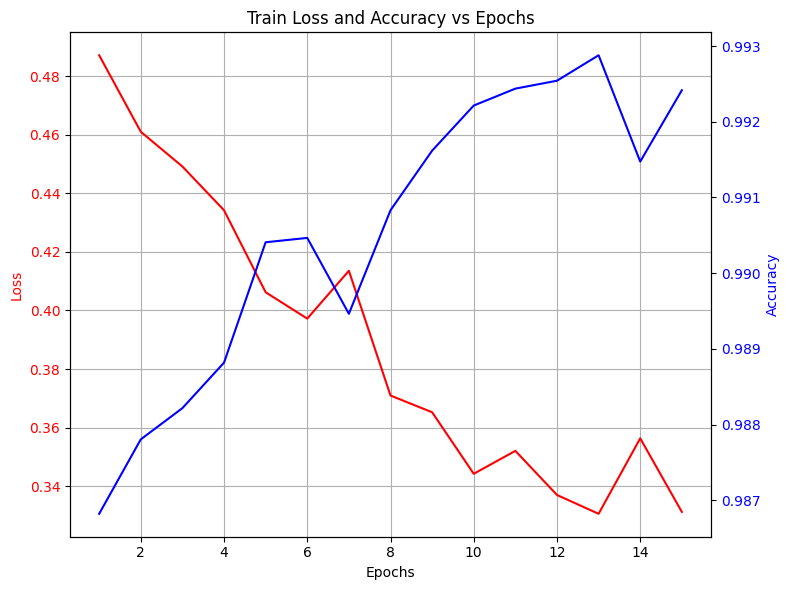

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_model(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    device=device,
    epochs=15,
    patience=4,
    save_path="best_swinunet_model.pth"
)


In [40]:
def dice_score(preds, targets, num_classes=4, smooth=1e-6):
    dice_per_class = []
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()

        dice = (2 * intersection + smooth) / (union + smooth)
        dice_per_class.append(dice.item())
    return dice_per_class


def evaluate_model(model, val_loader, device, num_classes=4):
    model.eval()
    total_dice = torch.zeros(num_classes).to(device)
    total_batches = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            main_pred = outputs[0]  # Only use main prediction

            # Resize to match mask size if needed
            main_pred = F.interpolate(main_pred, size=masks.shape[1:], mode="bilinear", align_corners=False)

            preds = torch.argmax(main_pred, dim=1)

            batch_dice = dice_score(preds, masks, num_classes=num_classes)
            total_dice += torch.tensor(batch_dice, device=device)
            total_batches += 1

    avg_dice = total_dice / total_batches

    for cls, score in enumerate(avg_dice):
        print(f"🔹 Dice Score for Class {cls}: {score:.4f}")
    print(f"\n🎯 Mean Dice Score: {avg_dice.mean():.4f}")


In [41]:
evaluate_model(model, val_loader, device)

✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_flair.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t1ce.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_349\BraTS20_Training_349_t2.nii
✅ Loading: C:\Users\Dell\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraT

In [ ]:
# import torch
# from torch.utils.data import DataLoader
# from tqdm import tqdm


# optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
# def train_model(model, train_loader, val_loader, optimizer, num_epochs, device):
#     best_val_loss = float('inf')

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
#             images = images.to(device)
#             masks = masks.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = combined_loss(outputs, masks)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item() * images.size(0)

#         avg_train_loss = train_loss / len(train_loader.dataset)

#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
#                 images = images.to(device)
#                 masks = masks.to(device)

#                 outputs = model(images)
#                 loss = combined_loss(outputs, masks)

#                 val_loss += loss.item() * images.size(0)

#         avg_val_loss = val_loss / len(val_loader.dataset)

#         print(f"\n🔁 Epoch [{epoch+1}/{num_epochs}] | 🏋️ Train Loss: {avg_train_loss:.4f} | ✅ Val Loss: {avg_val_loss:.4f}")

#         # Save best model
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             torch.save(model.state_dict(), 'best_swinunet.pth')
#             print("💾 Best model saved!")

In [ ]:
# train_model(model, train_loader, val_loader, optimizer, num_epochs=15, device=device)

In [42]:
torch.save(model,'combined_loss2020.pth')